In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%pip install pygal
import pygal
%pip install textdistance
from textdistance import levenshtein

from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn import datasets, svm, metrics

labelencoder = LabelEncoder()

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 129 kB 7.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **RESEARCH QUESTIONS**


1. Does economy of the country affect their performance? (merging 1)
2. What is the estimated number of appearances for a participant to achieve their first medal?
3. What are the features that most affect player performance?
4. Predict whether the player could get a medal or not next year?
5. How different BMI ranges are demanded, and what are the effects and changes of BMI? (feature engineering 1)
6. How hosting events affects country's performance? (feature engineering 2)
7. Do countries with high gdp are chosen to host the olympics ?
8. Do the number of medals on average increase as an athlete participates more?
9. What are the performances of both genders?
10. Is the number of medals related to the number of each medal?

# **READING THE DATA**

Reading the two raw datasets, regions and athletes datasets.

In [74]:
df_olympics_raw = pd.read_csv('/content/drive/MyDrive/Data Engineering/dataset/athlete_events.csv')
df_regions_raw = pd.read_csv('/content/drive/MyDrive/Data Engineering/dataset/noc_regions.csv')

# df_olympics_raw = pd.read_csv('athlete_events.csv')
# df_regions_raw = pd.read_csv('noc_regions.csv')

print(len(df_olympics_raw))
df_regions_raw.info()

271116
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


At the beginning we read the two datasets, athletes and regions. As we were exploring the data, we considered joining the athlete dataset with the regions dataset on the NOC attribute which was found in both datasets. Yet, we found out that the number of data objects were reduced after merging the two datasets. We then figured out that this behaviour was a result of several objects with the attribute NOC equal to SGP that did not appear in regions dataset. But also we had a SIN attribute that appeared in regions but not athletes dataset. Where both were actually representing the same country, hence we replaced SGP regions with SIN and merged data.


In [75]:
# Getting unique values in both
olymicsNOC = df_olympics_raw['NOC'].unique()
regionsNOC = df_regions_raw['NOC'].unique()

print("Elements in  athletes dataset but not in regions dataset")
for noc in olymicsNOC:
  if noc not in regionsNOC:
    print(noc)

print("")

print("Elements in  regions dataset but not in athletes dataset")
for noc in regionsNOC:
  if noc not in olymicsNOC :
    print(noc)

print("")

# We only care about the elements that were in athletes dataset without a matching region
noMatch = df_olympics_raw[df_olympics_raw['NOC']=='SGP']
print("Number of elements with missing a matching region in athletes dataset:", len(noMatch))


Elements in  athletes dataset but not in regions dataset
SGP

Elements in  regions dataset but not in athletes dataset
SIN

Number of elements with missing a matching region in athletes dataset: 349


Merging the datasets after filling the missing NOC records

In [76]:
# Replacing SIN with SGP as this is the element found in athletes dataset
df_regions = df_regions_raw
df_regions['region'].replace('SIN','SGP',inplace=True)
df_olympics = pd.merge(df_olympics_raw, df_regions, left_on = 'NOC',right_on = 'NOC')

In [77]:
df_olympics.head(5)

ID           Name Sex  ...  Medal  region  notes
0     1      A Dijiang   M  ...    NaN   China    NaN
1     2       A Lamusi   M  ...    NaN   China    NaN
2   602  Abudoureheman   M  ...    NaN   China    NaN
3  1463      Ai Linuer   M  ...    NaN   China    NaN
4  1464      Ai Yanhan   F  ...    NaN   China    NaN

[5 rows x 17 columns]

In [78]:
df_olympics.shape

(270767, 17)

In [79]:
df_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270767 entries, 0 to 270766
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      270767 non-null  int64  
 1   Name    270767 non-null  object 
 2   Sex     270767 non-null  object 
 3   Age     261305 non-null  float64
 4   Height  210684 non-null  float64
 5   Weight  207982 non-null  float64
 6   Team    270767 non-null  object 
 7   NOC     270767 non-null  object 
 8   Games   270767 non-null  object 
 9   Year    270767 non-null  int64  
 10  Season  270767 non-null  object 
 11  City    270767 non-null  object 
 12  Sport   270767 non-null  object 
 13  Event   270767 non-null  object 
 14  Medal   39774 non-null   object 
 15  region  270746 non-null  object 
 16  notes   5039 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 37.2+ MB


In [80]:
df_olympics.describe()

ID            Age  ...         Weight           Year
count  270767.000000  261305.000000  ...  207982.000000  270767.000000
mean    68229.276832      25.559783  ...      70.709523    1978.362297
std     39017.998824       6.392501  ...      14.350094      29.884637
min         1.000000      10.000000  ...      25.000000    1896.000000
25%     34630.500000      21.000000  ...      60.000000    1960.000000
50%     68187.000000      24.000000  ...      70.000000    1988.000000
75%    102065.500000      28.000000  ...      79.000000    2002.000000
max    135571.000000      97.000000  ...     214.000000    2016.000000

[8 rows x 5 columns]

In [81]:
df_olympics.nunique()

ID        135404
Name      134566
Sex            2
Age           74
Height        95
Weight       220
Team        1179
NOC          229
Games         51
Year          35
Season         2
City          42
Sport         66
Event        765
Medal          3
region       205
notes         21
dtype: int64

# **EDA**

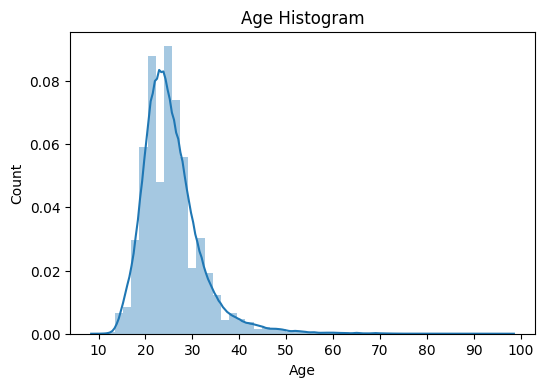

In [82]:
#plot a histogram of age 
bins = [0,10,20,30,40,50,60,70,80,90,100]#the intervals (bins) of the histogram
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Age Histogram')
axs_1.set_xlabel('Age')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) #zoom in, or show me a certain area on the graph 
axs_1.set_ylabel('Count')
sns.distplot(df_olympics['Age'])#a numpy array that has the ages of each passenger who survived (all ages not only unique values)

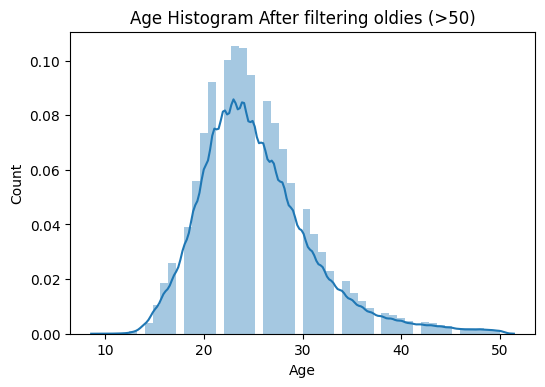

In [83]:
df_filtered_ages_olympics_50=df_olympics[df_olympics['Age']<=50] #removed 0.7%

#plot a histogram of age 
bins = [0,10,20,30,40,50,60,70,80,90,100]#the intervals (bins) of the histogram
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Age Histogram After filtering oldies (>50)')
axs_1.set_xlabel('Age')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) #zoom in, or show me a certain area on the graph 
axs_1.set_ylabel('Count')
sns.distplot(df_filtered_ages_olympics_50['Age'])#a numpy array that has the ages of each passenger who survived (all ages not only unique values)

In [84]:
df_olympics[df_olympics['Age']==97]

ID                    Name Sex  ...  Medal  region  notes
32196  128719  John Quincy Adams Ward   M  ...    NaN     USA    NaN

[1 rows x 17 columns]

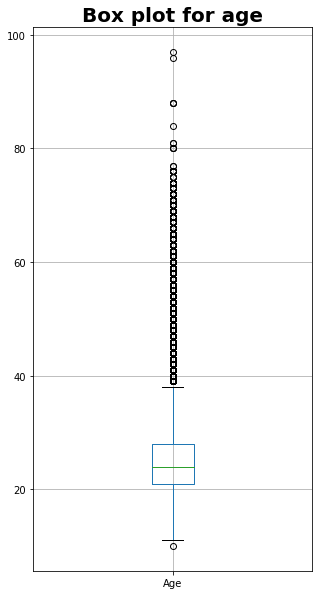

In [85]:
fig, ax = plt.subplots(1, figsize = (5,10))
df_olympics.boxplot(ax=ax, column=['Age'])
plt.title('Box plot for age', fontsize = 20, fontweight="bold")
plt.show()

# df_olympics.boxplot(column =['Age'], grid = False, figsize=(10,10))

(array([6.9000e+01, 7.8700e+02, 6.1980e+03, 3.4586e+04, 7.3029e+04,
        6.6771e+04, 2.4641e+04, 4.0980e+03, 4.6200e+02, 4.3000e+01]),
 array([127. , 136.9, 146.8, 156.7, 166.6, 176.5, 186.4, 196.3, 206.2,
        216.1, 226. ]),
 <a list of 10 Patch objects>)

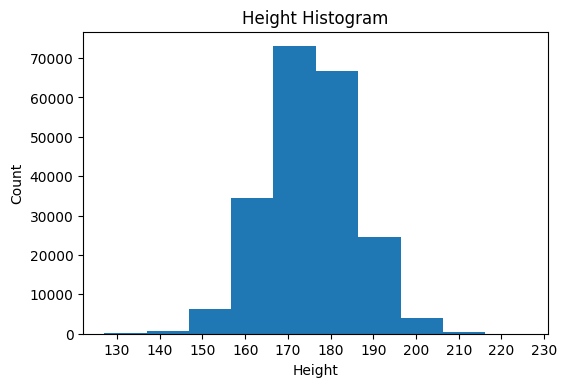

In [86]:
 #plot a histogram of age 
bins = np.arange(0,260,10)#the intervals (bins) of the histogram
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Height Histogram')
axs_1.set_xlabel('Height')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) #zoom in, or show me a certain area on the graph 
axs_1.set_ylabel('Count')
axs_1.hist(df_olympics['Height'],width=10)#a numpy array that has the ages of each passenger who survived (all ages not only unique values)

In [87]:
#multiple NOCs belong to the same region
print(df_regions.shape)
print(len(df_regions['region'].unique()))
print(df_regions.region.value_counts()[:20])
print(df_regions[df_regions['region']=='Germany'])

(230, 3)
207
Germany           4
Russia            3
Malaysia          3
Yemen             3
Serbia            3
Czech Republic    3
Trinidad          2
Canada            2
Zimbabwe          2
China             2
Australia         2
Greece            2
Vietnam           2
Syria             2
American Samoa    1
Swaziland         1
Seychelles        1
Myanmar           1
Saint Vincent     1
USA               1
Name: region, dtype: int64
     NOC   region notes
70   FRG  Germany   NaN
76   GDR  Germany   NaN
79   GER  Germany   NaN
173  SAA  Germany   NaN


In [88]:
df_olympics_medal_holders=df_olympics.dropna(subset=['Medal'])

medalists=df_olympics_medal_holders.groupby(['region','Medal'])['Name'].count()
medalists

region       Medal 
Afghanistan  Bronze     2
Algeria      Bronze     8
             Gold       5
             Silver     4
Argentina    Bronze    91
                       ..
Zambia       Bronze     1
             Silver     1
Zimbabwe     Bronze     1
             Gold      17
             Silver     4
Name: Name, Length: 327, dtype: int64

In [89]:
df_olympics[(df_olympics['NOC']=='EGY') & (df_olympics['Sport']=='Football') & (df_olympics['Year']==2012)  ]

ID                                              Name  ... region  notes
68052     501                 Mohamed Mohamed Mohamed Aboutrika  ...  Egypt    NaN
68082    1417                 Shehabeldin Ahmed Saad Ahmed Saad  ...  Egypt    NaN
68094    2208                 Mahmoud Alaa El-Din Mahmoud Alian  ...  Egypt    NaN
68451   32113                   Mohamed Nasir Al-Sayyid El-Neny  ...  Egypt    NaN
68515   32170                     Ahmed Nasir Mahmud El-Shenawi  ...  Egypt    NaN
68596   34221              Ahmed Fathi Abdulmunim Ahmed Ibrahim  ...  Egypt    NaN
68617   37778                          Omar Mahmud Sayyid Gaber  ...  Egypt    NaN
68647   41234                                 Saleh Saleh Gomaa  ...  Egypt    NaN
68717   46480                    Hossam Hassan Mohamed Abdallah  ...  Egypt    NaN
68746   47146              Ahmed Al-Sayyid Ali Al-Sayyid Hegazi  ...  Egypt    NaN
68920   73380                          Ahmed Magdy Sa'd Mohamed  ...  Egypt    NaN
68991   80007               Eslam Muhammad "Milo" Ramadan Rashd  ...  Egypt    NaN
69042   80996                 Marwan Mohsen Fahmy Thirwat Fahmy  ...  Egypt    NaN
69054   82498  Emad Mohamed Abdel Naby Ibrahim Mohamed "Moteab"  ...  Egypt    NaN
69241  104595                        Mohamed Salah Haamid Ghaly  ...  Egypt    NaN
69264  104989                   Saadeldin "Saad" Samir Saad Ali  ...  Egypt    NaN

[16 rows x 17 columns]

Text(0.5, 1.0, 'Age distribution')

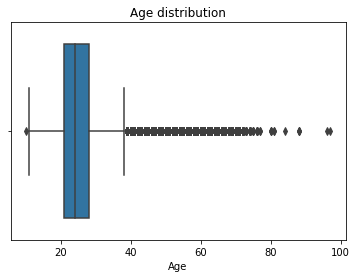

In [90]:
sns.boxplot(df_olympics['Age'])
plt.title('Age distribution')

Text(0.5, 0, 'Sport')

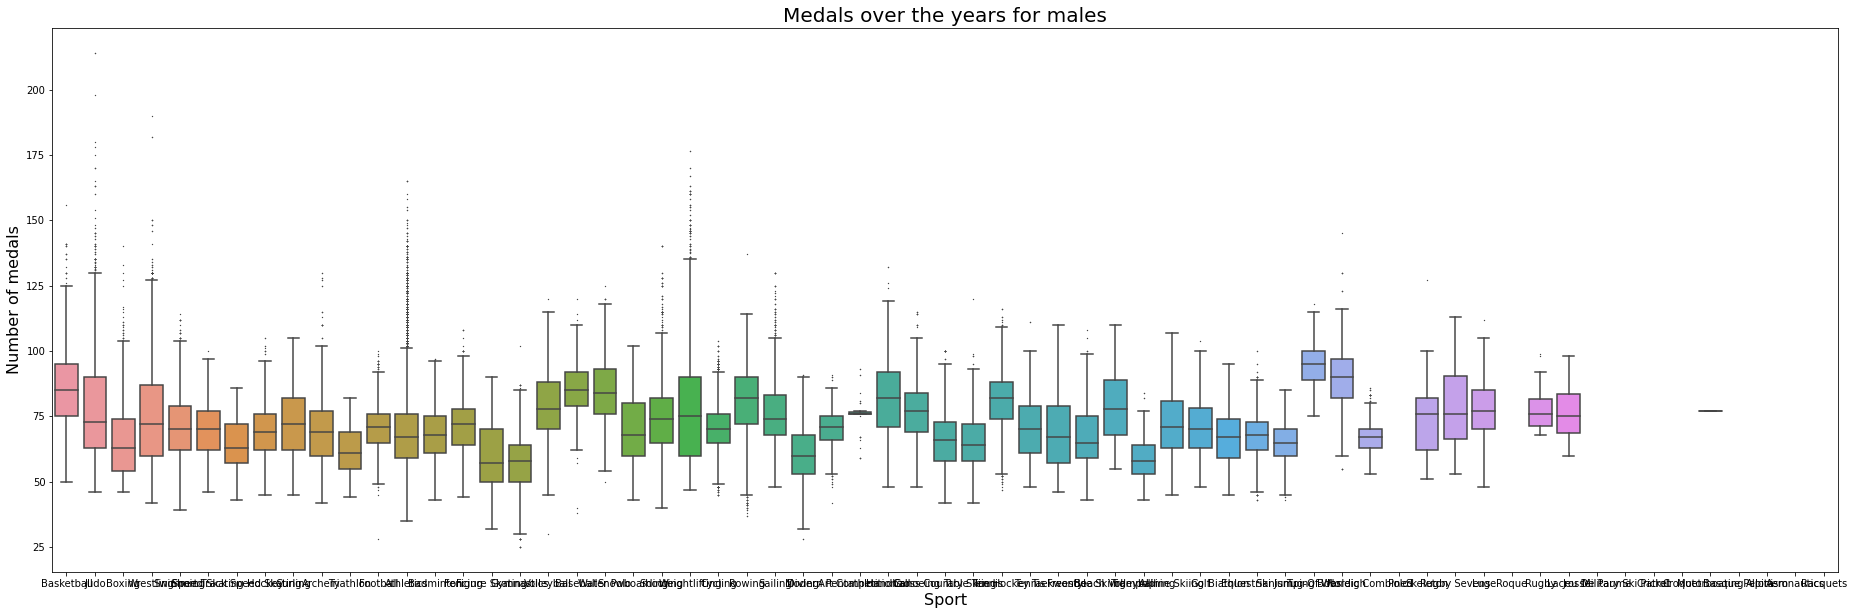

In [91]:
sportsForMales = df_olympics[df_olympics.Sex=='M'].Sport.unique()
fig, ax = plt.subplots(figsize=(32,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(sportsForMales)],x='Sport',y='Weight',fliersize=1/2)

plt.title('Male weights per Sports');
ax.set_title('Medals over the years for males' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Sport",fontsize=16 )

Text(0.5, 0, 'Sport')

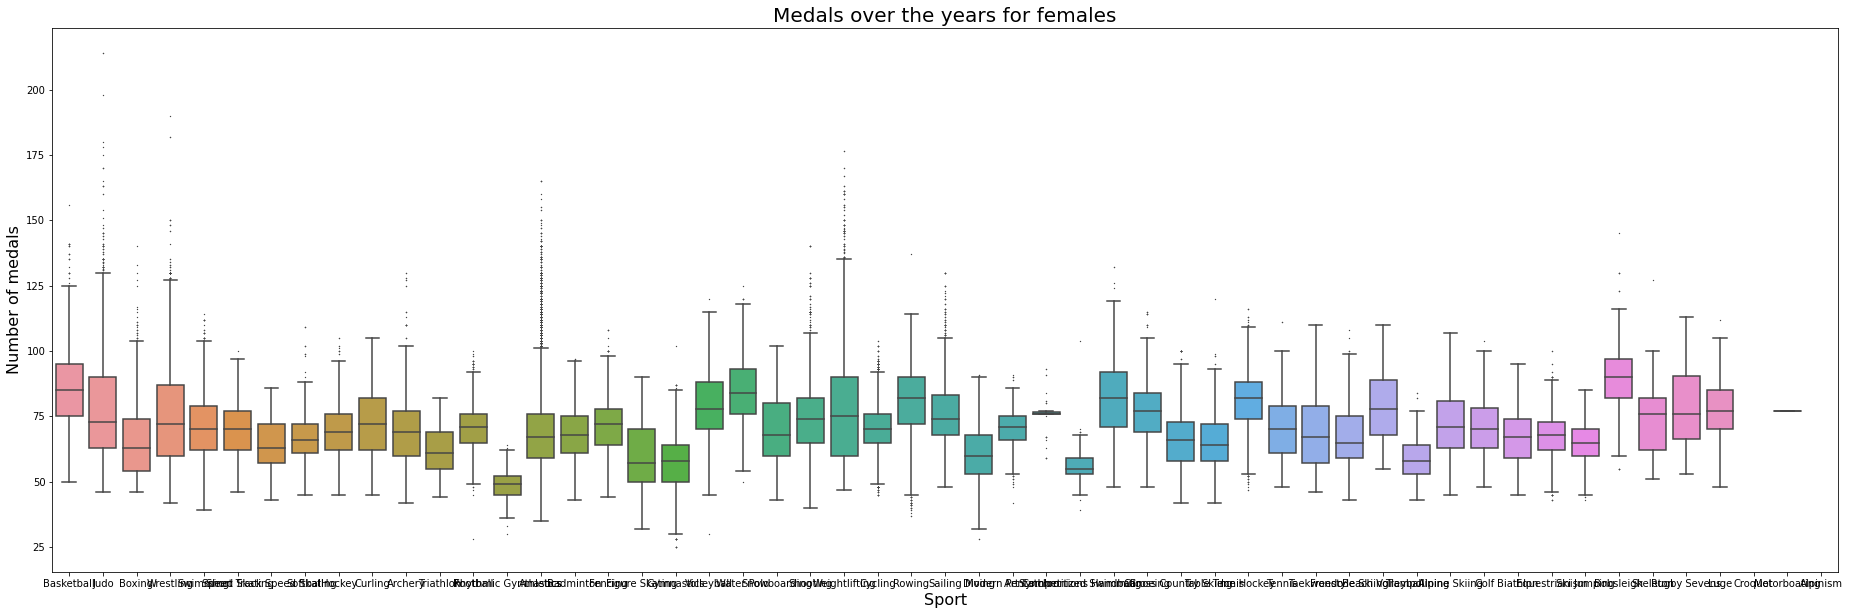

In [92]:
sportsForFemales = df_olympics[df_olympics.Sex=='F'].Sport.unique()
fig, ax = plt.subplots(figsize=(32,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(sportsForFemales)],x='Sport',y='Weight',fliersize=1/2)

plt.title('Female weights per Sports');
ax.set_title('Medals over the years for females' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Sport",fontsize=16 )

In [93]:
df_olympics.groupby(['Team']).count().sort_values(by='ID').head(50)

ID  Name  Sex  Age  ...  Event  Medal  region  notes
Team                                    ...                             
Bonaparte            1     1    1    1  ...      1      1       1      0
Greenoaks Dundee     1     1    1    1  ...      1      0       1      0
Rambo                1     1    1    1  ...      1      0       1      0
Bremen               1     1    1    1  ...      1      0       1      0
Brentina             1     1    1    1  ...      1      0       1      0
Breslau              1     1    1    1  ...      1      0       1      0
Briar                1     1    1    1  ...      1      0       1      0
Ravel                1     1    1    1  ...      1      0       1      0
Relampago            1     1    1    1  ...      1      0       1      0
Brynhild-2           1     1    1    1  ...      1      1       1      0
Gran Gesto           1     1    1    1  ...      1      0       1      0
Turquoise-1          1     1    1    1  ...      1      1       1      0
Rostock              1     1    1    1  ...      1      1       1      0
Rozenn-3             1     1    1    0  ...      1      0       1      0
Calimucho            1     1    1    1  ...      1      0       1      0
Galopin De La Font   1     1    1    1  ...      1      0       1      0
Brandenburg          1     1    1    1  ...      1      0       1      0
Tournade-40          1     1    1    0  ...      1      0       1      0
Quando Quando        1     1    1    1  ...      1      0       1      0
Gyp-6                1     1    1    0  ...      1      0       1      0
Orion                1     1    1    1  ...      1      0       1      0
Verveine-41          1     1    1    0  ...      1      0       1      0
Oxalis               1     1    1    1  ...      1      0       1      0
Verveine-19          1     1    1    0  ...      1      0       1      0
Pettit-Poucet-6      1     1    1    1  ...      1      0       1      0
Pierre et Jean-3     1     1    1    1  ...      1      0       1      0
Pirouette-31         1     1    1    1  ...      1      0       1      0
Plume-patte-32       1     1    1    0  ...      1      0       1      0
Pop Art              1     1    1    1  ...      1      0       1      0
Heidelberg           1     1    1    1  ...      1      0       1      0
Potsdam              1     1    1    1  ...      1      1       1      0
Hb-24                1     1    1    0  ...      1      0       1      0
Hb-20                1     1    1    0  ...      1      0       1      0
Hannover             1     1    1    1  ...      1      0       1      0
Hamburg              1     1    1    1  ...      1      0       1      0
Gyp-23               1     1    1    0  ...      1      0       1      0
Baby-9               1     1    1    0  ...      1      0       1      0
Camille              1     1    1    1  ...      1      1       1      0
Tornade-16           1     1    1    0  ...      1      0       1      0
Don Schufro          1     1    1    1  ...      1      1       1      0
Sunrise              1     1    1    1  ...      1      1       1      0
Digby                1     1    1    1  ...      1      1       1      0
Crabe I-11           1     1    1    1  ...      1      0       1      0
Crabe I-2            1     1    1    1  ...      1      0       1      0
Crabe I-3            1     1    1    1  ...      1      0       1      0
Dick-8               1     1    1    0  ...      1      0       1      0
Diabolo St Maurice   1     1    1    1  ...      1      0       1      0
Solos Carex          1     1    1    1  ...      1      0       1      0
Crocodile-13         1     1    1    1  ...      1      0       1      0
Demi-Mondaine-17     1     1    1    0  ...      1      0       1      0

[50 rows x 16 columns]

Text(0.5, 0.98, 'Countries winning the most number of each medal')

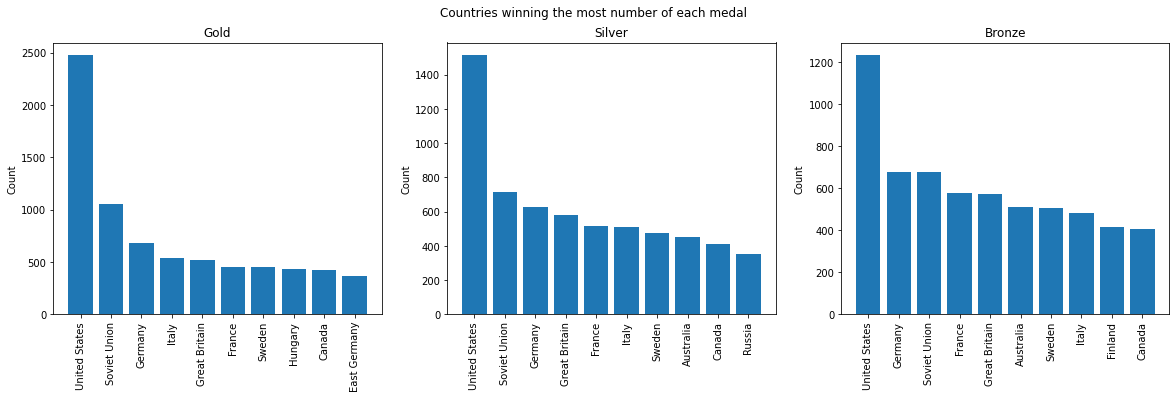

In [94]:
top_country_with_medals_df = df_olympics.groupby(['Medal', 'Team'])['ID'].count()
top_country_with_medals_df
gold_medals_sorted_df = top_country_with_medals_df['Gold'].sort_values(ascending=False)
silver_medals_sorted_df = top_country_with_medals_df['Silver'].sort_values(ascending=False)
bronze_medals_sorted_df = top_country_with_medals_df['Bronze'].sort_values(ascending=False)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1.bar(gold_medals_sorted_df[:10].index, gold_medals_sorted_df[:10])
ax1.set_xticklabels(gold_medals_sorted_df[:10].index, rotation=90);
ax1.set_ylabel('Count')
ax1.set_title('Gold')

ax2.bar(silver_medals_sorted_df[:10].index, silver_medals_sorted_df[:10])
ax2.set_xticklabels(silver_medals_sorted_df[:10].index, rotation=90);
ax2.set_ylabel('Count')
ax2.set_title('Silver')

ax3.bar(bronze_medals_sorted_df[:10].index, bronze_medals_sorted_df[:10])
ax3.set_xticklabels(bronze_medals_sorted_df[:10].index, rotation=90);
ax3.set_ylabel('Count')
ax3.set_title('Bronze')
fig.suptitle('Countries winning the most number of each medal')

In [95]:
athletes_winter_df = df_olympics[df_olympics['Season'] == 'Winter']
athletes_summer_df = df_olympics[df_olympics['Season'] == 'Summer']

print('Winter: ', athletes_winter_df.Sport.unique())
print('Summer: ', athletes_summer_df.Sport.unique())

#Sports that are in winter games only
only_winter_sports = {s for s in athletes_winter_df.Sport if s not in athletes_summer_df.Sport}
print("Sports that are in winter games only: ", only_winter_sports)

#Sports that are in suumer games only
only_summer_sports = {s for s in athletes_summer_df.Sport if s not in athletes_winter_df.Sport}
print("Sports that are in summer games only: ", only_summer_sports)



Winter:  ['Speed Skating' 'Short Track Speed Skating' 'Curling' 'Figure Skating'
 'Snowboarding' 'Cross Country Skiing' 'Ice Hockey' 'Freestyle Skiing'
 'Alpine Skiing' 'Biathlon' 'Ski Jumping' 'Bobsleigh' 'Nordic Combined'
 'Skeleton' 'Luge' 'Military Ski Patrol' 'Alpinism']
Summer:  ['Basketball' 'Judo' 'Boxing' 'Wrestling' 'Swimming' 'Softball' 'Hockey'
 'Archery' 'Triathlon' 'Football' 'Rhythmic Gymnastics' 'Athletics'
 'Badminton' 'Fencing' 'Gymnastics' 'Volleyball' 'Baseball' 'Water Polo'
 'Shooting' 'Weightlifting' 'Cycling' 'Rowing' 'Sailing' 'Diving'
 'Modern Pentathlon' 'Art Competitions' 'Synchronized Swimming' 'Handball'
 'Canoeing' 'Table Tennis' 'Tennis' 'Taekwondo' 'Beach Volleyball'
 'Trampolining' 'Golf' 'Equestrianism' 'Tug-Of-War' 'Polo' 'Rugby Sevens'
 'Ice Hockey' 'Figure Skating' 'Roque' 'Rugby' 'Lacrosse' 'Jeu De Paume'
 'Cricket' 'Croquet' 'Motorboating' 'Basque Pelota' 'Alpinism'
 'Aeronautics' 'Racquets']
Sports that are in winter games only:  {'Skeleton', 'No

**Timeline of countries winning medals**


In [96]:
athletes_medals_df = df_olympics.dropna(axis='index', subset=['Medal'])
athletes_medals_df[df_olympics['ID'] == 1017]

ID                    Name Sex  ...   Medal  region  notes
14642  1017  Nathan Ghar-Jun Adrian   M  ...    Gold     USA    NaN
14643  1017  Nathan Ghar-Jun Adrian   M  ...    Gold     USA    NaN
14644  1017  Nathan Ghar-Jun Adrian   M  ...  Silver     USA    NaN
14645  1017  Nathan Ghar-Jun Adrian   M  ...    Gold     USA    NaN
14646  1017  Nathan Ghar-Jun Adrian   M  ...  Bronze     USA    NaN
14647  1017  Nathan Ghar-Jun Adrian   M  ...  Bronze     USA    NaN
14648  1017  Nathan Ghar-Jun Adrian   M  ...    Gold     USA    NaN
14649  1017  Nathan Ghar-Jun Adrian   M  ...    Gold     USA    NaN

[8 rows x 17 columns]

In [97]:
athletes_medals_df[(athletes_medals_df['NOC'] == 'USA') & (athletes_medals_df['Year'] == 2016)]


ID                        Name Sex  ...   Medal  region  notes
14630     837        Rachael Alexis Adams   F  ...  Bronze     USA    NaN
14646    1017      Nathan Ghar-Jun Adrian   M  ...  Bronze     USA    NaN
14647    1017      Nathan Ghar-Jun Adrian   M  ...  Bronze     USA    NaN
14648    1017      Nathan Ghar-Jun Adrian   M  ...    Gold     USA    NaN
14649    1017      Nathan Ghar-Jun Adrian   M  ...    Gold     USA    NaN
...       ...                         ...  ..  ...     ...     ...    ...
32531  129913        Lindsay Marie Whalen   F  ...    Gold     USA    NaN
32803  130696  Venus Ebony Starr Williams   F  ...  Silver     USA    NaN
33087  131614               Kelsi Worrell   F  ...    Gold     USA    NaN
33103  131654   Dagmara Wozniak (Woniak-)   F  ...  Bronze     USA    NaN
33316  133685        Mariel Leigh Zagunis   F  ...  Bronze     USA    NaN

[264 rows x 17 columns]

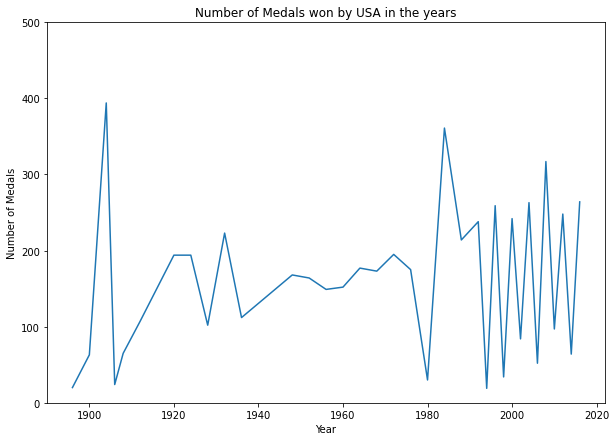

In [98]:
# United States
medals_per_country_across_years = athletes_medals_df.groupby(['NOC','Year'])['Medal'].count()
usa_medas_per_year = medals_per_country_across_years['USA']

plt.figure(figsize=(10,7))
plt.plot(usa_medas_per_year,)
plt.title('Number of Medals won by USA in the years')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.ylim(0,500);

# **OUTLIERS & EXTREME VALUES**

We found that there is no age restrictions for joining the olympics, and the age range was not discontinuous (no explicit outlier), as well as there were a number of athletes above 60 who won medals.

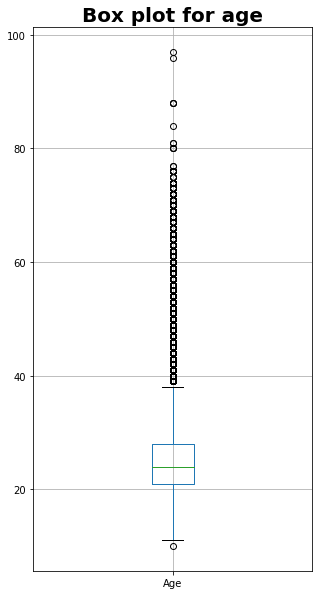

In [99]:
fig, ax = plt.subplots(1, figsize = (5,10))
df_olympics.boxplot(ax=ax, column=['Age'])
plt.title('Box plot for age', fontsize = 20, fontweight="bold")
plt.show()

# df_olympics.boxplot(column =['Age'], grid = False, figsize=(10,10))

In [100]:
above60 = df_olympics[df_olympics['Age']>65 ]
above60WithMedals = above60[above60['Medal'] !='no medal' ]
above60WithMedals.head(5)

ID                                  Name Sex  ...  Medal   region  notes
5539  18252  Anne Marie Carl-Nielsen (Brodersen-)   F  ...    NaN  Denmark    NaN
5540  18252  Anne Marie Carl-Nielsen (Brodersen-)   F  ...    NaN  Denmark    NaN
5541  18252  Anne Marie Carl-Nielsen (Brodersen-)   F  ...    NaN  Denmark    NaN
5542  18252  Anne Marie Carl-Nielsen (Brodersen-)   F  ...    NaN  Denmark    NaN
5543  18252  Anne Marie Carl-Nielsen (Brodersen-)   F  ...    NaN  Denmark    NaN

[5 rows x 17 columns]

#### **Handling AGE outliers**

Handled with two functions, where the first function takes the dataframe for a single sport and calculates the right and left whiskers as well as the mean of the entries that are not considered outliers. Second function replaces the outliers of the age column for each sport with the mean of the age of participants without the outliers. In other words, replacing age outliers with the mean per sport.

**BEFORE handling age outliers**

In [101]:
df_olympics.describe()

ID            Age  ...         Weight           Year
count  270767.000000  261305.000000  ...  207982.000000  270767.000000
mean    68229.276832      25.559783  ...      70.709523    1978.362297
std     39017.998824       6.392501  ...      14.350094      29.884637
min         1.000000      10.000000  ...      25.000000    1896.000000
25%     34630.500000      21.000000  ...      60.000000    1960.000000
50%     68187.000000      24.000000  ...      70.000000    1988.000000
75%    102065.500000      28.000000  ...      79.000000    2002.000000
max    135571.000000      97.000000  ...     214.000000    2016.000000

[8 rows x 5 columns]

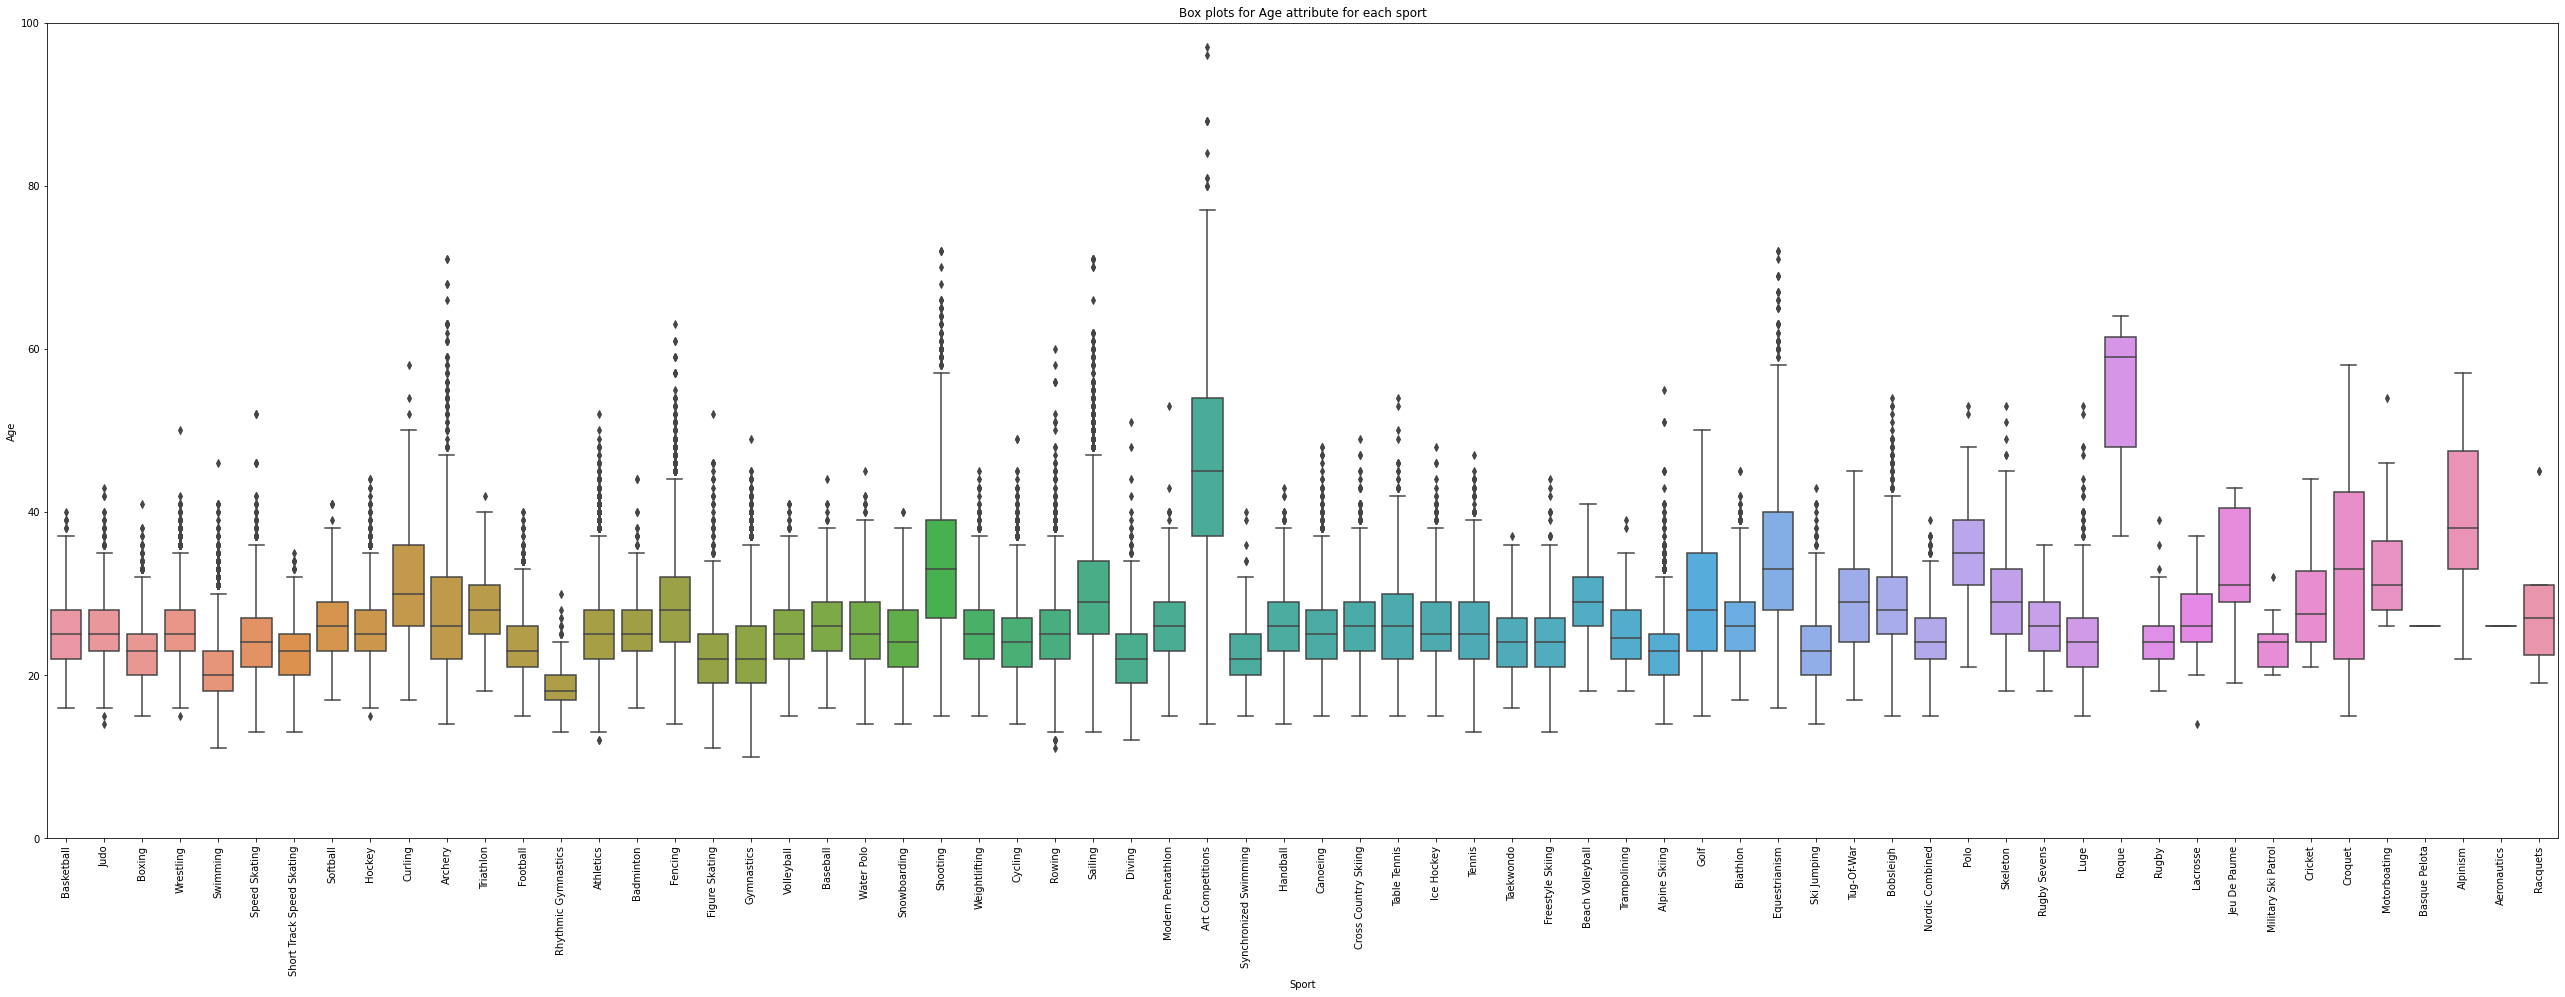

In [102]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Age')

averageAge = round(df_olympics['Age'].mean())
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.title('Box plots for Age attribute for each sport');

In [103]:
def get_age_mean_without_outliers(sport_df):
    Q1 = sport_df.Age.quantile(0.25)
    Q2 = sport_df.Age.quantile(0.5)
    Q3 = sport_df.Age.quantile(0.75)
    IQR = Q3 - Q1
    left_whisker = Q1 - 1.5 * IQR
    right_whisker = Q3 + 1.5 * IQR
    sport_inliers = sport_df[(sport_df.Age <= right_whisker) & (sport_df.Age >= left_whisker)]
    mean = sport_inliers.Age.mean()

    return {
        'right_whisker': right_whisker,
        'left_whisker' : left_whisker,
        'mean' : int(mean)
    }

In [104]:
def handle_age_outliers(athletes_df):
    athletes_df_no_age_outliers = pd.DataFrame()
    n_outliers = 0
    olympics_sports = athletes_df.Sport.unique()
    for s in olympics_sports:
        sport_df = athletes_df[athletes_df.Sport == s]
        outliers_dict = get_age_mean_without_outliers(sport_df=sport_df)

        outliers_age_list = np.array(sport_df.loc[(sport_df.Age < outliers_dict['left_whisker']) | (sport_df.Age > outliers_dict['right_whisker']), 'Age'])
        n_outliers+= len(outliers_age_list)
        sport_df.Age.replace(outliers_age_list, outliers_dict['mean'], inplace=True)
        athletes_df_no_age_outliers = athletes_df_no_age_outliers.append(sport_df)
    return athletes_df_no_age_outliers

In [105]:
df_olympics = handle_age_outliers(df_olympics)

**AFTER handling age outliers**

In [106]:
df_olympics.describe()

ID            Age  ...         Weight           Year
count  270767.000000  261305.000000  ...  207982.000000  270767.000000
mean    68229.276832      25.360579  ...      70.709523    1978.362297
std     39017.998824       6.088544  ...      14.350094      29.884637
min         1.000000      10.000000  ...      25.000000    1896.000000
25%     34630.500000      21.000000  ...      60.000000    1960.000000
50%     68187.000000      24.000000  ...      70.000000    1988.000000
75%    102065.500000      28.000000  ...      79.000000    2002.000000
max    135571.000000      77.000000  ...     214.000000    2016.000000

[8 rows x 5 columns]

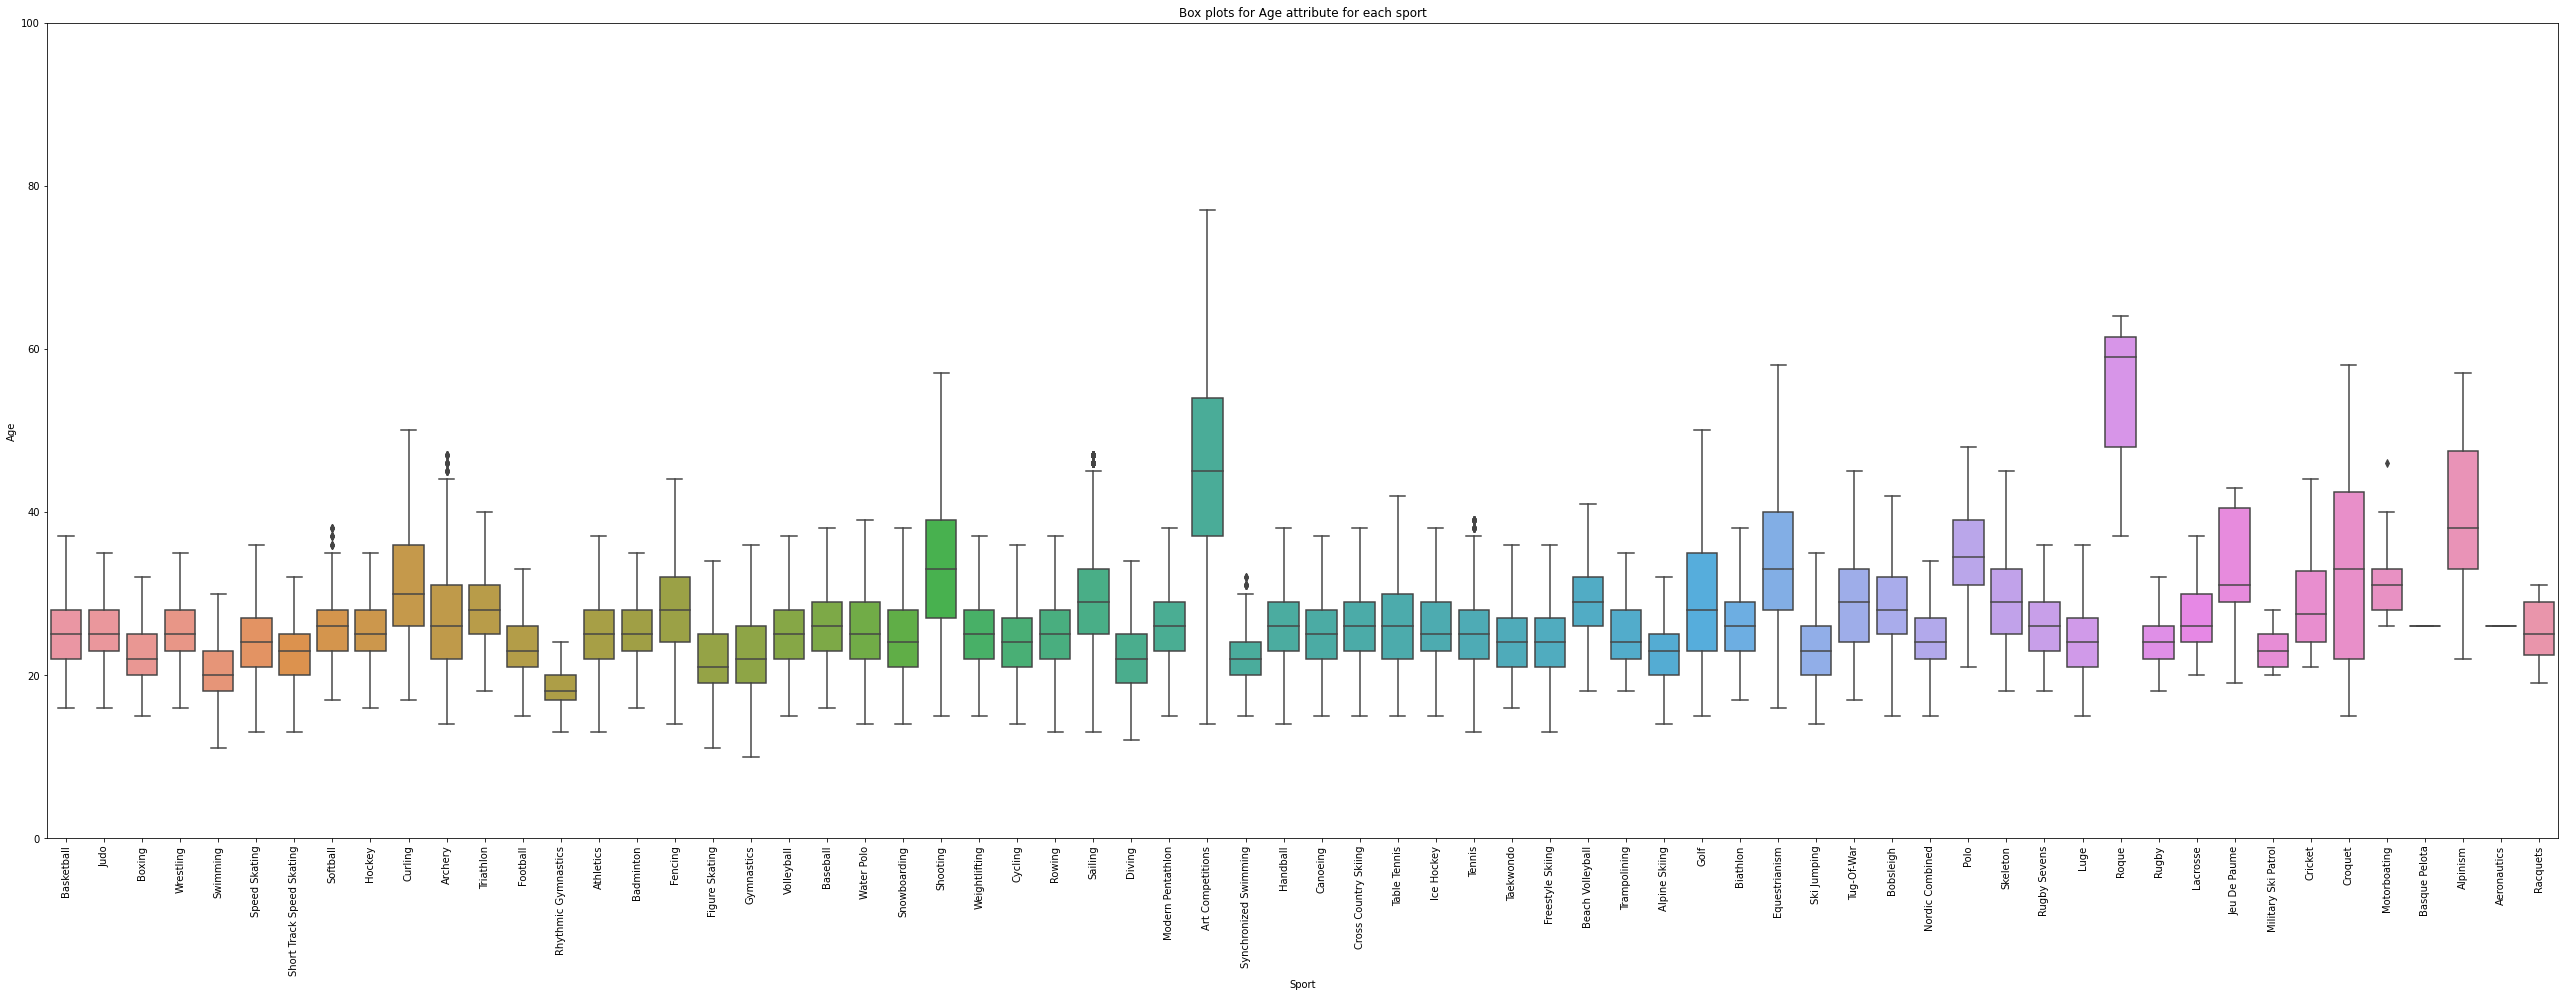

In [107]:
# AFTER handling age outliers
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Age')

averageAge = round(df_olympics['Age'].mean())

plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.title('Box plots for Age attribute for each sport');

#### **Handling WEIGHT outliers**

**BEFORE handling weight outliers**

In [108]:
df_olympics.describe()

ID            Age  ...         Weight           Year
count  270767.000000  261305.000000  ...  207982.000000  270767.000000
mean    68229.276832      25.360579  ...      70.709523    1978.362297
std     39017.998824       6.088544  ...      14.350094      29.884637
min         1.000000      10.000000  ...      25.000000    1896.000000
25%     34630.500000      21.000000  ...      60.000000    1960.000000
50%     68187.000000      24.000000  ...      70.000000    1988.000000
75%    102065.500000      28.000000  ...      79.000000    2002.000000
max    135571.000000      77.000000  ...     214.000000    2016.000000

[8 rows x 5 columns]

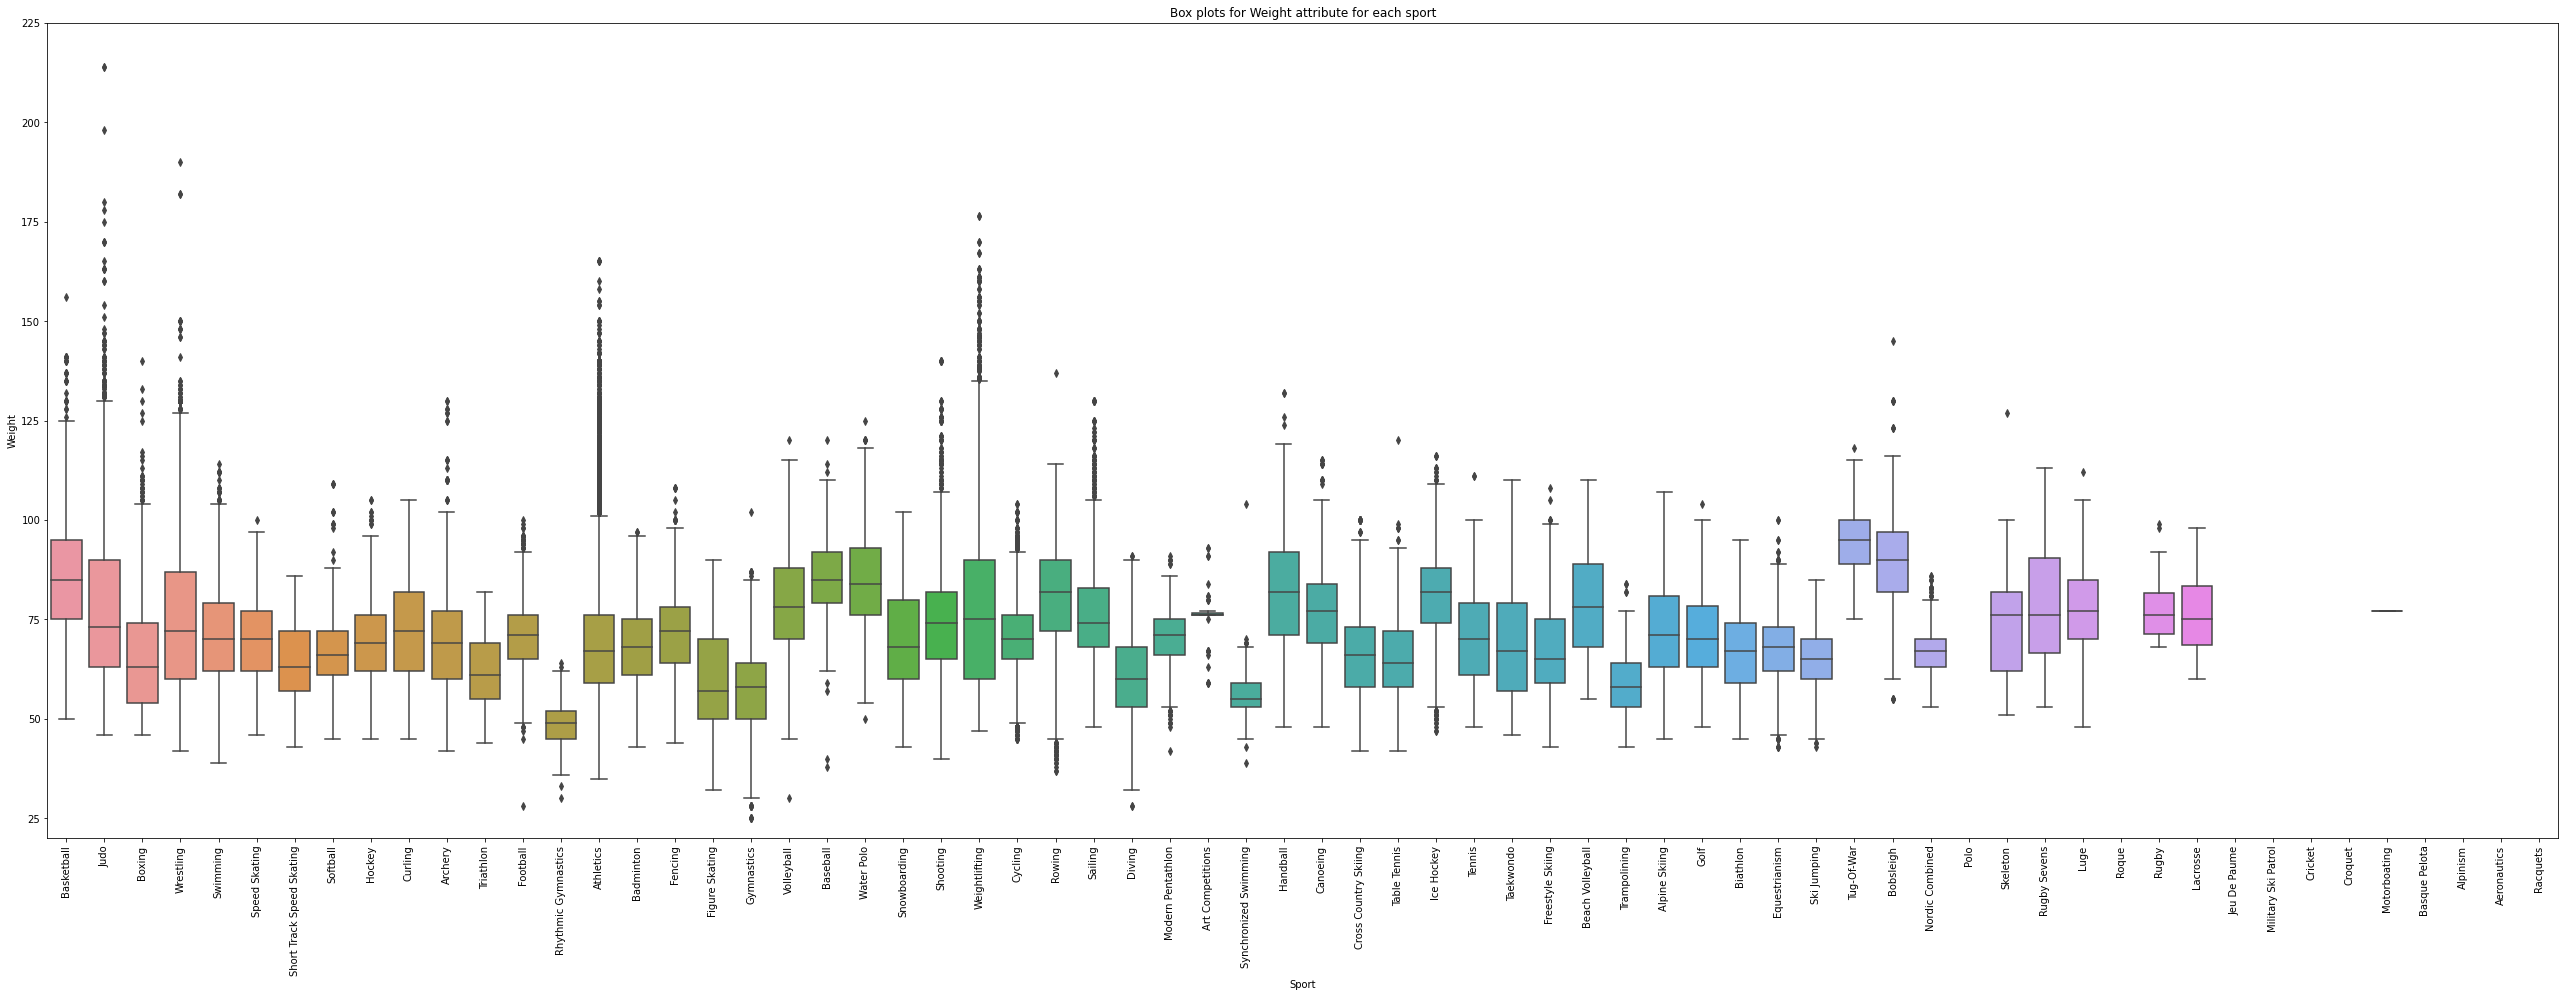

In [109]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Weight')

averageAge = round(df_olympics['Weight'].mean())

plt.ylim(20, 225)
plt.xticks(rotation=90)
plt.title('Box plots for Weight attribute for each sport');

In [110]:
def outliers_percentage_zscore(column,df):
    df_olympics_non_null = df[df_olympics[column].notna()]
    z=stats.zscore(df_olympics_non_null[column])
    z
    filtered=df_olympics_non_null[(z<3)&(z>-3)]

    print('Shape of df after dropping nulls',df_olympics_non_null.shape)
    print('Shape of non-outliers',filtered.shape)
    print((len(df_olympics_non_null)-len(filtered))*100/len(df))
    return len(df_olympics_non_null)-len(filtered)

We handled outliers first separating by gender for each event, but first by filtering the events that have no weights first then looping on the events, and using inter-quartile range to calculate the average of the values which aren't outliers, then assigning this value to the outliers. In other words, this means that w replaced outliers with the mean per event and gender. We choose weight specifically as some events had defined weight ranges for participants.

In [111]:
Events = df_olympics["Event"].unique()
def RemovingWeightOutliersPerGender(gender):
    eventsWithEmptyWeight = np.array([])
    for event in Events:
        temp = df_olympics[(df_olympics.Sex==gender) & (df_olympics.Event==event)]
        if temp.shape[0] == temp['Weight'].isna().sum():
            eventsWithEmptyWeight = np.append(eventsWithEmptyWeight, [event]) 
    validEvents = df_olympics['Event'].unique()
    validEvents = np.setdiff1d(validEvents, eventsWithEmptyWeight)
    sum = 0
    sum1 = 0 
    for event in validEvents:
        Q1 = df_olympics["Weight"].quantile(0.25)
        Q3 = df_olympics["Weight"].quantile(0.75)
        IQR = Q3 - Q1
        cut_off = IQR * 1.5
        lower = Q1 - cut_off
        upper =  Q3 + cut_off
        df1 = df_olympics[(df_olympics["Weight"]> upper) & (df_olympics.Sex==gender)& (df_olympics.Event==event)]
        df2 = df_olympics[(df_olympics["Weight"] < lower) & (df_olympics.Sex==gender)& (df_olympics.Event==event)]
        df = df_olympics[(df_olympics["Weight"] >= lower) & (df_olympics["Weight"] <= upper) & (df_olympics.Sex==gender)& (df_olympics.Event==event)]
        mean = df["Weight"].mean()
        df_olympics["Weight"].mask(((df_olympics["Weight"] < lower) | (df_olympics["Weight"] > upper)) & (df_olympics.Sex==gender)& (df_olympics.Event==event), mean, inplace = True)

In [112]:
RemovingWeightOutliersPerGender('F')
RemovingWeightOutliersPerGender('M')

**AFTER handling weight outliers**

In [113]:
df_olympics.describe()

ID            Age  ...         Weight           Year
count  270767.000000  261305.000000  ...  207980.000000  270767.000000
mean    68229.276832      25.360579  ...      70.310558    1978.362297
std     39017.998824       6.088544  ...      13.201366      29.884637
min         1.000000      10.000000  ...      32.000000    1896.000000
25%     34630.500000      21.000000  ...      60.000000    1960.000000
50%     68187.000000      24.000000  ...      70.000000    1988.000000
75%    102065.500000      28.000000  ...      79.000000    2002.000000
max    135571.000000      77.000000  ...     107.500000    2016.000000

[8 rows x 5 columns]

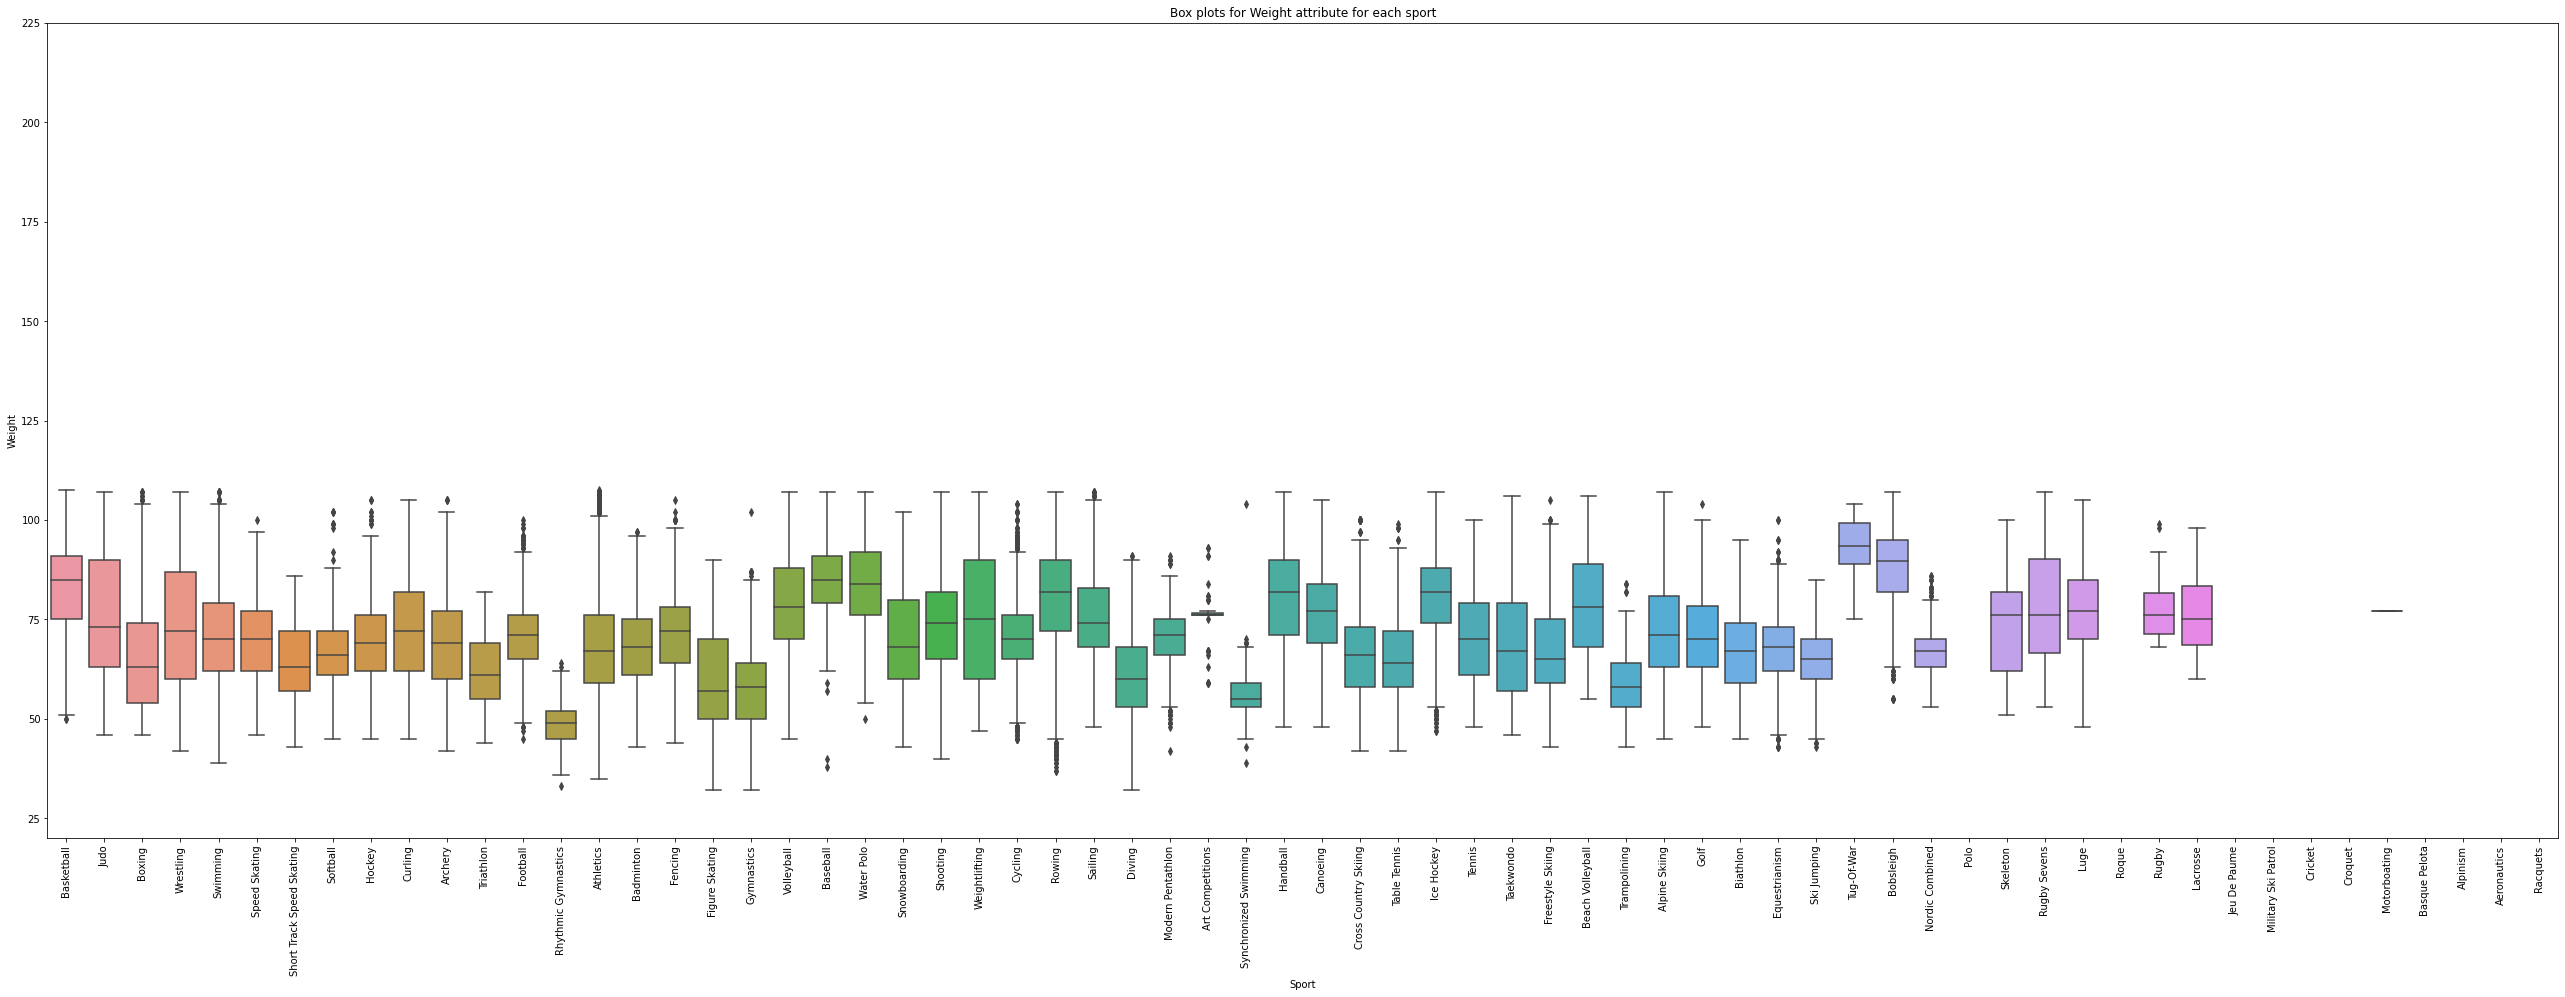

In [114]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Weight')

averageAge = round(df_olympics['Weight'].mean())

plt.ylim(20, 225)
plt.xticks(rotation=90)
plt.title('Box plots for Weight attribute for each sport');

#### **Handling HEIGHT outliers**

**BEFORE handling height outliers**

In [115]:
df_olympics.describe()

ID            Age  ...         Weight           Year
count  270767.000000  261305.000000  ...  207980.000000  270767.000000
mean    68229.276832      25.360579  ...      70.310558    1978.362297
std     39017.998824       6.088544  ...      13.201366      29.884637
min         1.000000      10.000000  ...      32.000000    1896.000000
25%     34630.500000      21.000000  ...      60.000000    1960.000000
50%     68187.000000      24.000000  ...      70.000000    1988.000000
75%    102065.500000      28.000000  ...      79.000000    2002.000000
max    135571.000000      77.000000  ...     107.500000    2016.000000

[8 rows x 5 columns]

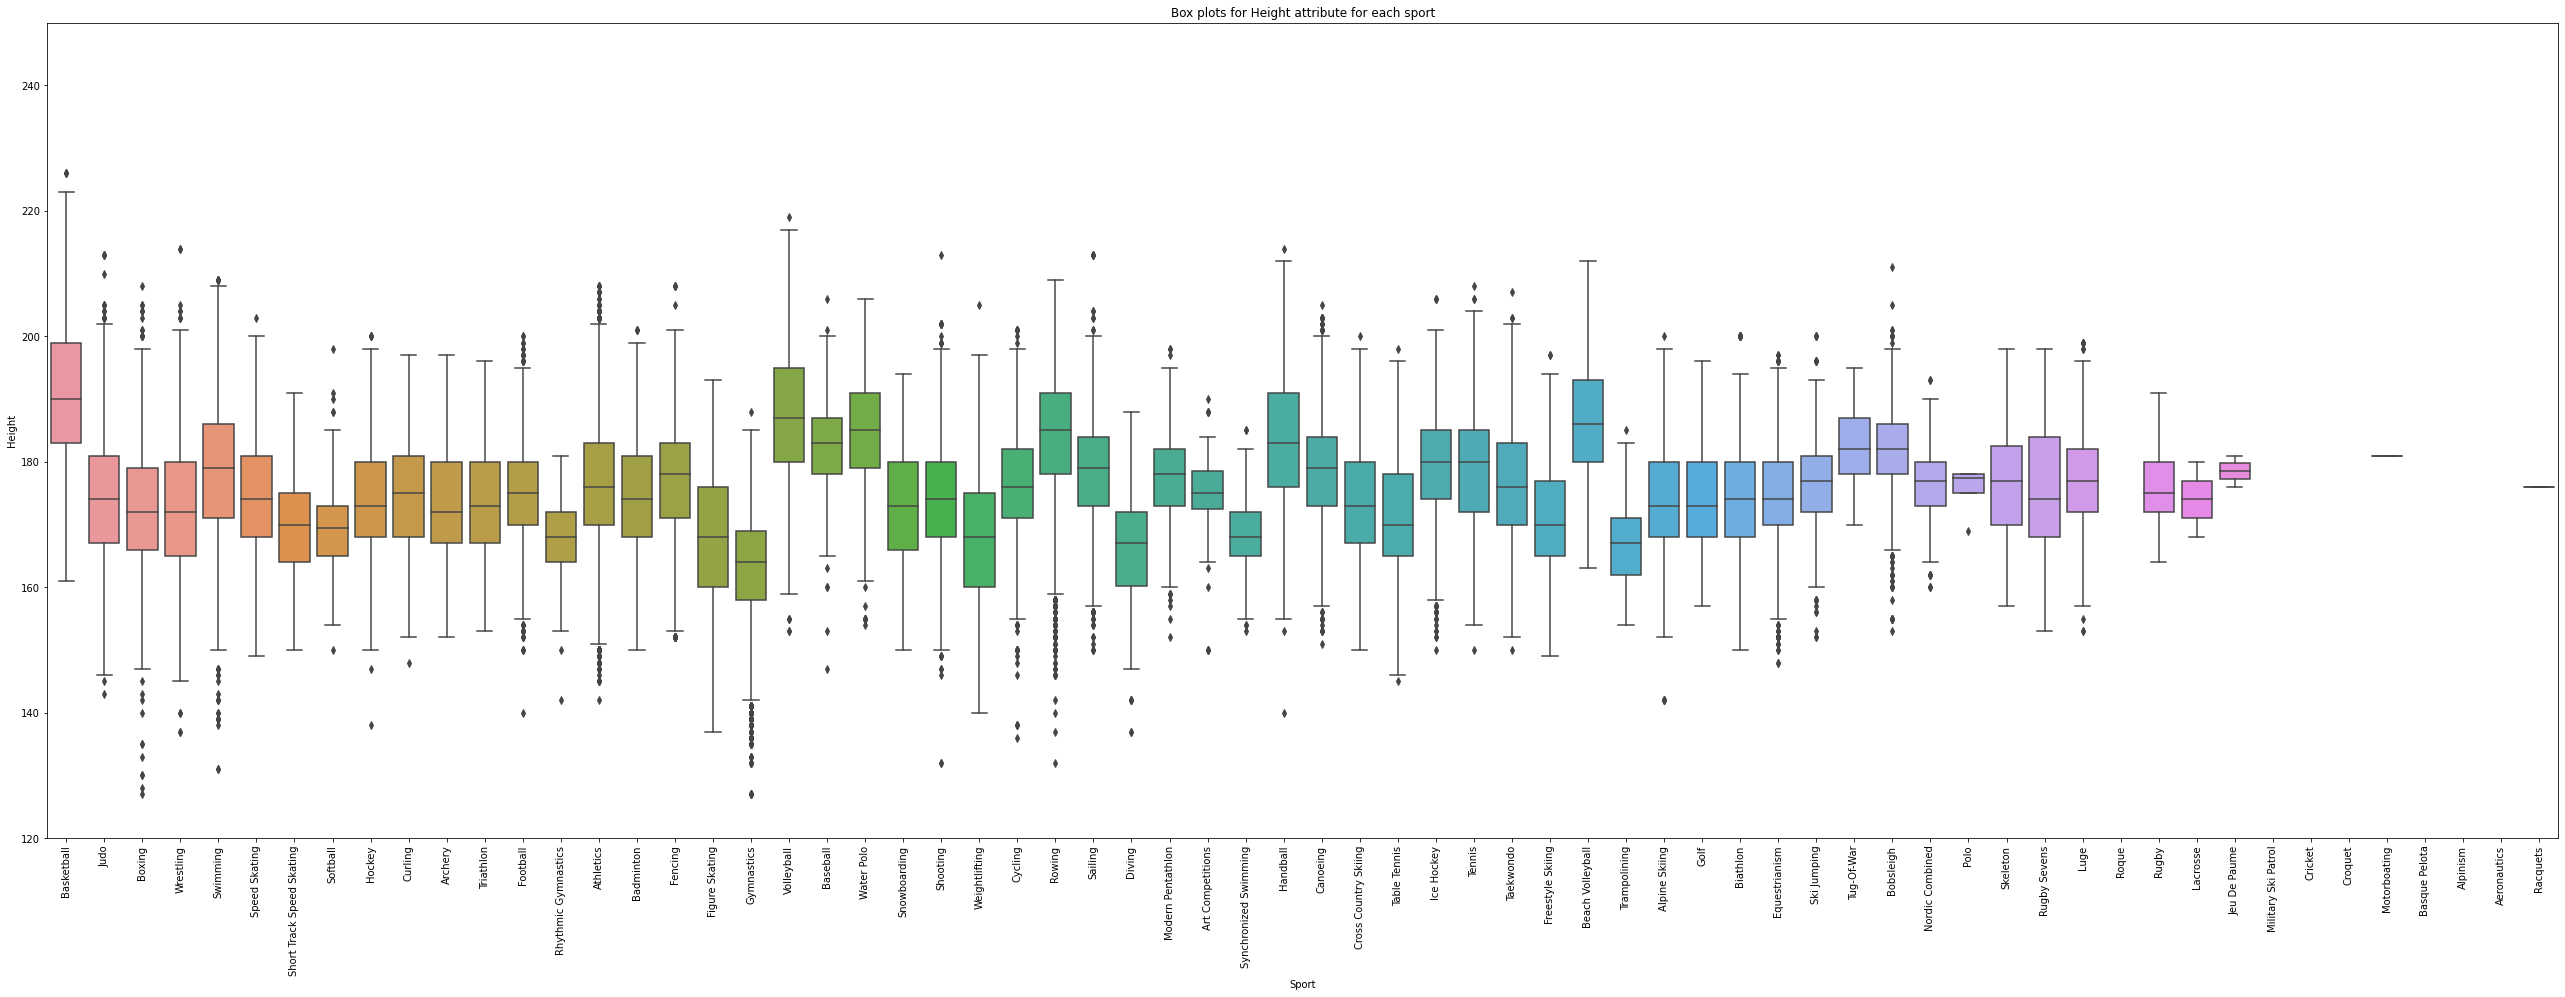

In [116]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Height')

averageAge = round(df_olympics['Height'].mean())
plt.ylim(120, 250)
plt.xticks(rotation=90)
plt.title('Box plots for Height attribute for each sport');

 Similar to the weight, we handled outliers first separating by gender for each sport, but first by filtering the events that have no weights first then looping on the sports, and using inter-quartile range to calculate the average of the values which aren't outliers, then assigning this value to the outliers. In other words, this means that w replaced outliers with the mean per sport and gender.

In [117]:
Sports = df_olympics["Sport"].unique()
def RemovingHeightOutliersPerGender(gender):
    sportsWithEmptyHeight = np.array([])
    for sport in Sports:
        temp = df_olympics[(df_olympics.Sex==gender) & (df_olympics.Sport==sport)]
        if temp.shape[0] == temp['Height'].isna().sum():
            sportsWithEmptyHeight = np.append(sportsWithEmptyHeight, [sport]) 
    validSports = df_olympics['Sport'].unique()
    validSports = np.setdiff1d(validSports, sportsWithEmptyHeight)
    sum = 0
    sum1 = 0 
    for sport in validSports:
        Q1 = df_olympics["Height"].quantile(0.25)
        Q3 = df_olympics["Height"].quantile(0.75)
        IQR = Q3 - Q1
        cut_off = IQR * 1.5
        lower = Q1 - cut_off
        upper =  Q3 + cut_off
        df1 = df_olympics[(df_olympics["Height"]> upper) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport)]
        df2 = df_olympics[(df_olympics["Height"] < lower) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport)]
        df = df_olympics[(df_olympics["Height"] >= lower) & (df_olympics["Height"] <= upper) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport)]
        mean = df["Height"].mean()
        df_olympics["Height"].mask(((df_olympics["Height"] < lower) | (df_olympics["Height"] > upper)) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport), mean, inplace = True)


In [118]:
RemovingHeightOutliersPerGender('F')
RemovingHeightOutliersPerGender('M')

**AFTER handling HEIGHT outliers**

In [119]:
df_olympics.describe()

ID            Age  ...         Weight           Year
count  270767.000000  261305.000000  ...  207980.000000  270767.000000
mean    68229.276832      25.360579  ...      70.310558    1978.362297
std     39017.998824       6.088544  ...      13.201366      29.884637
min         1.000000      10.000000  ...      32.000000    1896.000000
25%     34630.500000      21.000000  ...      60.000000    1960.000000
50%     68187.000000      24.000000  ...      70.000000    1988.000000
75%    102065.500000      28.000000  ...      79.000000    2002.000000
max    135571.000000      77.000000  ...     107.500000    2016.000000

[8 rows x 5 columns]

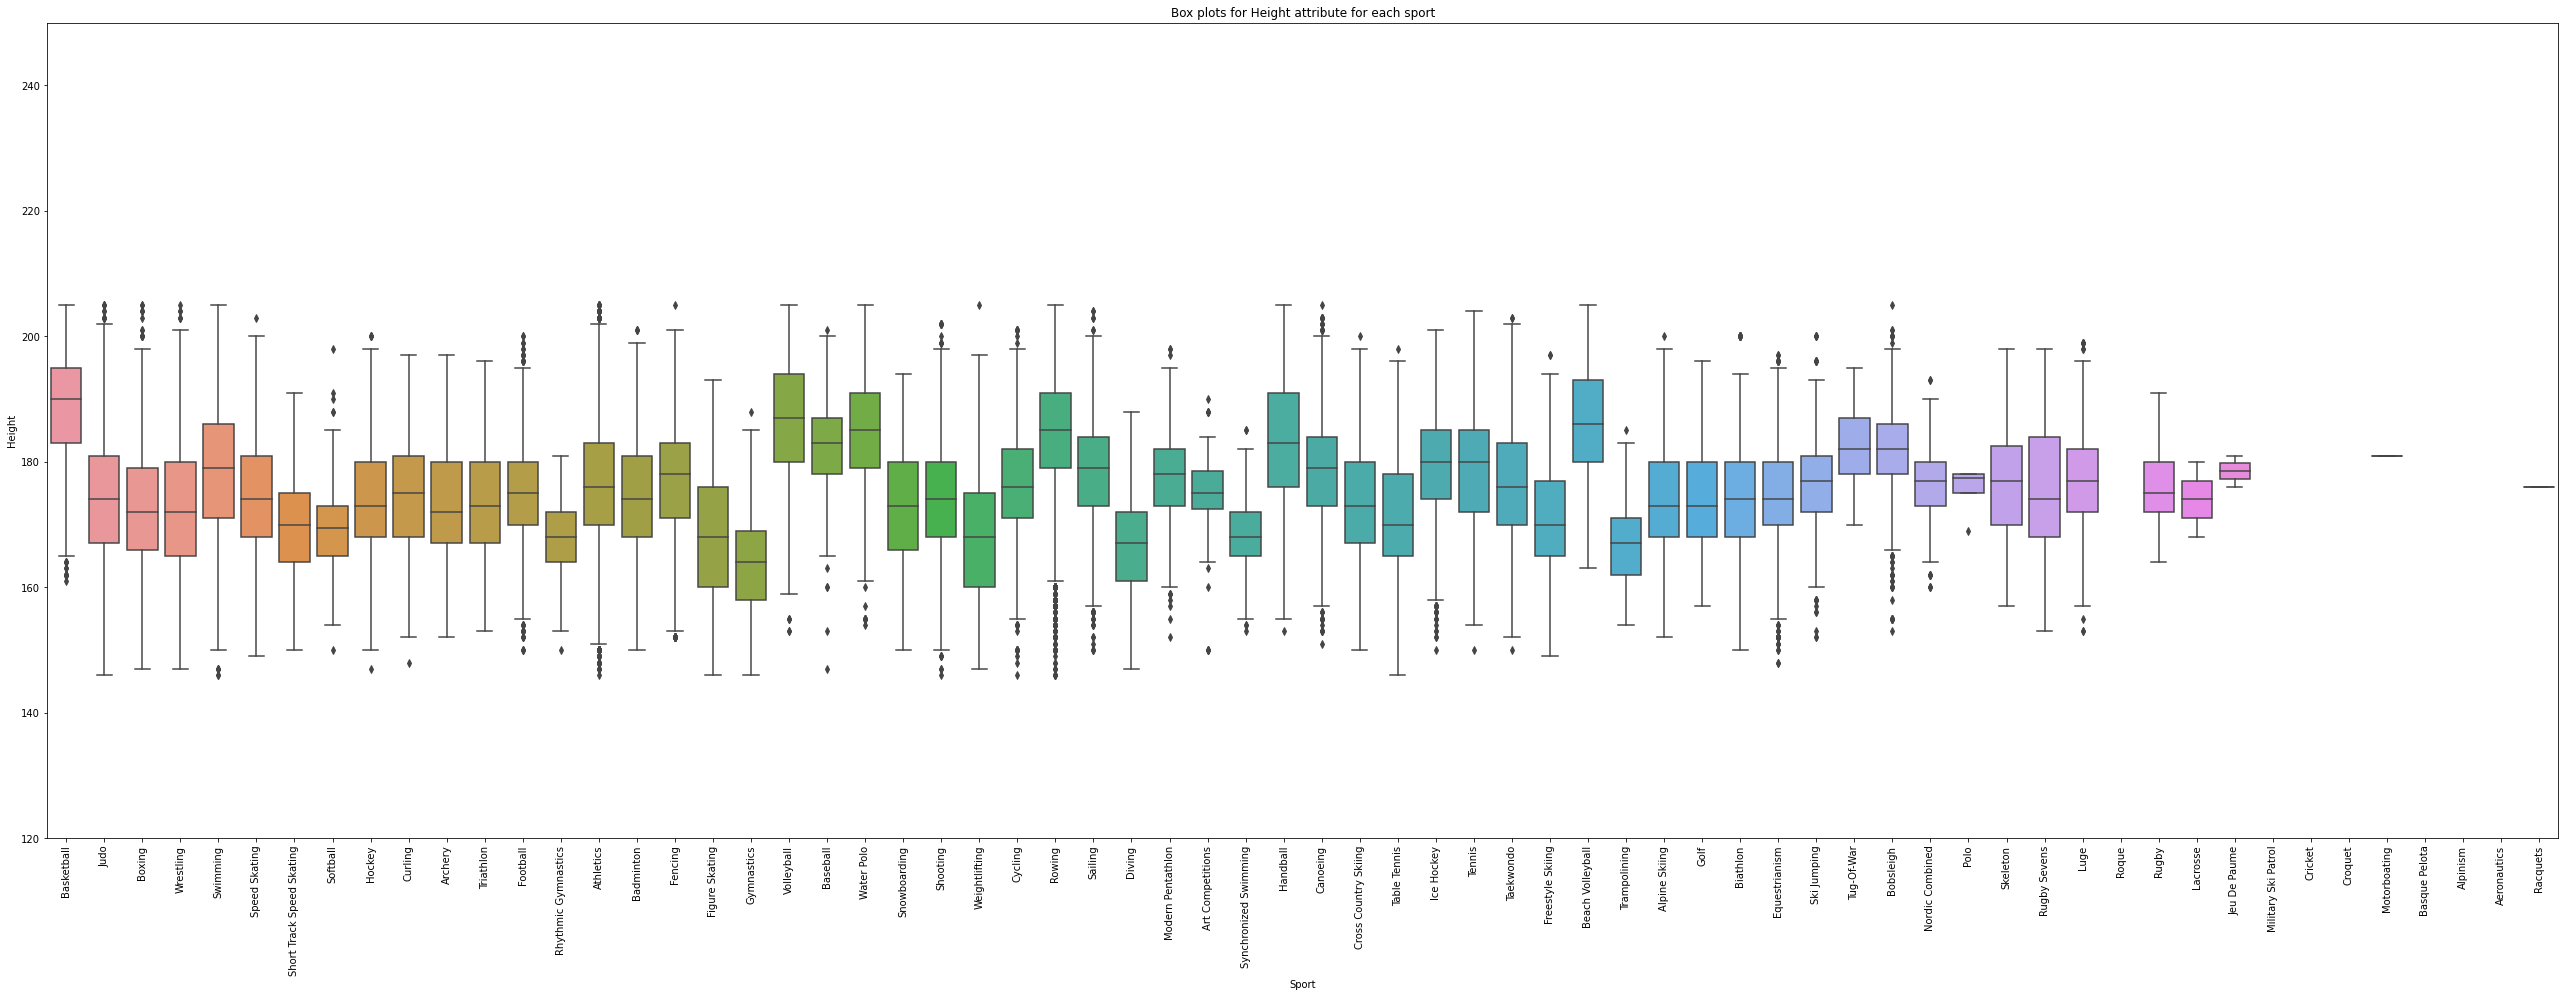

In [120]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Height')

averageAge = round(df_olympics['Height'].mean())
plt.ylim(120, 250)
plt.xticks(rotation=90)
plt.title('Box plots for Height attribute for each sport');

# **MISSING VALUES**

Number of missing values per each attribute

In [121]:
# unifying missing values and calculating number of missing values per each row 
df_olympics.replace('NA', np.nan, inplace=True)
df_olympics.replace('Missing', np.nan, inplace=True)

df_olympics.isna().sum()

ID             0
Name           0
Sex            0
Age         9462
Height     60083
Weight     62787
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     230993
region        21
notes     265728
dtype: int64

Dropping duplicate rows 


In [122]:
#Found 1385 duplicated items
duplicateData = df_olympics[df_olympics.duplicated(keep='last')].sort_values(by=['Name'], ascending=True)
duplicateIndexes = duplicateData.index
df_olympics = df_olympics.drop(duplicateIndexes)

In [123]:
# number of rows with Age, Height, Weight together are NaN --> 3%
df_nulls = df_olympics[df_olympics['Age'].isna() & df_olympics['Height'].isna() & df_olympics['Weight'].isna()]
len(df_nulls)

8260

The distribution of the height and weight per gender, to find what is the best way for filling missing values in height and weight attributes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f47fd724150>,
      dtype=object)

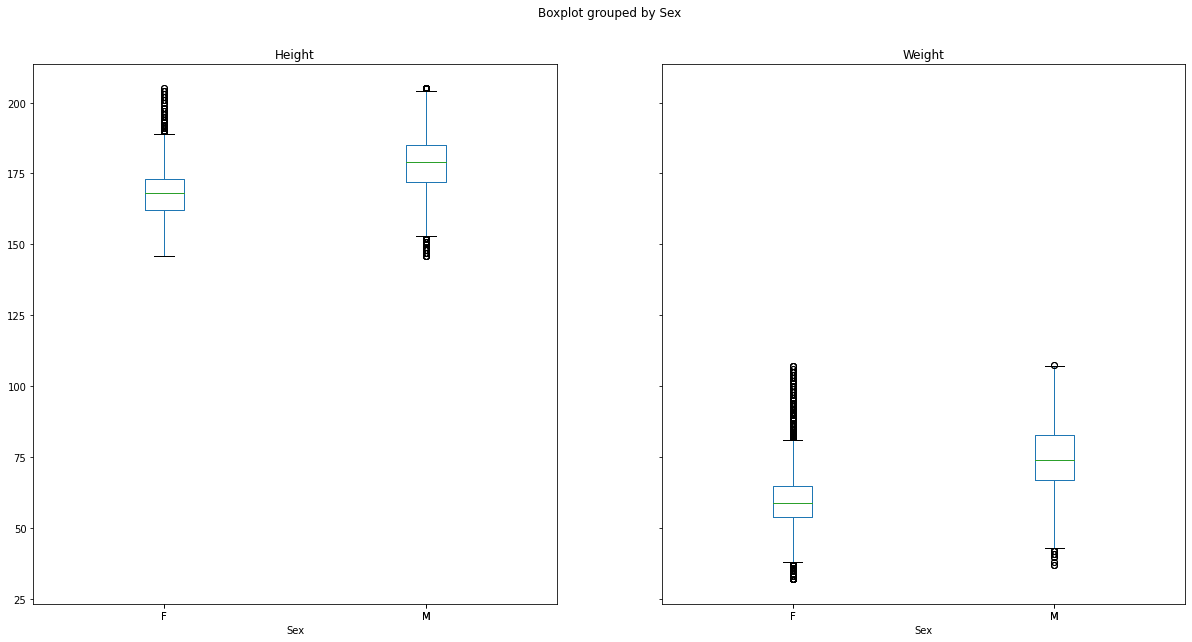

In [124]:
df_olympics.boxplot(by ='Sex', column =['Height', 'Weight'], grid = False, figsize=(20,10))

Remove column notes as it is not needed and full of NANs


In [125]:
df_olympics.drop(['notes'], axis=1, inplace=True)

Figured out that three NOC had no corresponding regions

In [126]:
NOCwithNoRegion = df_olympics[df_olympics['region'].isnull()]
NOCwithNoRegion['NOC'].unique()

# ROT --> Refugee Olympic Team
# UNK -->
# TUV --> Tuvalu

# len(NOCwithNoRegion[NOCwithNoRegion['NOC'] == 'UNK'])

array(['ROT', 'TUV', 'UNK'], dtype=object)

**Handling missing Regions values**
\
Regions were filled according to their corresponding NOC and the unfigured or unknown regions were dropped --> 2 rows only so will not affect our data



In [127]:
# df_olympics['Age'] = df_olympics['Age'].astype(np.float64)

df_olympics['region'].loc[(df_olympics['NOC'] == 'ROT')] = 'Refugee Olympic Team'
df_olympics['region'].loc[(df_olympics['NOC'] == 'TUV')] = 'Tuvalu'

df_olympics.dropna(axis='index', subset=['region'], inplace=True)

**Handling missing age values**
\
We imputed missing age values by the mean value per sport

In [128]:
# Filling missing values 

In [129]:
def impute_age_missing_values(athletes_df):
    athletes_df_no_missing_age_values_df = pd.DataFrame()
    olympics_sports = athletes_df.Sport.unique()
    for s in olympics_sports:
        sport_df = athletes_df[athletes_df.Sport == s]
        sport_df.Age.fillna(sport_df.Age.mean() ,inplace=True)
        athletes_df_no_missing_age_values_df = athletes_df_no_missing_age_values_df.append(sport_df)
    return athletes_df_no_missing_age_values_df

In [130]:
# #replace AGE empty values with Sport age average 

avgAges = df_olympics.groupby(['Sport'])["Age"].mean()
df_olympics['Age'].fillna(df_olympics['Sport'].map(avgAges), inplace=True )


# #All ages for CRT is NAN --> hence added the mean for all 
# df_olympics['Age'].fillna(value=df_olympics['Age'].mean() , inplace=True )

# df_olympics = impute_age_missing_values(df_olympics)

In [131]:
df_olympics.isna().sum()

ID             0
Name           0
Sex            0
Age            0
Height     58724
Weight     61437
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     229617
region         0
dtype: int64

In [132]:
# df_olympics.describe()
df_olympics.head()

ID           Name Sex  ...                          Event   Medal  region
0        1      A Dijiang   M  ...    Basketball Men's Basketball     NaN   China
17    6381         Ba Yan   F  ...  Basketball Women's Basketball  Bronze   China
48   11239       Bian Lan   F  ...  Basketball Women's Basketball     NaN   China
49   11239       Bian Lan   F  ...  Basketball Women's Basketball     NaN   China
167  20211  Chen Jianghua   M  ...    Basketball Men's Basketball     NaN   China

[5 rows x 16 columns]

**Handling missing weight values**
\
We imputed missing weight values by the mean value per event and gender, because events participations have a standard weight. The remaining ones are handled by filtering over sport and gender. Then the remaining ones are handled by gender only.

In [133]:
# 1- Mean by gender and event
# 2- Mean by gender and sport
# 3- Mean by gender

malesData = df_olympics[df_olympics['Sex'] == 'M']
femalesData = df_olympics[df_olympics['Sex'] == 'F']

averageMaleWeightPerEvent = malesData.groupby(['Event'])["Weight"].mean()
malesData['Weight'].fillna(malesData['Event'].map(averageMaleWeightPerEvent), inplace=True )

averageFemaleWeightPerEvent = femalesData.groupby(['Event'])["Weight"].mean()
femalesData['Weight'].fillna(femalesData['Event'].map(averageFemaleWeightPerEvent), inplace=True )


averageMaleWeightPerSport = malesData.groupby(['Sport'])["Weight"].mean()
malesData['Weight'].fillna(malesData['Sport'].map(averageMaleWeightPerSport), inplace=True )

averageFemaleWeightPerSport = femalesData.groupby(['Sport'])["Weight"].mean()
femalesData['Weight'].fillna(femalesData['Sport'].map(averageFemaleWeightPerSport), inplace=True )


frames = [malesData, femalesData]

df_olympics = pd.concat(frames)

averageWeightPerGender = df_olympics.groupby(['Sex'])["Weight"].mean()
df_olympics['Weight'].fillna(df_olympics['Sex'].map(averageWeightPerGender), inplace=True )


**Handling missing height values**
\
We imputed missing height values by the mean value per sport and gender. Then the remaining ones are done by gender only.

In [134]:
# 1- Mean by gender and sport
# 2- Mean by gender

malesData = df_olympics[df_olympics['Sex'] == 'M']
femalesData = df_olympics[df_olympics['Sex'] == 'F']

averageMaleHeightPerSport = malesData.groupby(['Sport'])["Height"].mean()
malesData['Height'].fillna(malesData['Sport'].map(averageMaleHeightPerSport), inplace=True )

averageFemaleHeightPerSport = femalesData.groupby(['Sport'])["Height"].mean()
femalesData['Height'].fillna(femalesData['Sport'].map(averageFemaleHeightPerSport), inplace=True )


frames = [malesData, femalesData]

df_olympics = pd.concat(frames)

averageHeightPerGender = df_olympics.groupby(['Sex'])["Height"].mean()
df_olympics['Height'].fillna(df_olympics['Sex'].map(averageHeightPerGender), inplace=True )

In [135]:
# number of missing vlaues left after filling them
df_olympics.isna().sum()

ID             0
Name           0
Sex            0
Age            0
Height         0
Weight         0
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     229617
region         0
dtype: int64

#**INCONSISTENCIES**

**Multiple NOCs belong to the same region** --> 
Decided to work with regions




In [136]:
#multiple NOCs belong to the same region
df_regions.region.value_counts()

Germany        4
Russia         3
Malaysia       3
Yemen          3
Serbia         3
              ..
Dominica       1
Sweden         1
Maldives       1
Afghanistan    1
San Marino     1
Name: region, Length: 206, dtype: int64

**Cities with multiple spellings**

In [137]:
print(df_olympics['City'].unique())
print(len(df_olympics['City'].unique()))

['Barcelona' 'Beijing' 'London' 'Athina' 'Rio de Janeiro' 'Berlin' 'Seoul'
 'Atlanta' 'Sydney' 'Los Angeles' 'Montreal' 'Roma' 'Munich' 'Tokyo'
 'Mexico City' 'Helsinki' 'Melbourne' 'Moskva' 'Antwerpen' 'Amsterdam'
 'Paris' 'St. Louis' 'Stockholm' 'Torino' 'Sochi' 'Sarajevo' 'Nagano'
 'Albertville' 'Vancouver' 'Lake Placid' 'Salt Lake City' 'Lillehammer'
 'Calgary' 'Sankt Moritz' 'Squaw Valley' 'Innsbruck'
 'Garmisch-Partenkirchen' 'Grenoble' 'Sapporo' 'Oslo' "Cortina d'Ampezzo"
 'Chamonix']
42


In [138]:
# Fixing spellings
df_olympics['City'].replace('Athina','Athens',inplace=True)
df_olympics['City'].replace('Moskva','Moscow',inplace=True)

print(df_olympics['City'].unique())
print(len(df_olympics['City'].unique()))

['Barcelona' 'Beijing' 'London' 'Athens' 'Rio de Janeiro' 'Berlin' 'Seoul'
 'Atlanta' 'Sydney' 'Los Angeles' 'Montreal' 'Roma' 'Munich' 'Tokyo'
 'Mexico City' 'Helsinki' 'Melbourne' 'Moscow' 'Antwerpen' 'Amsterdam'
 'Paris' 'St. Louis' 'Stockholm' 'Torino' 'Sochi' 'Sarajevo' 'Nagano'
 'Albertville' 'Vancouver' 'Lake Placid' 'Salt Lake City' 'Lillehammer'
 'Calgary' 'Sankt Moritz' 'Squaw Valley' 'Innsbruck'
 'Garmisch-Partenkirchen' 'Grenoble' 'Sapporo' 'Oslo' "Cortina d'Ampezzo"
 'Chamonix']
42


#**ENCODING**


In [139]:
df_olympics.head()

ID             Name Sex  ...                        Event  Medal  region
0        1        A Dijiang   M  ...  Basketball Men's Basketball    NaN   China
167  20211    Chen Jianghua   M  ...  Basketball Men's Basketball    NaN   China
168  20211    Chen Jianghua   M  ...  Basketball Men's Basketball    NaN   China
191  20225          Chen Ke   M  ...  Basketball Men's Basketball    NaN   China
372  20615  Chia Chungchang   M  ...  Basketball Men's Basketball    NaN   China

[5 rows x 16 columns]

In [140]:
medals = [] # define array structure
for medal in df_olympics["Medal"]:
    if medal == 'Gold':
        medals.append(3)
    elif medal == 'Silver':
        medals.append(2)
    elif medal == 'Bronze':
        medals.append(1)
    else:
        medals.append(0)
        
# Copy dataframe to keep original 
df_olympics["Medal_Enumarated"] = medals
del df_olympics["Medal"]

In [141]:
df_olympics.head(20)

ID             Name  ... region  Medal_Enumarated
0        1        A Dijiang  ...  China                 0
167  20211    Chen Jianghua  ...  China                 0
168  20211    Chen Jianghua  ...  China                 0
191  20225          Chen Ke  ...  China                 0
372  20615  Chia Chungchang  ...  China                 0
383  21366      Chua Bonhua  ...  China                 0
456  28660      Ding Jinhui  ...  China                 0
463  28664   Ding Yanyuhang  ...  China                 0
499  30177          Du Feng  ...  China                 0
500  30177          Du Feng  ...  China                 0
583  34615     Feng Niehhwa  ...  China                 0
711  41421      Gong Luming  ...  China                 0
715  41426     Gong Xiaobin  ...  China                 0
716  41426     Gong Xiaobin  ...  China                 0
745  43951        Guo Ailun  ...  China                 0
746  43951        Guo Ailun  ...  China                 0
798  43976     Guo Shiqiang  ...  China                 0
799  43976     Guo Shiqiang  ...  China                 0
960  50529    Hsu Chaohsung  ...  China                 0
986  50576       Hu Weidong  ...  China                 0

[20 rows x 16 columns]

#**VISUALISING**

In [142]:
plt.rcParams["axes.labelweight"] = "regular"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["font.weight"] = "regular"
plt.rcParams["font.size"] = 12

In [143]:
len(df_olympics['Event'].unique())

df_olympics.head()

ID             Name  ... region  Medal_Enumarated
0        1        A Dijiang  ...  China                 0
167  20211    Chen Jianghua  ...  China                 0
168  20211    Chen Jianghua  ...  China                 0
191  20225          Chen Ke  ...  China                 0
372  20615  Chia Chungchang  ...  China                 0

[5 rows x 16 columns]

Text(0.5, 1, 'Scatterplot matrix showing correlation between the 3 quantitative attributes')

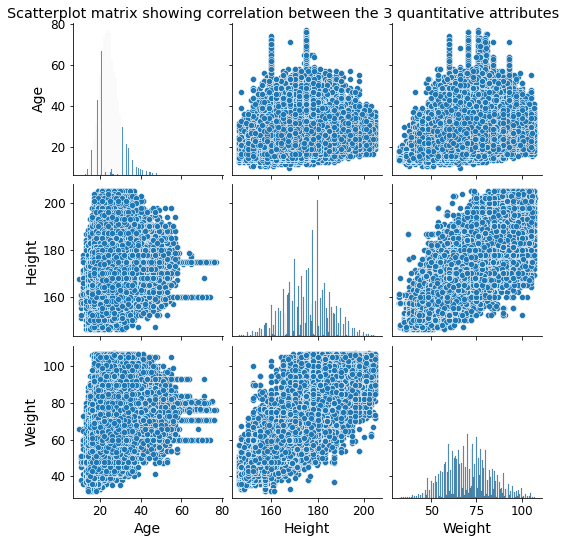

In [144]:
# plt.figure(figsize=(10,10))
g= sns.pairplot(df_olympics[['Age','Height','Weight']])
# plt.title('Scatterplot matrix showing correlation between the 3 quantitative attributes', y=10)
g.fig.suptitle("Scatterplot matrix showing correlation between the 3 quantitative attributes", y =1)

**Performance of female participants versus male participants**


**Ages of participants**

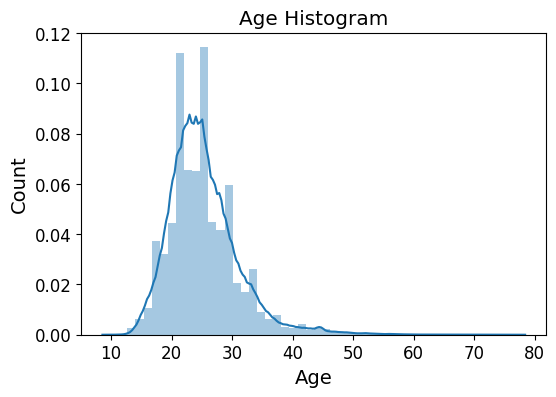

In [145]:
#plot a histogram of age 
bins = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Age Histogram')
axs_1.set_xlabel('Age')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) 
axs_1.set_ylabel('Count')
sns.distplot(df_olympics['Age'])

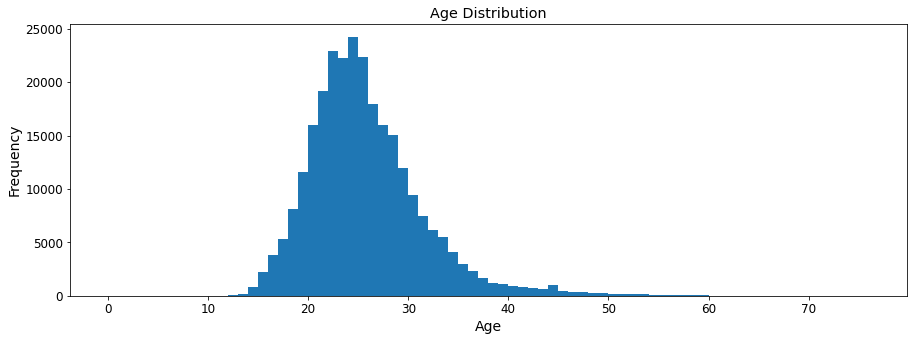

In [146]:
#getting the frequency of the ages (age by age)
plt.figure(figsize=(15,5))
bins = np.arange(0,df_olympics.Age.max())
plt.hist(data=df_olympics, x='Age',bins=bins);
plt.xticks(np.arange(0,df_olympics['Age'].max(),10));
plt.title('Age Distribution');
plt.ylabel('Frequency');
plt.xlabel('Age');

**Weight distribution**

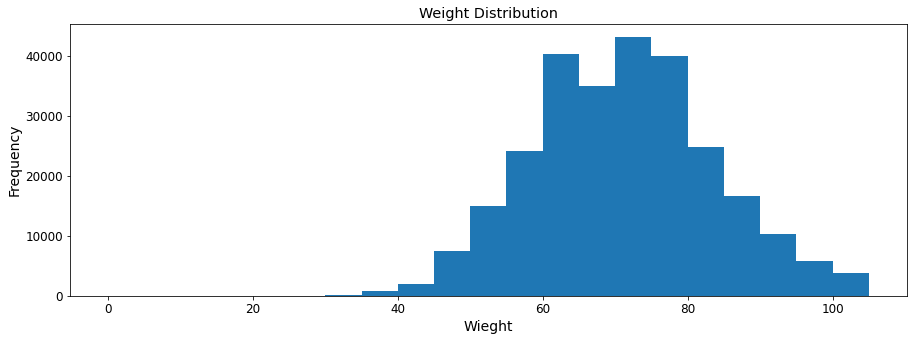

In [147]:
#getting the frequency of the ages (age by age)
plt.figure(figsize=(15,5))
bins = np.arange(0,df_olympics.Weight.max(),5)
plt.hist(data=df_olympics, x='Weight',bins=bins);
# plt.xticks(np.arange(df_olympics['Weight'].min(),df_olympics['Weight'].max(),10));
plt.title('Weight Distribution');
plt.ylabel('Frequency');
plt.xlabel('Wieght');

**Height distribution**

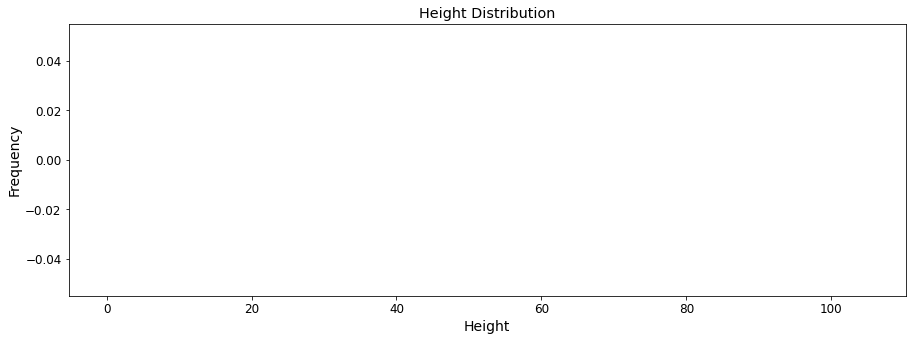

In [148]:
#getting the frequency of the heights
plt.figure(figsize=(15,5))
bins = np.arange(0,df_olympics.Weight.max(),5)
plt.hist(data=df_olympics, x='Height',bins=bins);
# plt.xticks(np.arange(df_olympics['Height'].min(),df_olympics['Height'].max(),10));
plt.title('Height Distribution');
plt.ylabel('Frequency');
plt.xlabel('Height');

**Frequency of players per season over the years**

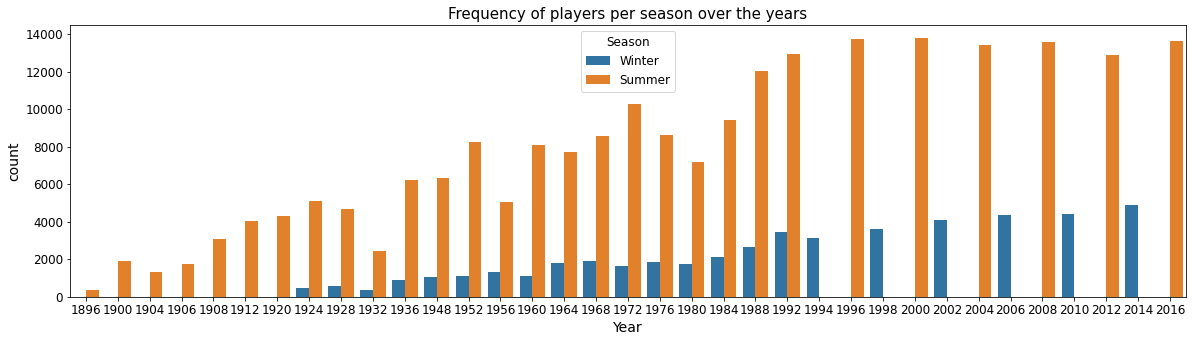

In [149]:
plt.figure(figsize=(20,5))
plt.title('Frequency of players per season over the years', fontsize=15)
sns.countplot(data=df_olympics,x="Year",hue='Season',hue_order=['Winter','Summer'] )

In [150]:
df_olympics.head(5)

ID             Name  ... region  Medal_Enumarated
0        1        A Dijiang  ...  China                 0
167  20211    Chen Jianghua  ...  China                 0
168  20211    Chen Jianghua  ...  China                 0
191  20225          Chen Ke  ...  China                 0
372  20615  Chia Chungchang  ...  China                 0

[5 rows x 16 columns]

Text(0.5, 3.200000000000003, 'Sport')

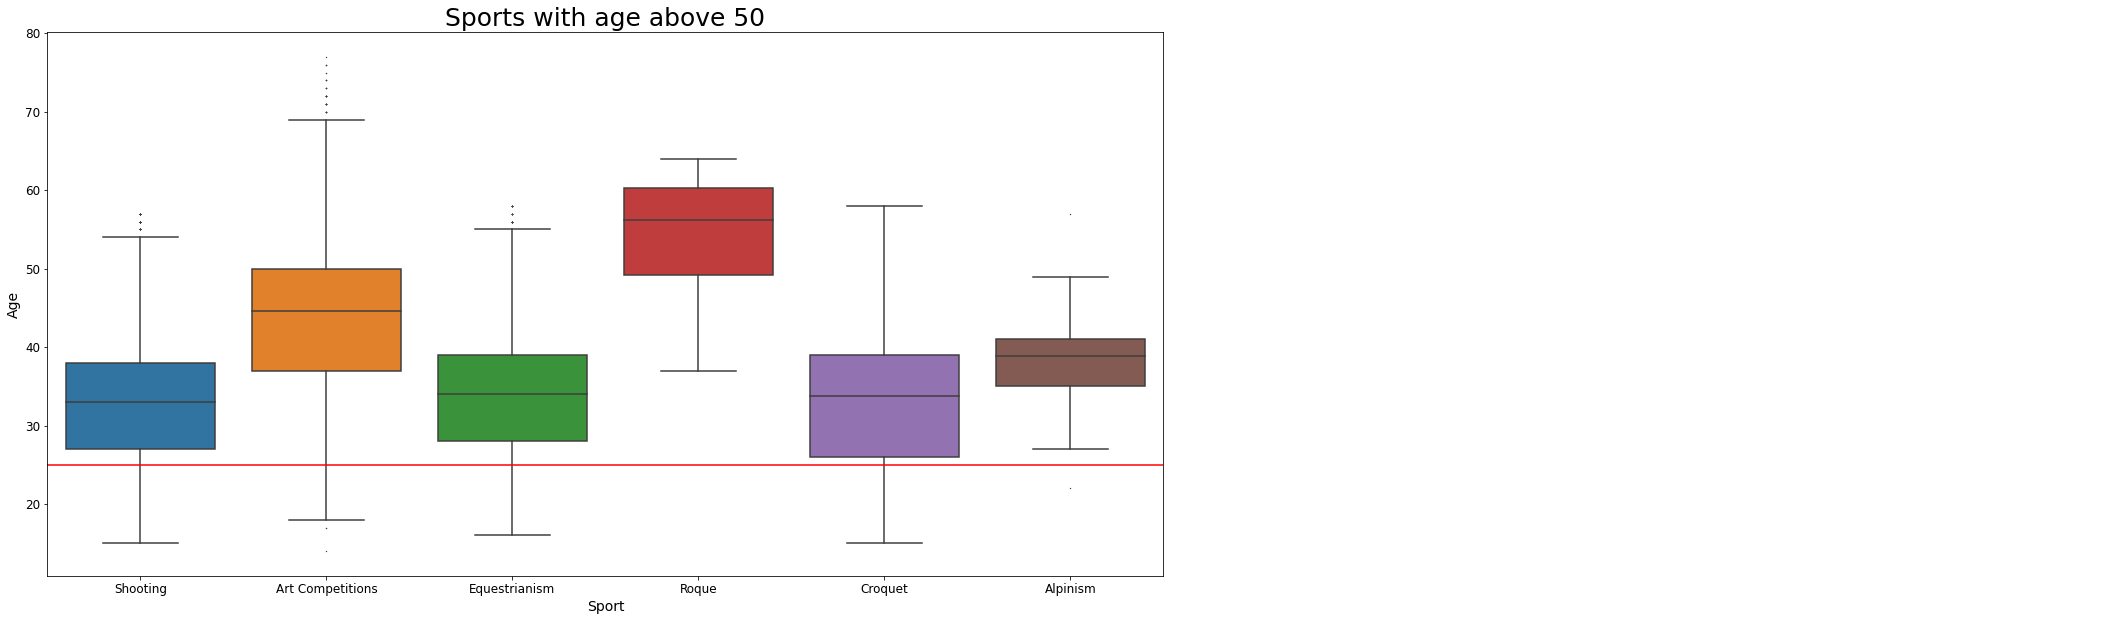

In [151]:
sportsForElders = df_olympics[df_olympics.Age>50].Sport.unique()
plt.figure(figsize=(20,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(sportsForElders)],x='Sport',y='Age',fliersize=1/2)

averageAge = round(df_olympics['Age'].mean())

plt.axhline(averageAge,color='red',linestyle='-')
bbox_props = dict(boxstyle="round,pad=0.75", fc="white", ec="black", lw=2)
plt.annotate('Average Age = '+str(averageAge),(10,averageAge+1),bbox=bbox_props)
plt.title('Sports with age above 50', fontsize=25)
ax.set_ylabel("Age",fontsize=35 )
ax.set_xlabel("Sport",fontsize=35 )

**Top cities hosting the Olympics**

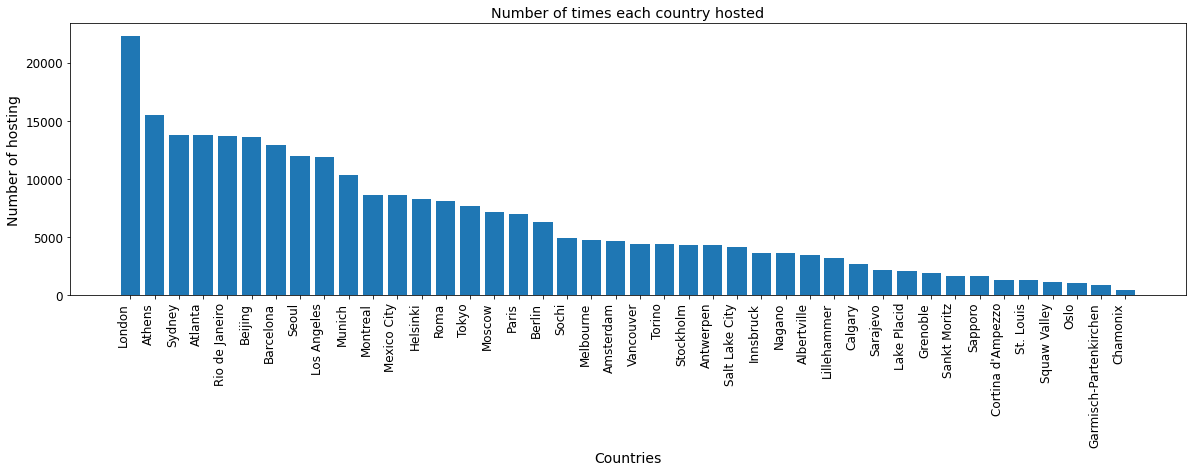

In [152]:
top_hosting_cities_df = df_olympics.groupby(['City'])['ID'].count().sort_values(ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
ax.bar(top_hosting_cities_df.index, top_hosting_cities_df)
ax.set_xticklabels(top_hosting_cities_df.index, rotation=90, ha='right')
ax.set_title('Number of times each country hosted')
ax.set_xlabel('Countries')
ax.set_ylabel('Number of hosting');

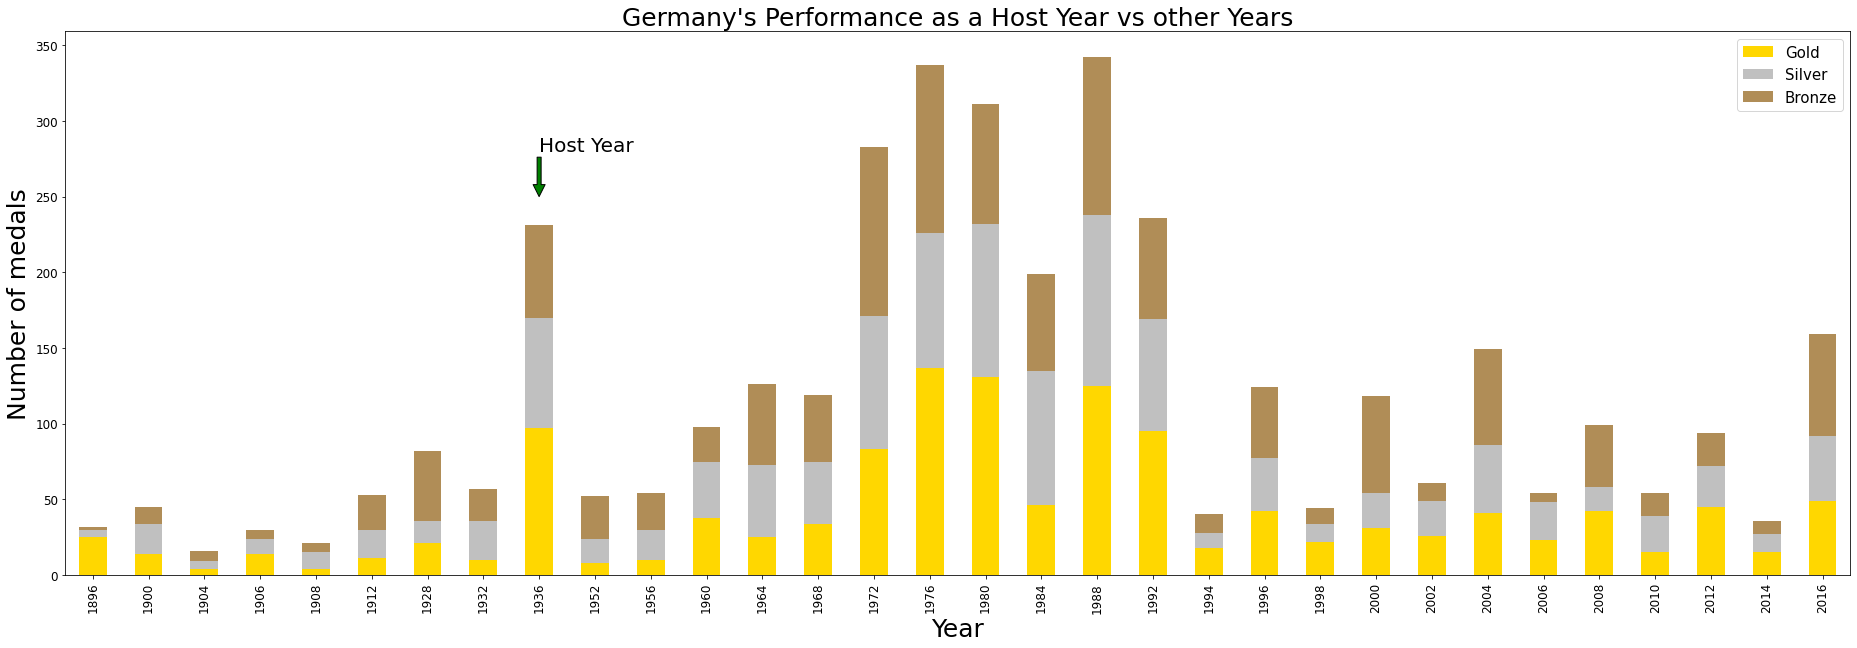

In [153]:
#Difference in Germany Performance in the Host Year vs other Years

RegionGroupData=df_olympics.groupby('region')
  
df_Germany = pd.DataFrame(columns = ['Year', 'Gold', 'Silver' , 'Bronze'])
df_Russia = pd.DataFrame(columns = ['Year', 'Gold', 'Silver' , 'Bronze'])
#df_TOPTWO= pd.DataFrame(columns = ['Year', 'GoldUS', 'SilverUS' , 'BronzeUS', 'GoldRuss', 'SilverRuss' , 'BronzeRuss'])
for i,j in RegionGroupData:
    
    if i=="Germany":
        x=j.groupby("Year")
        for k , l in x:
            Gold,Silver, Bronze =0,0,0 
            Gold = len(l[ l['Medal_Enumarated']==3])
            Silver =len(l[ l['Medal_Enumarated']==2])
            Bronze =len(l[ l['Medal_Enumarated']==1]) 
            new_row={'Year': k , "Gold": Gold, "Silver": Silver , "Bronze": Bronze}  
            df_Germany =  df_Germany.append(new_row, ignore_index=True) 


df=df_olympics[df_olympics['City']=="Berlin"] 
x=df.groupby(["Year"]) 
HostYear=0
for k , j in x:
    HostYear=k
HostYearindex=df_Germany.index[df_Germany['Year']==HostYear].tolist()[0]

# df_Germany.head()

fig, ax = plt.subplots()
   
df_Germany.plot(x='Year', kind='bar', stacked=True
         , color=['#FFD700', '#c0c0c0', '#b08d57']  ,ax=ax  , figsize= (32, 10))
ax.annotate('Host Year', fontsize=20, xy =(HostYearindex,250),
             xytext =(HostYearindex, 280),
             arrowprops = dict(facecolor ='green',
                shrink=2           ))

ax.set_title("Germany's Performance as a Host Year vs other Years" , fontsize=25)
ax.set_ylabel("Number of medals",fontsize=25 )
ax.set_xlabel("Year",fontsize=25 )
ax.legend(['Gold', 'Silver', 'Bronze'], fontsize=15)


In [154]:
df_olympics.head()

ID             Name  ... region  Medal_Enumarated
0        1        A Dijiang  ...  China                 0
167  20211    Chen Jianghua  ...  China                 0
168  20211    Chen Jianghua  ...  China                 0
191  20225          Chen Ke  ...  China                 0
372  20615  Chia Chungchang  ...  China                 0

[5 rows x 16 columns]

In [155]:
athletes_winter_df.head()
athletes_winter_df.groupby(['NOC'])['Medal']

Text(0.5, 0.98, 'Top 10 countries in each season versus all')

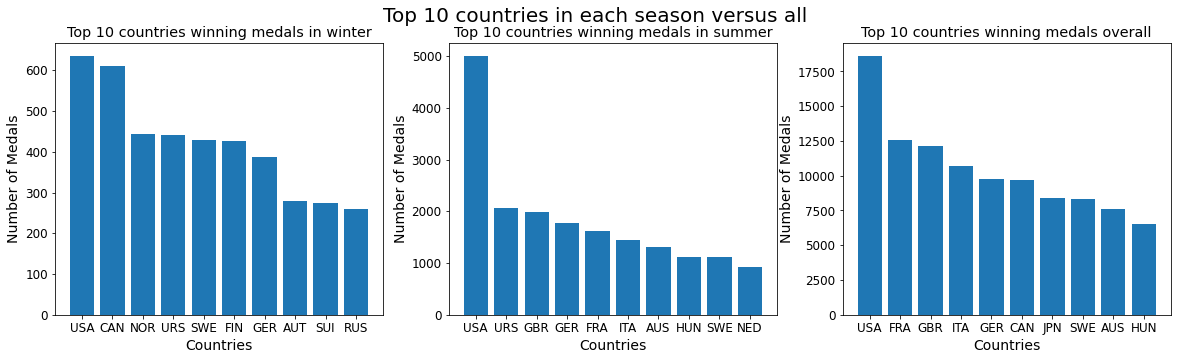

In [156]:
top_countries_with_medals_winter = athletes_winter_df.groupby(['NOC'])['Medal'].count().sort_values(ascending=False)
top_countries_with_medals_summer = athletes_summer_df.groupby(['NOC'])['Medal'].count().sort_values(ascending=False)
countries_medals_count = df_olympics.groupby(['NOC'])['Medal_Enumarated'].count().sort_values(ascending=False)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax1.bar(top_countries_with_medals_winter[:10].index, height=top_countries_with_medals_winter[:10])
ax1.set_xlabel('Countries')
ax1.set_ylabel('Number of Medals');
ax1.set_title('Top 10 countries winning medals in winter')

ax2.bar(top_countries_with_medals_summer[:10].index, height=top_countries_with_medals_summer[:10])
ax2.set_xlabel('Countries')
ax2.set_ylabel('Number of Medals');
ax2.set_title('Top 10 countries winning medals in summer')

ax3.bar(countries_medals_count[:10].index, height=countries_medals_count[:10])
ax3.set_xlabel('Countries')
ax3.set_ylabel('Number of Medals');
ax3.set_title('Top 10 countries winning medals overall')
fig.suptitle('Top 10 countries in each season versus all', fontsize=20)

**Top Athletes**

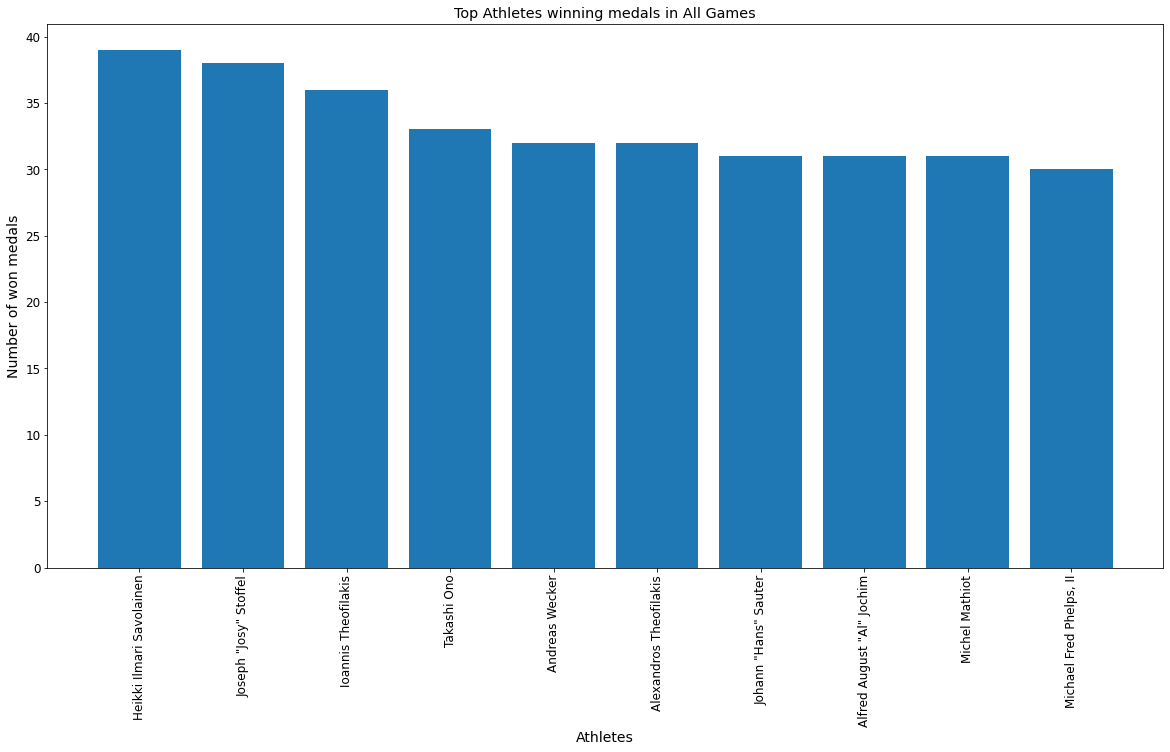

In [157]:
top_athletes_participating = df_olympics.groupby(['Name'])['ID'].count().sort_values(ascending=False)
top_athletes_winning_medals = df_olympics.groupby(['Name'])['Medal_Enumarated'].count().sort_values(ascending=False)

plt.figure(figsize=(20,10))
plt.bar(x=top_athletes_winning_medals[:10].index, height=top_athletes_winning_medals[:10])
plt.title('Top Athletes winning medals in All Games')
plt.xlabel('Athletes')
plt.ylabel('Number of won medals')
plt.xticks(rotation=90);

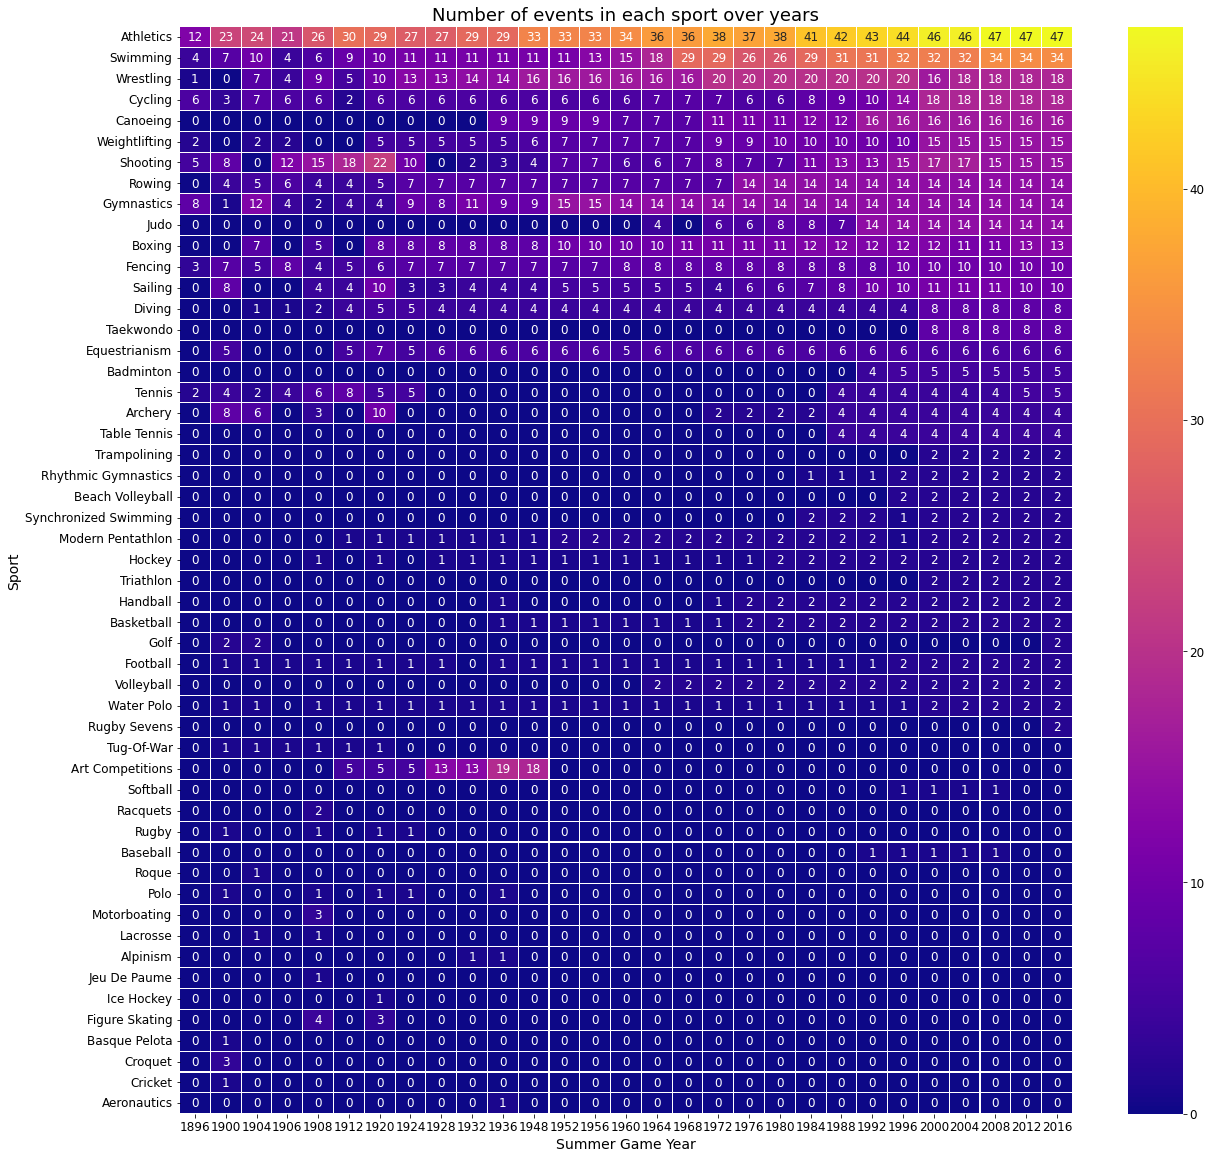

In [158]:
sport_year = df_olympics[df_olympics['Season']=='Summer'].pivot_table(df_olympics, index=['Year','Sport'], aggfunc=lambda x: len(x.unique())).reset_index()[['Year','Sport','Event']]
sport_year = sport_year.pivot("Sport", "Year", "Event")
sport_year.fillna(0,inplace=True)
sport_year = sport_year.reindex(sport_year.sort_values(by=2016, ascending=False).index)
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(sport_year, annot=True, linewidths=0.05, ax=ax, cmap="plasma")
ax.set_xlabel('Summer Game Year', size=14)
ax.set_ylabel('Sport', size=14)
ax.set_title('Number of events in each sport over years', size=18)
plt.show()

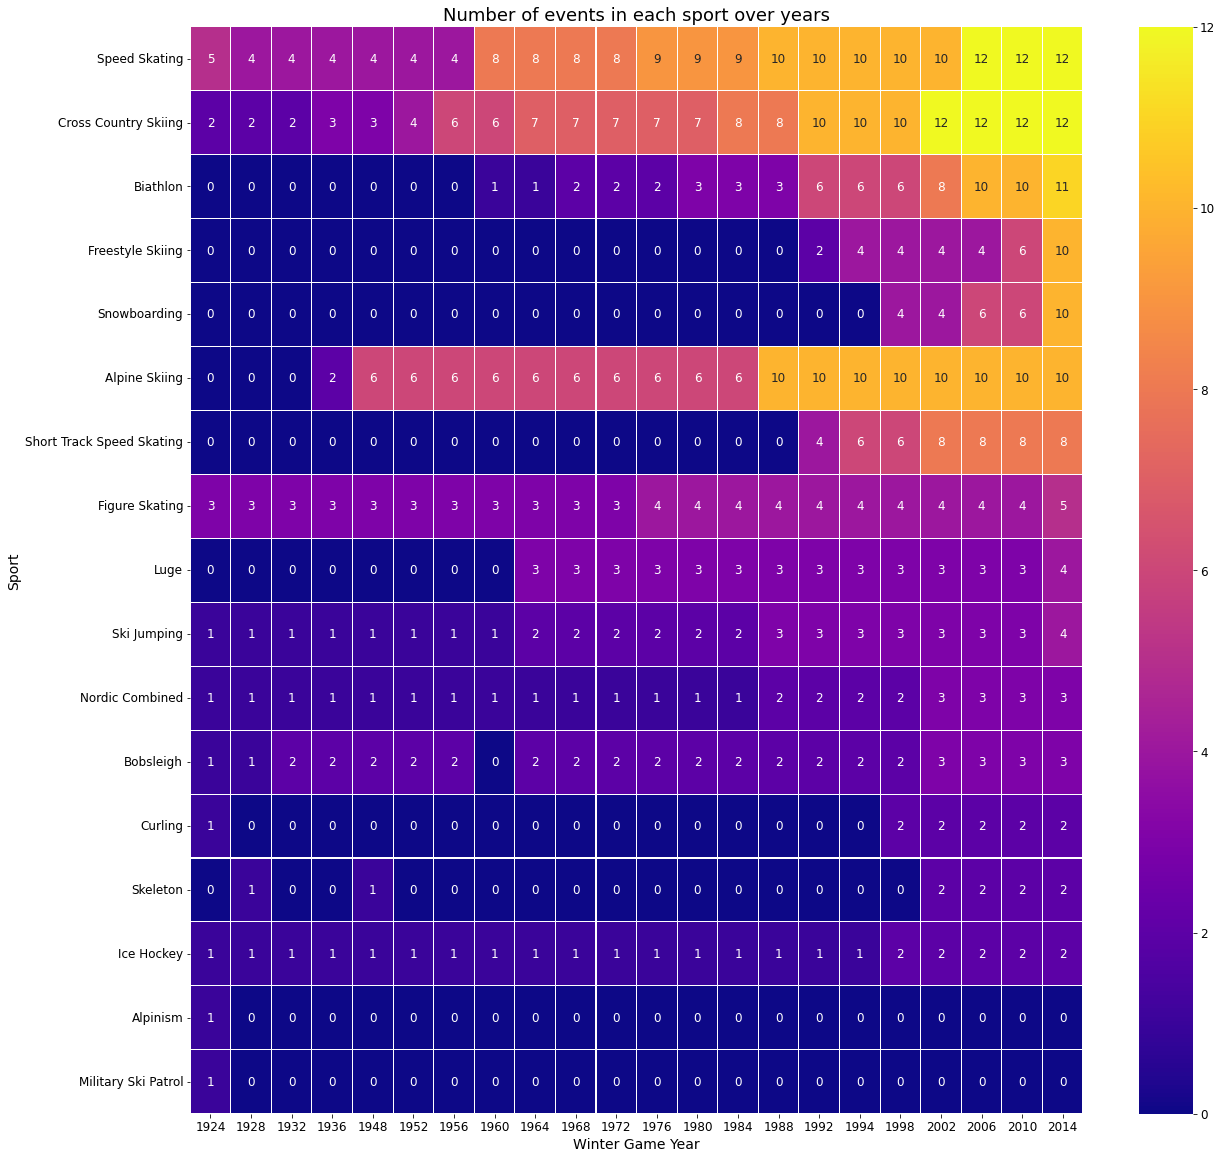

In [159]:
sport_year = df_olympics[df_olympics['Season']=='Winter'].pivot_table(df_olympics, index=['Year','Sport'], aggfunc=lambda x: len(x.unique())).reset_index()[['Year','Sport','Event']]
sport_year = sport_year.pivot("Sport", "Year", "Event")
sport_year.fillna(0,inplace=True)
sport_year = sport_year.reindex(sport_year.sort_values(by=2014, ascending=False).index)
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(sport_year, annot=True, linewidths=0.05, ax=ax, cmap="plasma")
ax.set_xlabel('Winter Game Year', size=14)
ax.set_ylabel('Sport', size=14)
ax.set_title('Number of events in each sport over years', size=18)
plt.show()

# **MERGING DATASETS**

## Countries dataset for GDP

In [160]:
countries= df_olympics['region'].unique()
countries.sort()
print(countries)

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Boliva'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czech Republic' 'Democratic Republic of the Congo'
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Grenada' 'Guam' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Individual Olympic Athletes'
 'Indonesia' 'Iran' 'Iraq' 'Ireland' '

In [161]:
df_countries= pd.read_csv('/content/drive/MyDrive/Data Engineering/dataset/countries of the world.csv')
df_countries.head()

Country                               Region  ...  Industry  Service
0     Afghanistan         ASIA (EX. NEAR EAST)           ...      0,24     0,38
1         Albania   EASTERN EUROPE                       ...     0,188    0,579
2         Algeria   NORTHERN AFRICA                      ...       0,6    0,298
3  American Samoa   OCEANIA                              ...       NaN      NaN
4         Andorra   WESTERN EUROPE                       ...       NaN      NaN

[5 rows x 20 columns]

In [162]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

In [163]:
cols=df_countries.columns.values
removed_cols = np.delete(cols, np.where(cols == 'Country'))
removed_cols = np.delete(removed_cols, np.where(removed_cols == 'GDP ($ per capita)'))
# removed_cols = np.delete(removed_cols, np.where(removed_cols == 'Population'))

removed_cols

array(['Region', 'Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)',
       'Net migration', 'Infant mortality (per 1000 births)',
       'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)',
       'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture',
       'Industry', 'Service'], dtype=object)

In [164]:
df_countries.drop(removed_cols, axis = 1,inplace=True)
df_countries.head()

Country  GDP ($ per capita)
0     Afghanistan                700.0
1         Albania               4500.0
2         Algeria               6000.0
3  American Samoa               8000.0
4         Andorra              19000.0

**Country western sahara is the only country with GDP missing value but it does not exist in our dataset so it's not important to impute**

In [165]:
df_countries[df_countries['GDP ($ per capita)'].isna()]


Country  GDP ($ per capita)
223  Western Sahara                  NaN

In [166]:
print(countries.__contains__('Sahara ') | countries.__contains__('Western Sahara '))# country names contain extra space


False


In [167]:
df_countries['Country'][0]

'Afghanistan '

**Countries contains extra space at the end that need trimming**

In [168]:
countries_external=df_countries['Country']
for i in range(len(countries_external)):
    countries_external[i]=countries_external[i][:-1]
countries_external

0         Afghanistan
1             Albania
2             Algeria
3      American Samoa
4             Andorra
            ...      
222         West Bank
223    Western Sahara
224             Yemen
225            Zambia
226          Zimbabwe
Name: Country, Length: 227, dtype: object

**In the new dataset we have sudan and virgin islands, those are now separated. So we will add to the new dataset duplicated data (assuming sudan and south sudan have same data and same for virgin islands).**

In [169]:
df_countries_separated=df_countries[(df_countries['Country']=='Sudan')|(df_countries['Country']=='Virgin Islands')]
print(df_countries_separated)
extra1 = {'Country': 'South Sudan', 'GDP ($ per capita)': '1900.0'}
extra2 = {'Country': 'Virgin Islands, US', 'GDP ($ per capita)': '17200.0'}
df_countries.loc[220,'Country']='Virgin Islands, British'
df_countries = df_countries.append(extra1, ignore_index = True)
df_countries = df_countries.append(extra2, ignore_index = True)
print(df_countries.tail())
df_countries[(df_countries['Country']=='Sudan')|(df_countries['Country']=='Virgin Islands, British')|(df_countries['Country']=='South Sudan')|(df_countries['Country']=='Virgin Islands, US')]

            Country  GDP ($ per capita)
192           Sudan              1900.0
220  Virgin Islands             17200.0
                Country GDP ($ per capita)
224               Yemen                800
225              Zambia                800
226            Zimbabwe               1900
227         South Sudan             1900.0
228  Virgin Islands, US            17200.0


Country GDP ($ per capita)
192                    Sudan               1900
220  Virgin Islands, British              17200
227              South Sudan             1900.0
228       Virgin Islands, US            17200.0

**Using levenstein distance for country names to resolve inconsistencies in naming to perform the merging of 2 datasets smoothly**

In [170]:
lev_matrix=np.zeros((len(countries),len(countries_external)))
for i in range(lev_matrix.shape[0]):
    for j in range(lev_matrix.shape[1]):
        lev_matrix[i][j]=levenshtein.distance(countries[i], countries_external[j])
lev_matrix

array([[ 0.,  6.,  7., ..., 10.,  9., 10.],
       [ 6.,  0.,  3., ...,  6.,  5.,  6.],
       [ 7.,  3.,  0., ...,  6.,  5.,  8.],
       ...,
       [10.,  6.,  6., ...,  0.,  5.,  7.],
       [ 9.,  5.,  5., ...,  5.,  0.,  5.],
       [10.,  6.,  8., ...,  7.,  5.,  0.]])

**Now each row represents a country in the olympics, each column represents name of the countries from external dataset, so we match them, and we found some inconsistencies, the printed ones are the inconsistent countries, where the key is the country name in external dataset, and the value is the closest name in our dataset that matches that country.**

In [171]:
# the dictionary contains keys as country names in the external dataset
# and values as country name from olympics dataset, closest to the corresponding key
# identical pairs are excluded so they will not cause inconsistencies
dict_replacement= {}
for i in range(lev_matrix.shape[0]):
    min=100000
    minidx=-1
    for j in range(lev_matrix.shape[1]):
        if lev_matrix[i][j]<min:
            min=lev_matrix[i][j]
            minidx=j
    if countries_external[minidx]!= countries[i]:
        dict_replacement[countries_external[minidx]]=countries[i]

dict_replacement


{'Andorra': 'Antigua',
 'Barbados': 'Ivory Coast',
 'Bolivia': 'Boliva',
 'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
 'Burma': 'Curacao',
 'Central African Rep.': 'Central African Republic',
 'Chad': 'USA',
 'Comoros': 'Timor-Leste',
 'Congo, Dem. Rep.': 'Refugee Olympic Team',
 'Congo, Repub. of the': 'Democratic Republic of the Congo',
 'Denmark': 'Myanmar',
 'Grenada': 'Trinidad',
 'Indonesia': 'Micronesia',
 'Isle of Man': 'Republic of Congo',
 'Montserrat': 'Montenegro',
 'Pakistan': 'Palestine',
 'Panama': 'Bahamas',
 'Saint Helena': 'Saint Vincent',
 'Saint Lucia': 'Saint Kitts',
 'Sao Tome & Principe': 'Sao Tome and Principe',
 'South Africa': 'South Sudan',
 'United Arab Emirates': 'Individual Olympic Athletes',
 'Virgin Islands, British': 'Virgin Islands, US',
 'Zambia': 'Gambia'}

In [172]:
with open('countries_external.txt', 'w') as f:
    for line in countries_external:
        f.write(line)
        f.write('\n')

with open('countries.txt', 'w') as f:
    for line in countries:
        f.write(line)
        f.write('\n')

**Both Individual Olympic Athletes and Refugee Olympic Team will be dropped as they do not belong to a certain country so they will not be of use in our analysis of regions especially in question 1 and 7**

In [173]:
print(len(df_olympics[df_olympics['region']=='Individual Olympic Athletes']))
print(len(df_olympics[df_olympics['region']=='Refugee Olympic Team']))

94
12


In [174]:
df_olympics = df_olympics[df_olympics['region']!='Individual Olympic Athletes']
df_olympics = df_olympics[df_olympics['region']!='Refugee Olympic Team']
df_olympics = df_olympics[df_olympics['region']!='Israel'] #Because it is not a country

new_regions = df_olympics['region'].unique()
new_regions.sort()
print(new_regions.__contains__('Individual Olympic Athletes'))
print(new_regions.__contains__('Refugee Olympic Team'))
print(new_regions.__contains__('Israel'))

False
False
False


**Replacing in our dataset countries that belonged to others but are separated recently**

In [175]:
# Montenegro -> Serbia (montenegro was included in serbia)
# Kosovo -> Serbia (kosovo was included in serbia)
# Curacao -> Netherlands (curacao is in region of netherlands)

for index in df_olympics.index:
    if df_olympics.loc[index,'region']=='Montenegro':
        df_olympics.loc[index,'region'] = 'Serbia'
    elif df_olympics.loc[index,'region']=='Curacao':
        df_olympics.loc[index,'region'] = 'Netherlands'
    elif df_olympics.loc[index,'region']=='Kosovo':
        df_olympics.loc[index,'region'] = 'Serbia'


#validate that they are replaced
new_regions = df_olympics['region'].unique()
new_regions.sort()
print(new_regions.__contains__('Montenegro'))
print(new_regions.__contains__('Curacao'))

False
False


**Replace countries in external dataset with naming in our dataset to match in merging.**

In [176]:
for index in df_countries.index:
    if df_countries.loc[index,'Country']=='Antigua & Barbuda':
        df_countries.loc[index,'Country'] = 'Antigua'
    elif df_countries.loc[index,'Country']=='Bahamas, The':
        df_countries.loc[index,'Country'] = 'Bahamas'
    elif df_countries.loc[index,'Country']=='Congo, Repub. of the':
        df_countries.loc[index,'Country'] = 'Republic of Congo'
    elif df_countries.loc[index,'Country']=='Congo, Dem. Rep.':
        df_countries.loc[index,'Country'] = 'Democratic Republic of the Congo'
    elif df_countries.loc[index,'Country']=="Cote d'Ivoire":
        df_countries.loc[index,'Country'] = 'Ivory Coast'
    elif df_countries.loc[index,'Country']=='Gambia, The':
        df_countries.loc[index,'Country'] = 'Gambia'
    elif df_countries.loc[index,'Country']=='United States':
        df_countries.loc[index,'Country'] = 'USA'
    elif df_countries.loc[index,'Country']=='Israel':
        df_countries.loc[index,'Country'] = 'Palestine'
    elif df_countries.loc[index,'Country']=='East Timor':
        df_countries.loc[index,'Country'] = 'Timor-Leste'
    elif df_countries.loc[index,'Country']=='Burma':
        df_countries.loc[index,'Country'] = 'Myanmar'
    elif df_countries.loc[index,'Country']=='Saint Kitts & Nevis':
        df_countries.loc[index,'Country'] = 'Saint Kitts'
    elif df_countries.loc[index,'Country']=='Saint Vincent and the Grenadines':
        df_countries.loc[index,'Country'] = 'Saint Vincent'
    elif df_countries.loc[index,'Country']=='Trinidad & Tobago':
        df_countries.loc[index,'Country'] = 'Trinidad'
    elif df_countries.loc[index,'Country']=='Micronesia, Fed. St.':
        df_countries.loc[index,'Country'] = 'Micronesia'
    elif df_countries.loc[index,'Country']=='Burma':
        df_countries.loc[index,'Country'] = 'Myanmar'
    elif df_countries.loc[index,'Country']=='United Kingdom':
        df_countries.loc[index,'Country'] = 'UK'
    elif df_countries.loc[index,'Country']=='Korea, South':
        df_countries.loc[index,'Country'] = 'South Korea'
    elif df_countries.loc[index,'Country']=='Korea, North':
        df_countries.loc[index,'Country'] = 'North Korea'
    elif df_countries.loc[index,'Country']=='Central African Rep.':
        df_countries.loc[index,'Country'] = 'Central African Republic'
    elif df_countries.loc[index,'Country']=='Bosnia & Herzegovina':
        df_countries.loc[index,'Country'] = 'Bosnia and Herzegovina'
    elif df_countries.loc[index,'Country']=='Bolivia':
        df_countries.loc[index,'Country'] = 'Boliva'
    elif df_countries.loc[index,'Country']=='Sao Tome & Principe':
        df_countries.loc[index,'Country'] = 'Sao Tome and Principe'
    elif df_countries.loc[index,'Country']=='Virgin Islands':
        df_countries.loc[index,'Country'] = 'Virgin Islands, US'


#validate that some are replaced
new_countries = df_countries['Country'].unique()
new_countries.sort()
print(new_countries.__contains__('Antigua & Barbuda'))
print(new_countries.__contains__('Bahamas, The'))

False
False


In [177]:
new_countries

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Boliva', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Is.', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros', 'Cook Islands',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland', 'France',
       'French Guiana', 'French Polynesia', 

In [178]:
#renaming column Country in external dataset to region
df_countries.rename(columns={'Country': 'region'}, inplace=True)
df_countries.head()

region GDP ($ per capita)
0     Afghanistan                700
1         Albania               4500
2         Algeria               6000
3  American Samoa               8000
4         Andorra              19000

**AAAAANNNNDD FINAAALLLYYY MERGIIING BOOOOOTH DATAAAASEEEETS**

In [179]:
df_merged_countries = pd.merge(df_olympics, df_countries, how='left',on='region')
df_merged_countries.head()

ID             Name Sex  ...  region  Medal_Enumarated  GDP ($ per capita)
0      1        A Dijiang   M  ...   China                 0                5000
1  20211    Chen Jianghua   M  ...   China                 0                5000
2  20211    Chen Jianghua   M  ...   China                 0                5000
3  20225          Chen Ke   M  ...   China                 0                5000
4  20615  Chia Chungchang   M  ...   China                 0                5000

[5 rows x 17 columns]

In [180]:
# wohooooo no null values
df_merged_countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268609 entries, 0 to 268608
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  268609 non-null  int64  
 1   Name                268609 non-null  object 
 2   Sex                 268609 non-null  object 
 3   Age                 268609 non-null  float64
 4   Height              268609 non-null  float64
 5   Weight              268609 non-null  float64
 6   Team                268609 non-null  object 
 7   NOC                 268609 non-null  object 
 8   Games               268609 non-null  object 
 9   Year                268609 non-null  int64  
 10  Season              268609 non-null  object 
 11  City                268609 non-null  object 
 12  Sport               268609 non-null  object 
 13  Event               268609 non-null  object 
 14  region              268609 non-null  object 
 15  Medal_Enumarated    268609 non-nul

In [181]:
df_merged_countries[df_merged_countries['GDP ($ per capita)'].isna()]['region'].unique()

array([], dtype=object)

# **FEATURE ENGINEERING**

## BMI

In [184]:
df_olympics['BMI'] = df_olympics['Weight']/(df_olympics['Height']/100)**2
df_olympics

ID  ...        BMI
0           1  ...  24.691358
167     20211  ...  20.875633
168     20211  ...  20.875633
191     20225  ...  24.990388
372     20615  ...  23.981426
...       ...  ...        ...
54000   35364  ...  21.224637
58525   88258  ...  21.224637
58526   88258  ...  21.224637
206850  41857  ...  21.224637
174114  31057  ...  21.224637

[268609 rows x 17 columns]

## The second feature is at the analyzation of the research question (question 5)

#**INSIGHTS**

#### ▶ **Olympics Seasons**

We realised that the ranges of the x-labels were inconsistent. After investigating more we found out that olympics occurred every four years, that is in every leap year to be specific. We also found out that winter seasons started in 1994. The Winter and Summer olympics were held in the same years until 1992, where after that the winter games were held after two years from the summer games. After that we found out that winter events were not held due to logistic difficulties for organizing snow and ice events.

\
Researching more about the topic we found out that the International Olympic Committee (IOC) decided to place the Summer and Winter Games on separate four-year cycles in alternating even-numbered years. 

\
Note that the gap between 1936 and 1948 was due to World War 2.

---



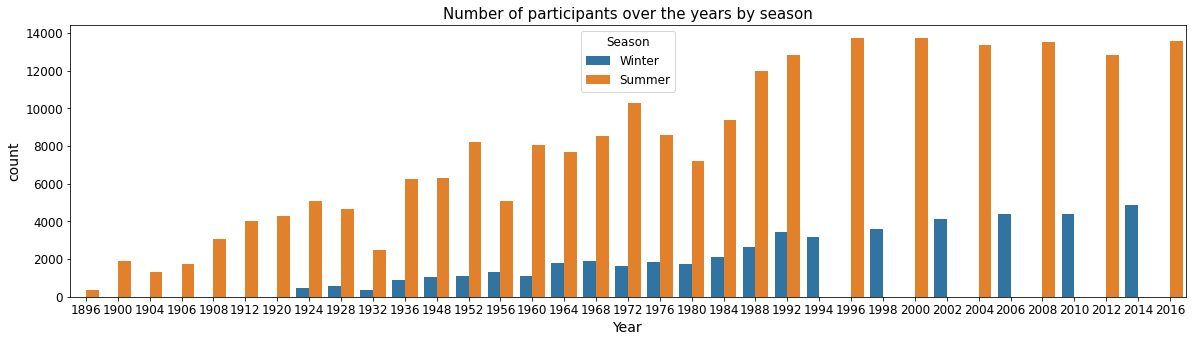

In [185]:
plt.figure(figsize=(20,5))
plt.title("Number of participants over the years by season",fontsize=15)
sns.countplot(data=df_olympics,x="Year",hue='Season',hue_order=['Winter','Summer'] )

#### ▶ **Rivalry between USA and Russia**

We found that the top two countries from number of participants and number of medals were Russia and USA. We decided to observe the rivalry between these two countries, and we found out that although Russia had more participants over the years, but USA won more medals in almost all the years.


In [186]:
df_olympics.head()

ID             Name Sex  ...  region  Medal_Enumarated        BMI
0        1        A Dijiang   M  ...   China                 0  24.691358
167  20211    Chen Jianghua   M  ...   China                 0  20.875633
168  20211    Chen Jianghua   M  ...   China                 0  20.875633
191  20225          Chen Ke   M  ...   China                 0  24.990388
372  20615  Chia Chungchang   M  ...   China                 0  23.981426

[5 rows x 17 columns]

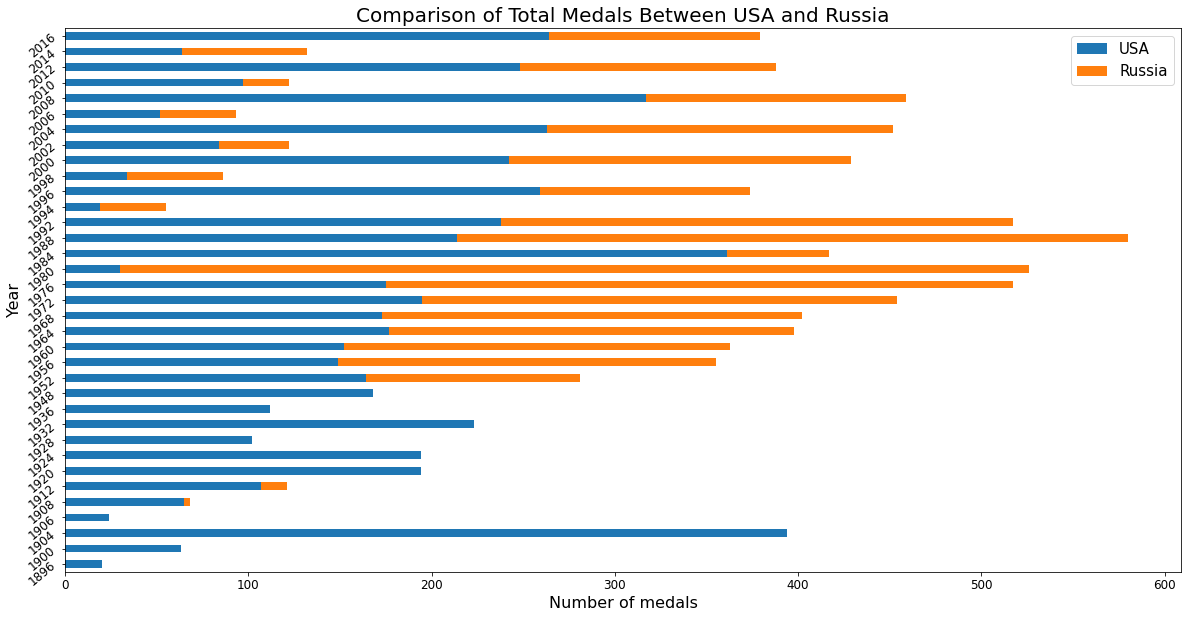

In [187]:
#Comparison between USA and Russia (Top two countries )
YearGroupData=df_olympics.groupby('Year')
  
df_USA = pd.DataFrame(columns = ['Year', 'GoldUS', 'SilverUS' , 'BronzeUS'])
df_Russia = pd.DataFrame(columns = ['Year', 'GoldRuss', 'SilverRuss' , 'BronzeRuss'])
df_TOPTWO= pd.DataFrame(columns = ['Year', 'GoldUS', 'SilverUS' , 'BronzeUS', 'GoldRuss', 'SilverRuss' , 'BronzeRuss'  , 'TotalUs','TotalRuss'])
 
for i,j in YearGroupData:
    GoldUS,SilverUS, BronzeUS, GoldRuss ,SilverRuss , BronzeRuss=0,0,0,0,0,0
    USA=j[j['region']=="USA"]
    Russia=j[j['region']=="Russia"] 
    GoldUS = len(USA[ USA['Medal_Enumarated']==3])
    SilverUS =len(USA[ USA['Medal_Enumarated']==2])
    BronzeUS =len(USA[ USA['Medal_Enumarated']==1])  
    GoldRuss = len( Russia[Russia['Medal_Enumarated']==3])
    SilverRuss =len( Russia[  Russia['Medal_Enumarated']==2])
    BronzeRuss =len( Russia[  Russia['Medal_Enumarated']==1]) 
    totalUS=GoldUS+SilverUS+BronzeUS
    totalRuss=GoldRuss+SilverRuss+BronzeRuss
    new_rowUS={'Year': i ,'GoldUS':GoldUS , 'SilverUS':SilverUS , 'BronzeUS':BronzeUS}  
    new_rowRuss={'Year': i ,'GoldRuss': GoldRuss, 'SilverRuss':SilverRuss , 'BronzeRuss':BronzeRuss}
    df_USA=df_USA.append(new_rowUS,  ignore_index=True)
    df_Russia=df_Russia.append(  new_rowRuss , ignore_index=True)
    new_row2={'Year': i ,'GoldUS':GoldUS , 'SilverUS':SilverUS , 'BronzeUS':BronzeUS, 'GoldRuss': GoldRuss, 'SilverRuss':SilverRuss , 'BronzeRuss':BronzeRuss,'TotalUs':totalUS,'TotalRuss':totalRuss }   
    df_TOPTWO=df_TOPTWO.append(  new_row2 ,  ignore_index=True)
    

ig, ax = plt.subplots(figsize=(20,10))
df_TOPTWO.plot(x = 'Year', y = ['TotalUs','TotalRuss'],kind="barh", stacked=True, rot = 40, ax = ax) 
plt.title('Comparison of Total Medals Between USA and Russia',fontsize=20); 
ax.set_xlabel("Number of medals",fontsize=16 )
ax.set_ylabel("Year",fontsize=16 )
ax.legend(['USA', 'Russia'], fontsize=15)

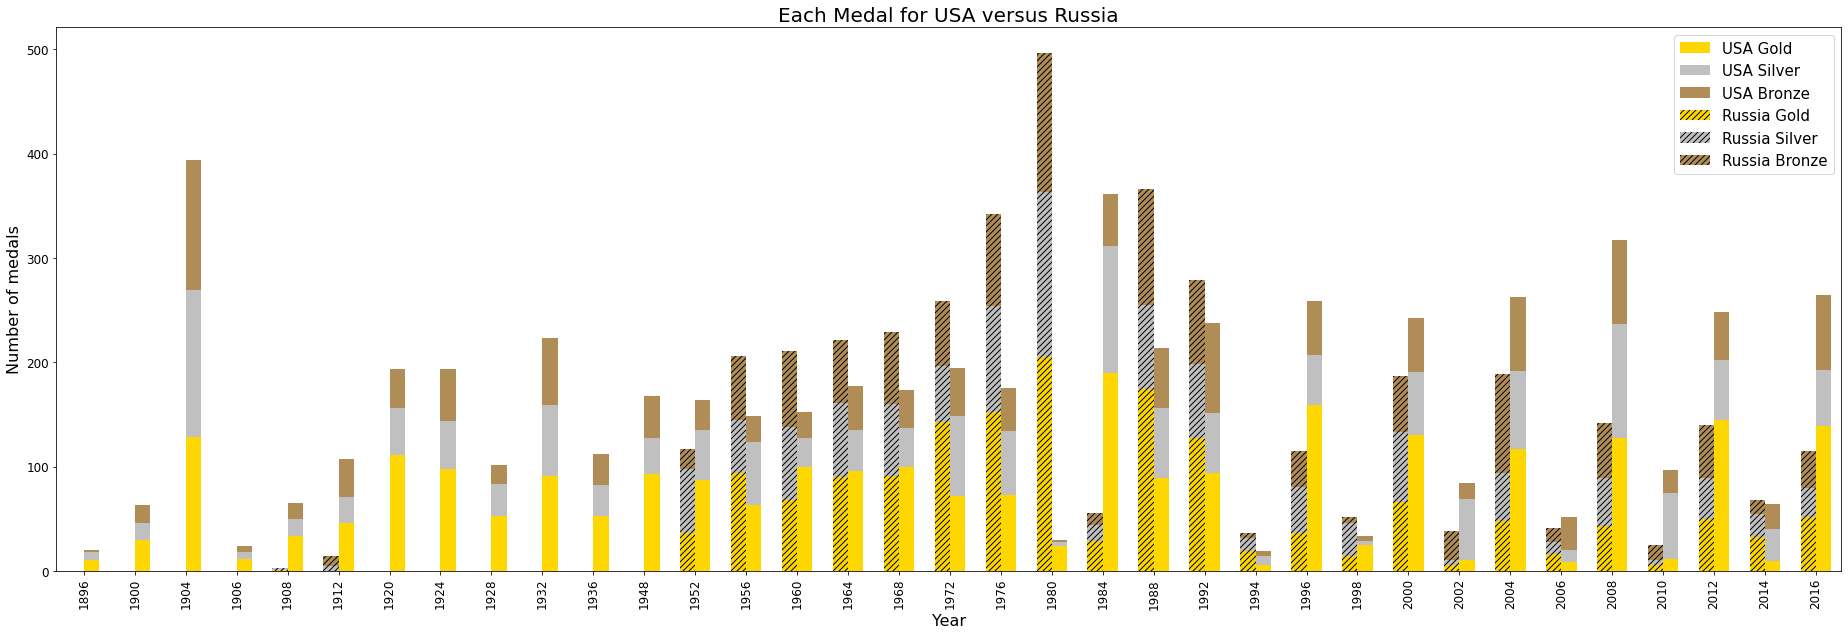

In [188]:
fig, ax = plt.subplots(figsize=(32,10))

df_USA.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'], width=0.3,position=0,
                  ax=ax)
df_Russia.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'], width=0.3, position=1, hatch='////',
                  ax=ax)

ax.set_xlim(right=len(df_USA)-0.5)

ax.set_title('Each Medal for USA versus Russia' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Year",fontsize=16 )
ax.legend(['USA Gold','USA Silver','USA Bronze', 'Russia Gold','Russia Silver','Russia Bronze'], fontsize=15)

#**Exploring the research questions**

1. Does economy of the country affect their performance? (merging 1)
2. What is the estimated number of appearances for a participant to achieve their first medal?
3. What are the features that most affect player performance?
4. Predict whether the player could get a medal or not next year?
5. How different BMI ranges are demanded, and what are the effects and changes of BMI? (feature engineering 1)
6. How hosting events affects country's performance? (feature engineering 2)
7. Do countries with high gdp are chosen to host the olympics ?
8. Do the number of medals on average increase as an athlete participates more?
9. What are the performances of both genders?
10. Is the number of medals related to the number of each medal?

#### **1- Does economy of the country affect their performance?** (merging 1)
We can notice that there is a moderate correlation between GDP and total medals achieved because the correlation value in both pearson and kendall methods is between 0.3 and 0.7. So, the country's economy indeed affects the performance but not strongly. This analysis made us believe that the longer the athlete stays without achieving a medal, the less possible this athlete will achieve his first medal in the next game.


---



**Find the correlation between the number of medals achieved and the GDP**

In [189]:
# finding the correlation between the number of medals achieved and the GDP
new_countries=df_merged_countries['region'].unique()
country_medals=np.zeros(len(new_countries))
country_gdp=np.zeros(len(new_countries))
i=0
for country in new_countries:
    total_medals=len(df_merged_countries[(df_merged_countries['region']==country) & (df_merged_countries['Medal_Enumarated']>0)])
    gdp=df_merged_countries[(df_merged_countries['region']==country)].iloc[0]['GDP ($ per capita)']
    country_medals[i]=total_medals
    country_gdp[i]=gdp
    i+=1

print(country_medals[:10])
print(country_gdp[:10])

[ 993. 5637.  900.  653.   50. 1767.   23.  489.   27.   68.]
[ 5000. 37800. 27400.  7000. 12300. 27600.  4000. 22000.  4000.  7000.]


In [190]:
# setting up the dataframe to construct the dataframe for correlation
arr_correlation = np.array([np.transpose(country_gdp),np.transpose(country_medals)])
arr_correlation = arr_correlation.transpose()

df_correlation = pd.DataFrame(arr_correlation, columns = ['country_medals' , 'country_gdp'])
print(df_correlation)

     country_medals  country_gdp
0            5000.0        993.0
1           37800.0       5637.0
2           27400.0        900.0
3            7000.0        653.0
4           12300.0         50.0
..              ...          ...
196           500.0          0.0
197          1200.0          0.0
198           800.0          0.0
199          1100.0          0.0
200          1900.0          0.0

[201 rows x 2 columns]


In [191]:
df_correlation.corr(method='pearson') # --> correlation = 0.42

country_medals  country_gdp
country_medals        1.000000     0.424253
country_gdp           0.424253     1.000000

In [192]:
df_correlation.corr(method='kendall') # --> correlation = 0.33

country_medals  country_gdp
country_medals        1.000000     0.330076
country_gdp           0.330076     1.000000

Text(0, 0.5, 'Toal medal count')

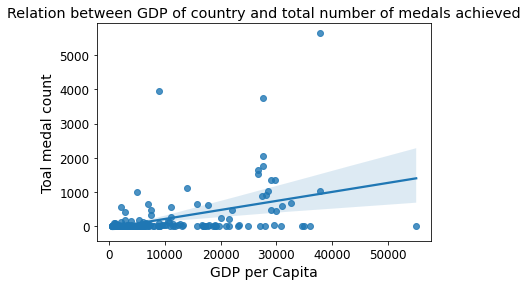

In [193]:
ax=sns.regplot(country_gdp,country_medals)
ax.set_title('Relation between GDP of country and total number of medals achieved')
ax.set_xlabel("GDP per Capita")
ax.set_ylabel("Toal medal count")

#### **2- What is the estimated number of appearances for a participant to achieve their first medal?**
We achieved the average number of appearances of 1.575, we infer that the majority took one or two trials only to achieve their first medal, also after using log scale we noticed that the trend is decreasing. Which means less players need more appearances to achieve their first medal.

---



In [203]:
df_olympics2=df_olympics.copy()
df_olympics2['isSummer']= (df_olympics2['Season']=='Summer')*1
df_olympics2.head()

ID             Name Sex  ...  Medal_Enumarated        BMI  isSummer
0        1        A Dijiang   M  ...                 0  24.691358         1
167  20211    Chen Jianghua   M  ...                 0  20.875633         1
168  20211    Chen Jianghua   M  ...                 0  20.875633         1
191  20225          Chen Ke   M  ...                 0  24.990388         1
372  20615  Chia Chungchang   M  ...                 0  23.981426         1

[5 rows x 18 columns]

The indicator is used in sorting the dataframe, we sort by the year first then by winter and summer giving precedence to winter as it occurs before the summer olympics.

In [204]:
df_olympics_sorted=df_olympics2.sort_values(by=['Year','isSummer']) 

In [205]:
# olympic games sorted with year, then with winter and summer (winter games are held before the summer)
df_olympics_sorted['Games'].unique()

array(['1896 Summer', '1900 Summer', '1904 Summer', '1906 Summer',
       '1908 Summer', '1912 Summer', '1920 Summer', '1924 Winter',
       '1924 Summer', '1928 Winter', '1928 Summer', '1932 Winter',
       '1932 Summer', '1936 Winter', '1936 Summer', '1948 Winter',
       '1948 Summer', '1952 Winter', '1952 Summer', '1956 Winter',
       '1956 Summer', '1960 Winter', '1960 Summer', '1964 Winter',
       '1964 Summer', '1968 Winter', '1968 Summer', '1972 Winter',
       '1972 Summer', '1976 Winter', '1976 Summer', '1980 Winter',
       '1980 Summer', '1984 Winter', '1984 Summer', '1988 Winter',
       '1988 Summer', '1992 Winter', '1992 Summer', '1994 Winter',
       '1996 Summer', '1998 Winter', '2000 Summer', '2002 Winter',
       '2004 Summer', '2006 Winter', '2008 Summer', '2010 Winter',
       '2012 Summer', '2014 Winter', '2016 Summer'], dtype=object)

In [206]:
#number of athletes achieved at least 1 medal
len(df_olympics_sorted[df_olympics_sorted['Medal_Enumarated']>0]['Name'].unique())

28186

In [207]:
# here we construct a dictionary containing (key,value)-> (athlete_name,appearances till achieving first medal)
# the dictionary only contains medal holders
# see dictionary in the cell below
total_appearances={}
appearances_until_achieving_first_medal={}
df_indices = df_olympics_sorted.index

for index in df_indices:
    row = df_olympics_sorted.loc[index]
    athlete_name = row['Name']
    apps=0
    if athlete_name in total_appearances:
        apps = total_appearances[athlete_name]
    apps+=1
    total_appearances[athlete_name]=apps
    
    medal = row['Medal_Enumarated']
    if medal>0 and athlete_name not in appearances_until_achieving_first_medal:
        appearances_until_achieving_first_medal[athlete_name]=apps

        
print(len(appearances_until_achieving_first_medal))
# same number of medal holders

# appearances_until_achieving_first_medal

28186


In [208]:
# Average number of appearances is 1.575, this means that medal holders are most likely to achieve their first
# at an early stage in their career 
appearances = 0
max_appearances=1
for athlete in appearances_until_achieving_first_medal:
    app=appearances_until_achieving_first_medal[athlete]
    appearances+=app
    if app>max_appearances:
        max_appearances=app
print("Average number of appearances until achieving first medal = ",appearances/len(appearances_until_achieving_first_medal))
print("Maximum number of appearances = ",max_appearances)

Average number of appearances until achieving first medal =  1.57500177393032
Maximum number of appearances =  22


In [209]:
# we use this for the histogram to show stats of the appearances
counts_of_appearances = np.zeros(22)
for athlete in appearances_until_achieving_first_medal:
    app=appearances_until_achieving_first_medal[athlete]
    counts_of_appearances[app-1]+=1
counts_of_appearances

array([1.8981e+04, 5.9340e+03, 1.7750e+03, 7.1700e+02, 3.0000e+02,
       1.7700e+02, 8.3000e+01, 7.8000e+01, 4.4000e+01, 3.5000e+01,
       2.1000e+01, 6.0000e+00, 8.0000e+00, 9.0000e+00, 9.0000e+00,
       2.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
       1.0000e+00, 2.0000e+00])

Text(0, 0.5, 'Count')

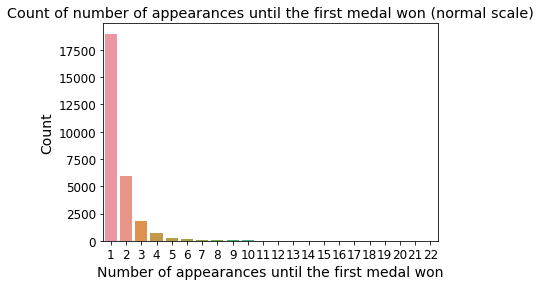

In [210]:
# we used those number of appearances and plotted a histogram to represent the counts
ax=sns.barplot(x = np.arange(1,23), y = counts_of_appearances)
ax.set_title('Count of number of appearances until the first medal won (normal scale)')
ax.set_xlabel("Number of appearances until the first medal won")
ax.set_ylabel("Count")

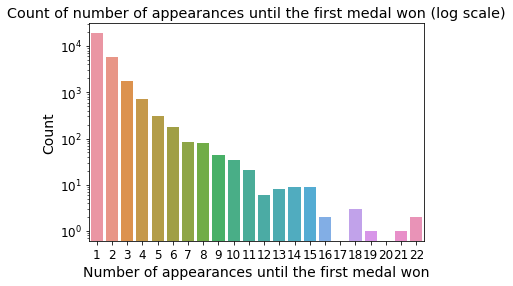

In [211]:
# we used log scale to show how values vary in bins with smaller frequency, we can notice that the trend is decreasing
# which means that less people need more appearances to achieve their first medal
ax=sns.barplot(x = np.arange(1,23), y = counts_of_appearances)
ax.set_title('Count of number of appearances until the first medal won (log scale)')
ax.set_xlabel("Number of appearances until the first medal won")
ax.set_ylabel("Count")
ax.set_yscale("log")

#### **3- What are the features that most affect player performance?**
We did not find a single attribute that has a strong direct correlation with performance, we measure performance according to the number of medals attained. So there was no column independently related to the winning of medals.



---



---



The sorted dataset constructed in the previous question is used here which is df_olympics_sorted.
It's sorted with the years then with season winter->summer.
We used it because we need to construct features depending on the history (such as cumulative appearances and cumulative medals).

In [321]:
#making a binary column called Medals where 0 means no medal, and 1 means any medal (irregular discretization)
medals = []  
for medal in df_olympics_sorted["Medal_Enumarated"]:
    if medal >0:
        medals.append(1) 
    else:
        medals.append(0) 
 
df_olympics_sorted["Medals"] = medals
 
    
    
total_appearances={}
appearances=[]
df_indices = df_olympics_sorted.index

#ENCODING the gender column to be 1 for male and 0 for female
gender = [] # define array structure
for g in df_olympics_sorted["Sex"]:
    if g=="M":
       gender.append(1) 
    else:
        gender.append(0)
        
# Copy dataframe to keep original 
df_olympics_sorted["gender"] = gender
df_olympics_sorted

ID                    Name Sex  ...  isSummer  Medals  gender
98771    59429  Stefanos Khristopoulos   M  ...         1       1       1
100537  122329         Georgios Tsitas   M  ...         1       1       1
117928  118532      Momcsill Tapavicza   M  ...         1       0       1
130102  107613          Carl Schuhmann   M  ...         1       1       1
206028   32330       Launceston Elliot   M  ...         1       0       1
...        ...                     ...  ..  ...       ...     ...     ...
258163  106163           Jiowana Sauto   F  ...         1       0       0
258186  118231    Timaima "Tima" Tamoi   F  ...         1       0       0
258189  118818            Rebecca Tavo   F  ...         1       0       0
258195  120431           Lavenia Tinai   F  ...         1       0       0
258196  120518            Luisa Tisolo   F  ...         1       0       0

[268609 rows x 20 columns]

**Feature Engineering**

cumulative_appearance: calculating the number of appearances this player has been in the last years including his current appearcnce



In [322]:
for index in df_indices:
    row = df_olympics_sorted.loc[index]
    athlete_name = row['Name']
    apps=0
    if athlete_name in total_appearances:
        apps = total_appearances[athlete_name]
    apps+=1
    total_appearances[athlete_name]=apps
    appearances.append(apps)
   
df_olympics_sorted["cumulative_app"] = appearances


cumulative_medals: calculating the number of cumulative medals this player had in the last Games

In [323]:
# calculating the number of cumulative medals this player had in the last Games 
total_medals={}
 
medals=[]
df_indices = df_olympics_sorted.index
 
X=df_olympics_sorted.groupby('Games')
for year, g in X:
    groupnames= g.groupby('Name') 
    for name ,grouprow in groupnames: 
        number_medals=0
       
       
        if(len(grouprow['Medal_Enumarated'] )>1):
            
            grouprow_indices = grouprow.index
            for index in  grouprow_indices:
                row = df_olympics_sorted.loc[index]
                if(name not in total_medals):
                      medals.append(0)   
                else:
                       medals.append( total_medals[name])   
                if row['Medal_Enumarated'] >0 :
                    number_medals+=1
        else:
                if(name not in total_medals):
                  medals.append(0)   
                else:
                  medals.append( total_medals[name])    
              
                if grouprow['Medal_Enumarated'].all()>0 :
                    number_medals+=1
        if(name not in total_medals):
               total_medals[name] =number_medals     
        else:
               total_medals[name] =total_medals[name]+number_medals     

   

df_olympics_sorted["cumulative_medals"] = medals

inTOP: binary column that returns whether the player team was one of the top five teams in the last years or not


In [324]:
#returns whether the player team was one of the top five teams 
def inTop5(team,updateddf):
    top_country_with_medals_df = updateddf.groupby(['Medals', 'Team'])['ID'].count() 
    medals_sorted_df = top_country_with_medals_df[1].sort_values(ascending=False)
    medals_sorted_df.index[0:5] 
    for c in medals_sorted_df.index[0:5] :
        if c==team:
            return 1
    return 0

inTop=[] 
mydf = pd.DataFrame()
X=df_olympics_sorted.groupby('Year')
for year, g in X:
    
    group_indices = g.index 
    for index  in group_indices: 
        row = df_olympics_sorted.loc[index] 
        team=row['Team']
        if(mydf.shape[0]==0):
            inTop.append(0)   
        else:
            inTop.append(inTop5(team,mydf))    
         
    mydf=df_olympics_sorted[df_olympics_sorted['Year']<=year]

df_olympics_sorted["inTop5"] =inTop

**Correlation between Two variables**

In [325]:
df_olympics_sorted.corr()

ID       Age  ...  cumulative_medals    inTop5
ID                 1.000000 -0.003230  ...           0.000081 -0.034861
Age               -0.003230  1.000000  ...           0.003460  0.052595
Height            -0.016342  0.114781  ...           0.002638  0.031469
Weight            -0.014221  0.208884  ...           0.004299  0.023273
Year               0.011039 -0.087981  ...           0.035559 -0.175386
Medal_Enumarated   0.010983  0.027656  ...           0.002526  0.103546
BMI               -0.008645  0.235341  ...           0.004035  0.009094
isSummer          -0.013876  0.034892  ...          -0.018764  0.003760
Medals             0.012440  0.029825  ...           0.002290  0.098538
gender            -0.026794  0.179563  ...          -0.007982  0.005149
cumulative_app     0.015129  0.159545  ...           0.011102  0.015451
cumulative_medals  0.000081  0.003460  ...           1.000000 -0.002764
inTop5            -0.034861  0.052595  ...          -0.002764  1.000000

[13 rows x 13 columns]

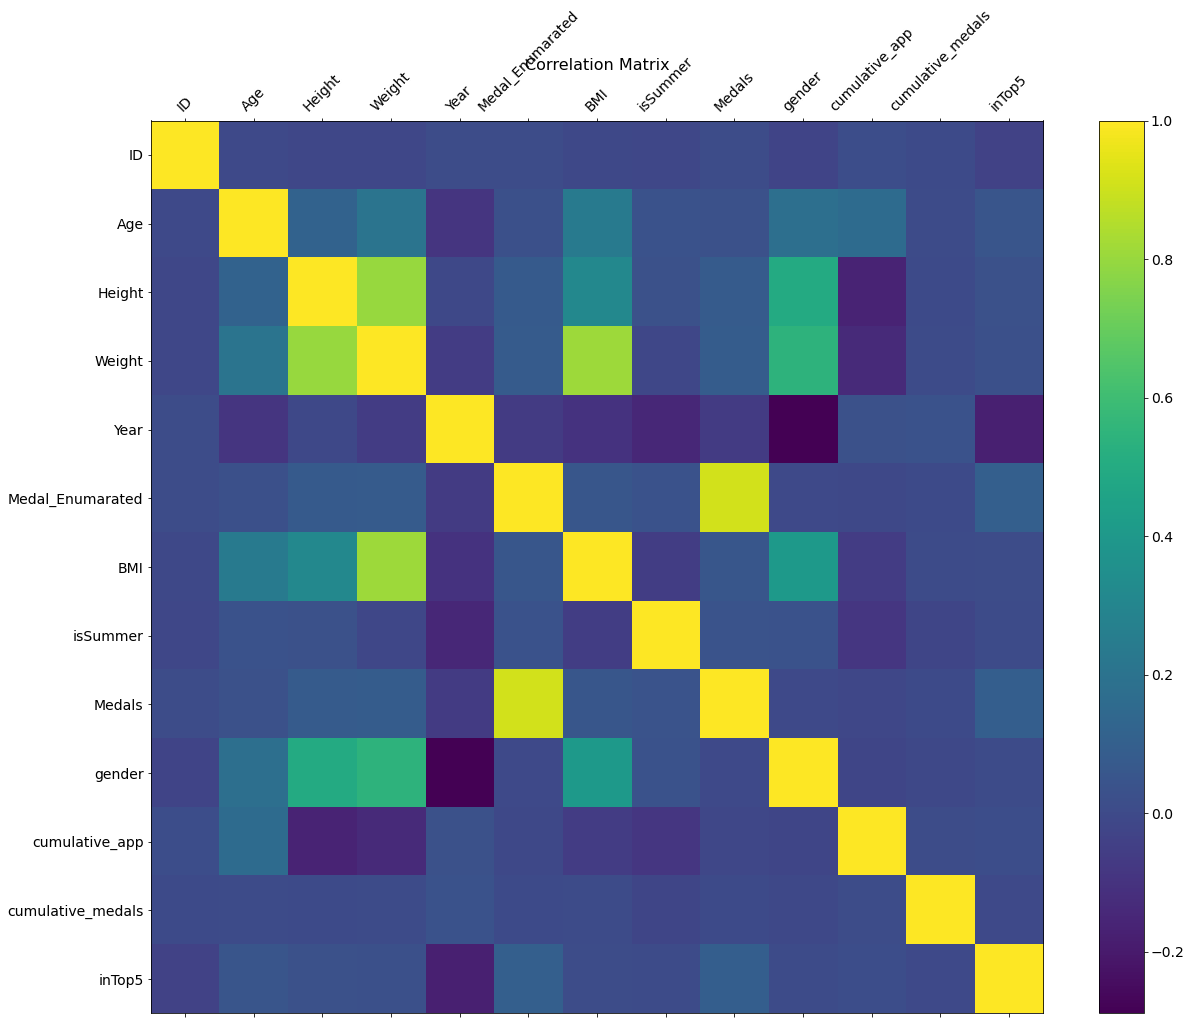

In [326]:
f = plt.figure(figsize=(20, 16))
plt.matshow(df_olympics_sorted.corr(), fignum=f.number)
plt.xticks(range(df_olympics_sorted.select_dtypes(['number']).shape[1]), df_olympics_sorted.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_olympics_sorted.select_dtypes(['number']).shape[1]), df_olympics_sorted.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**As shown in the figure the relations between Medals column and any other column are very weak which indicate that there is no feature that most affect the performance of the player**

#### **4- Predict whether the player could get a medal or not next year?**
Columns used to predict the medal columns are (Height , Weight, NOC ,City , Sport, isSummer(season) ,cumulative_app ,cumulative_medals2, inTop5, BMI ) the columns are chosen based on the corelation values I am using both Logistic Regression and SVM to predict the Medal Column those medals are tested on the 2016 olympic records and trained on the rest of the records.

---



**General Prediction**

In [331]:
df_olympics_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268609 entries, 98771 to 258196
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 268609 non-null  int64  
 1   Name               268609 non-null  object 
 2   Sex                268609 non-null  object 
 3   Age                268609 non-null  float64
 4   Height             268609 non-null  float64
 5   Weight             268609 non-null  float64
 6   Team               268609 non-null  object 
 7   NOC                268609 non-null  object 
 8   Games              268609 non-null  object 
 9   Year               268609 non-null  int64  
 10  Season             268609 non-null  object 
 11  City               268609 non-null  object 
 12  Sport              268609 non-null  object 
 13  Event              268609 non-null  object 
 14  region             268609 non-null  object 
 15  Medal_Enumarated   268609 non-null  int64  
 16

In [332]:
df_olympics_sorted.groupby('Year').count()

ID   Name    Sex  ...  cumulative_app  cumulative_medals  inTop5
Year                       ...                                           
1896    380    380    380  ...             380                380     380
1900   1898   1898   1898  ...            1898               1898    1898
1904   1301   1301   1301  ...            1301               1301    1301
1906   1733   1733   1733  ...            1733               1733    1733
1908   3069   3069   3069  ...            3069               3069    3069
1912   4038   4038   4038  ...            4038               4038    4038
1920   4292   4292   4292  ...            4292               4292    4292
1924   5570   5570   5570  ...            5570               5570    5570
1928   5238   5238   5238  ...            5238               5238    5238
1932   2817   2817   2817  ...            2817               2817    2817
1936   7146   7146   7146  ...            7146               7146    7146
1948   7382   7382   7382  ...            7382               7382    7382
1952   9320   9320   9320  ...            9320               9320    9320
1956   6379   6379   6379  ...            6379               6379    6379
1960   9184   9184   9184  ...            9184               9184    9184
1964   9467   9467   9467  ...            9467               9467    9467
1968  10434  10434  10434  ...           10434              10434   10434
1972  11930  11930  11930  ...           11930              11930   11930
1976  10464  10464  10464  ...           10464              10464   10464
1980   8937   8937   8937  ...            8937               8937    8937
1984  11509  11509  11509  ...           11509              11509   11509
1988  14620  14620  14620  ...           14620              14620   14620
1992  16256  16256  16256  ...           16256              16256   16256
1994   3159   3159   3159  ...            3159               3159    3159
1996  13707  13707  13707  ...           13707              13707   13707
1998   3602   3602   3602  ...            3602               3602    3602
2000  13736  13736  13736  ...           13736              13736   13736
2002   4102   4102   4102  ...            4102               4102    4102
2004  13375  13375  13375  ...           13375              13375   13375
2006   4376   4376   4376  ...            4376               4376    4376
2008  13506  13506  13506  ...           13506              13506   13506
2010   4398   4398   4398  ...            4398               4398    4398
2012  12824  12824  12824  ...           12824              12824   12824
2014   4884   4884   4884  ...            4884               4884    4884
2016  13576  13576  13576  ...           13576              13576   13576

[35 rows x 22 columns]

In [333]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 
X = df_olympics_sorted.iloc[:, [4,5,7,11,12,16,19,20,21,22]].values

# transform categorical columns (NOC , City and Sport) to be able to use them in the logistic model
X[:, 2] = labelencoder.fit_transform(X[:,  2])
X[:, 3] = labelencoder.fit_transform(X[:,  3])
X[:, 4] = labelencoder.fit_transform(X[:,  4]) 
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2,3,4])], remainder='passthrough')
X =ct.fit_transform(X)

X_train=X[:-13576,:] #X_train contains all players records before 2016
X_test=X[-13576:,:] #X_test contains all players records at 2016


df_train=df_olympics_sorted[df_olympics_sorted['Year']<2016]
df_test=df_olympics_sorted[df_olympics_sorted['Year']>=2016]
y_train=df_train.iloc[:, 18].values #the column we predict is column 18 "Medals"
y_test=df_test.iloc[:, 18].values


As shown below the model has shown accuracy of 85.1%


In [336]:
#logistic regression model
model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)  #

0.8511343547436653

Doing the same prediction for one specific individual game like Athletics and Gymnastics

Athletics Prediction value for 2016

In [338]:
 df_gym.groupby('Year').count()

ID  Name   Sex   Age  ...  gender  cumulative_app  cumulative_medals  inTop5
Year                          ...                                                   
1896   106   106   106   106  ...     106             106                106     106
1900   234   234   234   234  ...     234             234                234     234
1904   201   201   201   201  ...     201             201                201     201
1906   470   470   470   470  ...     470             470                470     470
1908   778   778   778   778  ...     778             778                778     778
1912   962   962   962   962  ...     962             962                962     962
1920   849   849   849   849  ...     849             849                849     849
1924  1003  1003  1003  1003  ...    1003            1003               1003    1003
1928   992   992   992   992  ...     992             992                992     992
1932   522   522   522   522  ...     522             522                522     522
1936  1007  1007  1007  1007  ...    1007            1007               1007    1007
1948  1050  1050  1050  1050  ...    1050            1050               1050    1050
1952  1332  1332  1332  1332  ...    1332            1332               1332    1332
1956  1005  1005  1005  1005  ...    1005            1005               1005    1005
1960  1300  1300  1300  1300  ...    1300            1300               1300    1300
1964  1329  1329  1329  1329  ...    1329            1329               1329    1329
1968  1340  1340  1340  1340  ...    1340            1340               1340    1340
1972  1678  1678  1678  1678  ...    1678            1678               1678    1678
1976  1295  1295  1295  1295  ...    1295            1295               1295    1295
1980  1268  1268  1268  1268  ...    1268            1268               1268    1268
1984  1664  1664  1664  1664  ...    1664            1664               1664    1664
1988  2062  2062  2062  2062  ...    2062            2062               2062    2062
1992  2041  2041  2041  2041  ...    2041            2041               2041    2041
1996  2380  2380  2380  2380  ...    2380            2380               2380    2380
2000  2456  2456  2456  2456  ...    2456            2456               2456    2456
2004  2168  2168  2168  2168  ...    2168            2168               2168    2168
2008  2238  2238  2238  2238  ...    2238            2238               2238    2238
2012  2271  2271  2271  2271  ...    2271            2271               2271    2271
2016  2492  2492  2492  2492  ...    2492            2492               2492    2492

[29 rows x 22 columns]

In [339]:
df_gym=df_olympics_sorted[df_olympics_sorted['Sport']=='Athletics']
                
X = df_gym.iloc[:,  [4,5,7,11,16,19,20,21,22]].values 

# transform categorical columns (NOC , City ) to be able to use them in the logistic model
X[:, 2] = labelencoder.fit_transform(X[:,  2])
X[:, 3] = labelencoder.fit_transform(X[:,  3])
 
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2,3])], remainder='passthrough')
X =ct.fit_transform(X)
X_train=X[:-2492,:] #X_train contains all players records before 2016
X_test=X[-2492:,:] #X_test contains all players records at 2016
df_train=df_gym[df_gym['Year']<2016]
df_test=df_gym[df_gym['Year']>=2016]
y_train=df_train.iloc[:, 18].values #the column we predict is column 18 "Medals"
y_test=df_test.iloc[:, 18].values

as shown below the Athletics Logistic model has shown accuracy of 92.5% and the Athletics SVM model has shown accuracy of 92.3%

In [340]:
model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
  

0.9245585874799358

In [341]:
#svm
classifier = svm.SVC()
classifier.fit(X_train, y_train)
y_pred2 = classifier.predict(X_test)
metrics.accuracy_score(y_test, y_pred2)

0.9229534510433387

Gymnastics Prediction value for 2016

In [343]:
df_gym=df_olympics_sorted[df_olympics_sorted['Sport']=='Gymnastics']
df_gym.groupby('Year').count()

ID  Name   Sex   Age  ...  gender  cumulative_app  cumulative_medals  inTop5
Year                          ...                                                   
1896    97    97    97    97  ...      97              97                 97      97
1900   135   135   135   135  ...     135             135                135     135
1904   458   458   458   458  ...     458             458                458     458
1906   156   156   156   156  ...     156             156                156     156
1908   349   349   349   349  ...     349             349                349     349
1912   310   310   310   310  ...     310             310                310     310
1920   263   263   263   263  ...     263             263                263     263
1924   638   638   638   638  ...     638             638                638     638
1928   664   664   664   664  ...     664             664                664     664
1932   147   147   147   147  ...     147             147                147     147
1936   947   947   947   947  ...     947             947                947     947
1948  1060  1060  1060  1060  ...    1060            1060               1060    1060
1952  2391  2391  2391  2391  ...    2391            2391               2391    2391
1956   913   913   913   913  ...     913             913                913     913
1960  1731  1731  1731  1731  ...    1731            1731               1731    1731
1964  1484  1484  1484  1484  ...    1484            1484               1484    1484
1968  1496  1496  1496  1496  ...    1496            1496               1496    1496
1972  1584  1584  1584  1584  ...    1584            1584               1584    1584
1976  1197  1197  1197  1197  ...    1197            1197               1197    1197
1980   866   866   866   866  ...     866             866                866     866
1984   906   906   906   906  ...     906             906                906     906
1988  1212  1212  1212  1212  ...    1212            1212               1212    1212
1992  1248  1248  1248  1248  ...    1248            1248               1248    1248
1996  1397  1397  1397  1397  ...    1397            1397               1397    1397
2000  1144  1144  1144  1144  ...    1144            1144               1144    1144
2004  1144  1144  1144  1144  ...    1144            1144               1144    1144
2008   990   990   990   990  ...     990             990                990     990
2012   827   827   827   827  ...     827             827                827     827
2016   859   859   859   859  ...     859             859                859     859

[29 rows x 22 columns]

In [344]:
#after removing some columns
df_gym=df_olympics_sorted[df_olympics_sorted['Sport']=='Gymnastics']
X = df_gym.iloc[:, [4,5,7,11,16,19,20,21,22]].values 

# transform categorical columns (NOC , City ) to be able to use them in the logistic model
X[:, 2] = labelencoder.fit_transform(X[:,  2])
X[:, 3] = labelencoder.fit_transform(X[:,  3])
 
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2,3])], remainder='passthrough')
X =ct.fit_transform(X)
 
X_train=X[:-859,:] #X_train contains all players records before 2016
X_test=X[-859:,:] #X_test contains all players records at 2016
df_train=df_gym[df_gym['Year']<2016]
df_test=df_gym[df_gym['Year']>=2016]  
y_train=df_train.iloc[:, 18].values #the column we predict is column 18 "Medals"
y_test=df_test.iloc[:, 18].values

As shown below the Gymnastics Logistic model has shown accuracy of 92.2% and the Gymnastics SVM model has shown accuracy of 92.3%



In [345]:
model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred) 

0.9220023282887078

In [346]:
#svm
classifier = svm.SVC()
classifier.fit(X_train, y_train)
y_pred2 = classifier.predict(X_test)
metrics.accuracy_score(y_test, y_pred2)

0.9231664726426076

#### **5- How different BMI ranges are demanded, and what are the effects and changes of BMI?** (feature engineering 1)
Normal BMI ranges from 18.5 to 24.9. In our dataset, we found out that the BMI of the majority of the athletes fall within the normal age. The percentage of underweight groups was a very minor. There was no significant change in the BMI ranges and mean over the years. Also, the mean BMI was not different between different medal holders with different medals.

\
We tried observing the BMI along different sports. Again the majority of the sports, their average BMI was within the normal ranges. We had 9 sports which their average BMI was overweight and 1 sport with an underweight BMI.

After extensive research we found out that sports such as the baseball have deceptively high BMIs because of their larger muscles, as such sports favor strength and power training.

\
On the other hand, the gymnastics BMI is below the normal, again that is because of the nature of the sport, that requires light and flexible body. This is achieved by the gymnast’s diet that keep them small and light weighted. There is also an interesting theory we found that young people undertaking such high levels of gymnastics training are likely to develop overuse injuries and are at risk of causing stress to growing bones and growth plates. A study published in 2004 showed that intense gymnastics training can impact the musculoskeletal growth and maturation that is supposed to occur during puberty.

\
Last but not least, the weightlifting BMI had the largest range. Again this is due to the nature of the game as athletes compete in a division determined by their body mass, which are 10 categories of different weights for each gender.

---



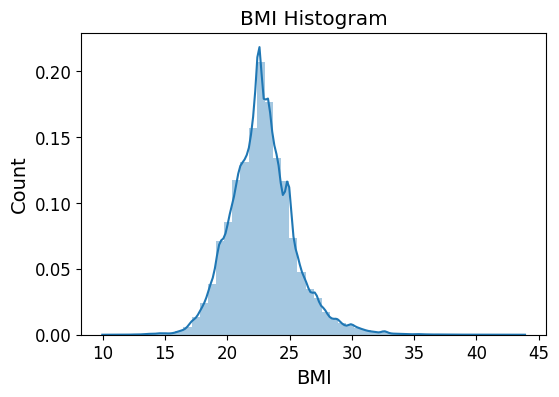

In [212]:
#plot a histogram of age 
bins = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('BMI Histogram')
axs_1.set_xlabel('BMI')
axs_1.set_ylabel('Count')
sns.distplot(df_olympics['BMI'])

Text(0, 0.5, 'BMI')

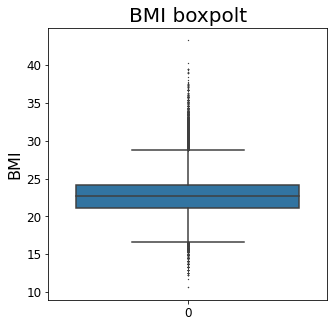

In [213]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=df_olympics['BMI'],fliersize=1/2)

ax.set_title('BMI boxpolt' , fontsize=20)
ax.set_ylabel("BMI",fontsize=16 )


The number of each category of weight status




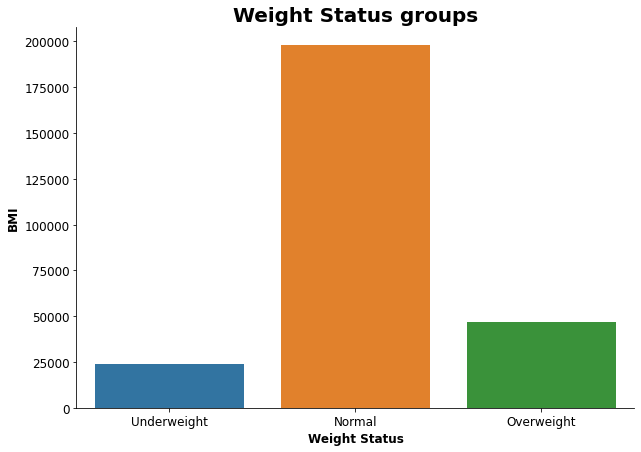

In [214]:
groupedMeans = [len(df_olympics[df_olympics['BMI']<19.5]),(len(df_olympics)- len(df_olympics[df_olympics['BMI']<19.5])-len(df_olympics[df_olympics['BMI']>24.9])) ,len(df_olympics[df_olympics['BMI']>24.9])]

# Getting the count of each weight group
plt.figure(figsize=(10,7))
sns.barplot(x=['Underweight', 'Normal', 'Overweight'], y = groupedMeans)

plt.ylabel('BMI', fontsize=12, weight="bold")
plt.title('Weight Status groups', fontsize = 20, fontweight="bold")
plt.xlabel("Weight Status", fontsize=12, weight="bold")
sns.despine()
plt.show()


Getting the mean BMI per sport

In [215]:
BMIGroupedBySport = df_olympics.groupby('Sport').mean()
(BMIGroupedBySport['BMI'])

Sport
Aeronautics         23.522942
Alpine Skiing       23.837959
Alpinism            23.431009
Archery             23.152106
Art Competitions    24.966326
                      ...    
Tug-Of-War          27.927857
Volleyball          22.564130
Water Polo          24.565827
Weightlifting       26.662137
Wrestling           24.475916
Name: BMI, Length: 66, dtype: float64

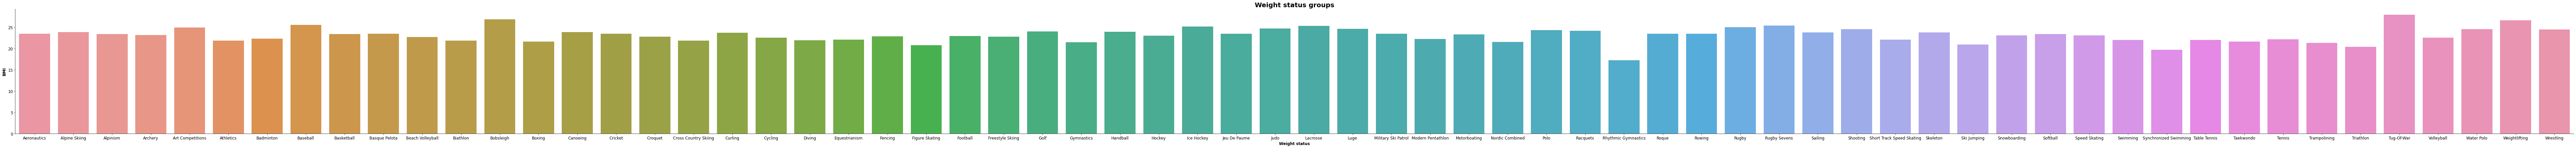

In [216]:
BMIGroupedBySport['Sport'] = BMIGroupedBySport.index

plt.figure(figsize=(140,7))
sns.barplot(x=BMIGroupedBySport['Sport'], y = BMIGroupedBySport['BMI'])

plt.ylabel('BMI', fontsize=12, weight="bold")
plt.title('Weight status groups', fontsize = 20, fontweight="bold")
plt.xlabel("Weight status", fontsize=12, weight="bold")
sns.despine()
plt.show()

BMI ranges (boxplot) per each sport

Text(2, 22.5, 'Normal BMI boundries')

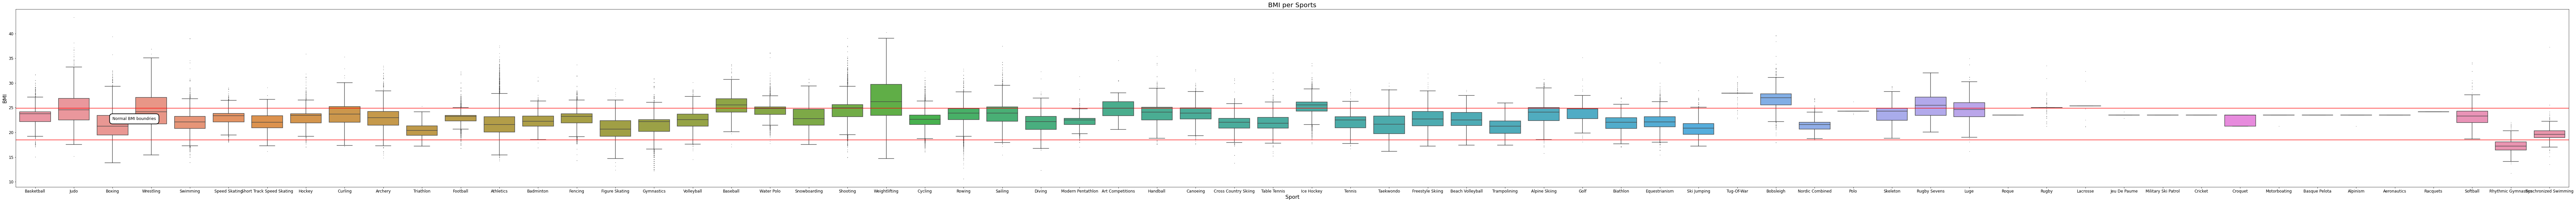

In [217]:
sports = df_olympics.Sport.unique()
fig, ax = plt.subplots(figsize=(140,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(sports)],x='Sport',y='BMI',fliersize=1/2)

plt.title('BMI per Sports');
ax.set_title('BMI per Sports' , fontsize=20)
ax.set_ylabel("BMI",fontsize=16 )
ax.set_xlabel("Sport",fontsize=16 )

plt.axhline(18.5,color='red',linestyle='-')
plt.axhline(24.9,color='red',linestyle='-')
bbox_props = dict(boxstyle="round,pad=0.75", fc="white", ec="black", lw=2)
plt.annotate('Normal BMI boundries',(2,(20+25)/2),bbox=bbox_props)

In [218]:
# 55 sports out of 66 include athletes witha= a BMI above the normal BMI range
sportsCount = df_olympics['Sport'].unique()
print(len(sportsCount))

sportsOverWeight = df_olympics[df_olympics['BMI']>24.9].Sport.unique()
print(len(sportsOverWeight))

66
55


Weight status of the means of the BMI per sport

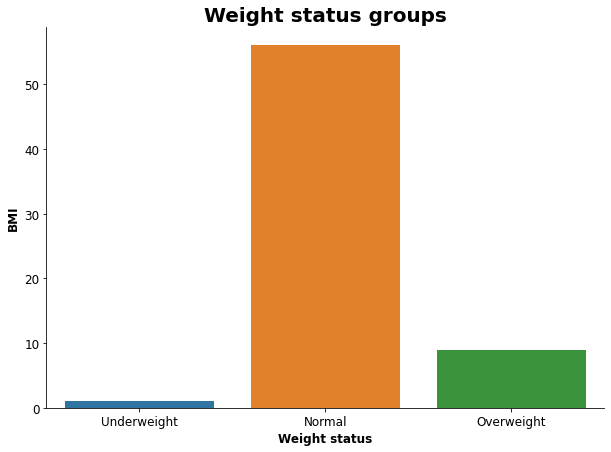

In [219]:
groupedMeans = [len(BMIGroupedBySport[BMIGroupedBySport['BMI']<19.5]),(len(BMIGroupedBySport)- len(BMIGroupedBySport[BMIGroupedBySport['BMI']<19.5])-len(BMIGroupedBySport[BMIGroupedBySport['BMI']>24.9])) ,len(BMIGroupedBySport[BMIGroupedBySport['BMI']>24.9])]

# Getting the count of each gender participation

plt.figure(figsize=(10,7))
sns.barplot(x=['Underweight', 'Normal', 'Overweight'], y = groupedMeans)

plt.ylabel('BMI', fontsize=12, weight="bold")
plt.title('Weight status groups', fontsize = 20, fontweight="bold")
plt.xlabel("Weight status", fontsize=12, weight="bold")
sns.despine()
plt.show()


Overweight BMI sports



In [220]:
avgSportsOverWeight = BMIGroupedBySport[BMIGroupedBySport['BMI']>24.9]
avgSportsOverWeight['Sport'] = avgSportsOverWeight.index
avgSportsOverWeight

ID        Age  ...        BMI             Sport
Sport                                      ...                             
Art Competitions  67522.840336  44.564525  ...  24.966326  Art Competitions
Baseball          68054.561521  26.127660  ...  25.562440          Baseball
Bobsleigh         68862.885219  28.708975  ...  26.845783         Bobsleigh
Ice Hockey        71028.425671  25.735739  ...  25.186052        Ice Hockey
Lacrosse          59381.000000  27.222222  ...  25.335986          Lacrosse
Rugby             65776.135802  24.070175  ...  25.024584             Rugby
Rugby Sevens      67953.153846  26.046823  ...  25.396506      Rugby Sevens
Tug-Of-War        70270.747059  29.309524  ...  27.927857        Tug-Of-War
Weightlifting     69099.768464  25.330368  ...  26.662137     Weightlifting

[9 rows x 8 columns]

Box plots for BMI of overweighted sports

Text(2, 22.5, 'Normal BMI boundries')

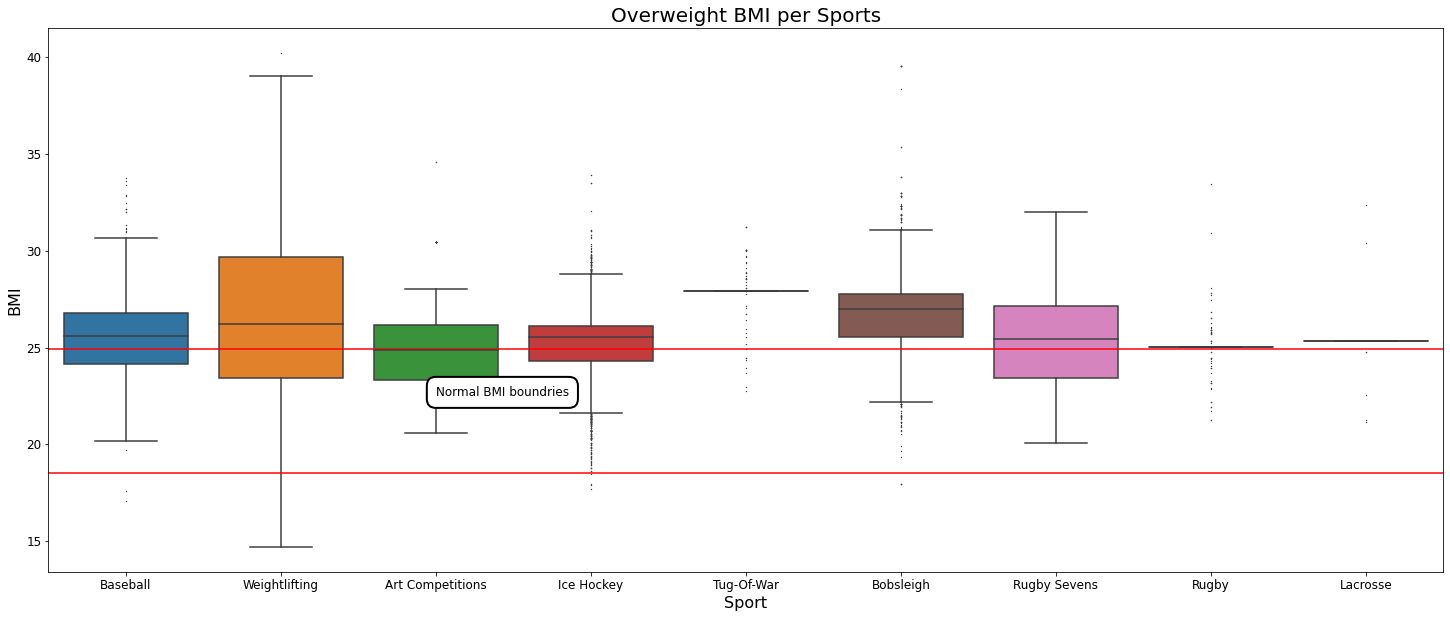

In [221]:
sports = df_olympics.Sport.unique()
fig, ax = plt.subplots(figsize=(25,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(avgSportsOverWeight.index)],x='Sport',y='BMI',fliersize=1/2)

ax.set_title('Overweight BMI per Sports' , fontsize=20)
ax.set_ylabel("BMI",fontsize=16 )
ax.set_xlabel("Sport",fontsize=16 )

plt.axhline(18.5,color='red',linestyle='-')
plt.axhline(24.9,color='red',linestyle='-')
bbox_props = dict(boxstyle="round,pad=0.75", fc="white", ec="black", lw=2)
plt.annotate('Normal BMI boundries',(2,(20+25)/2),bbox=bbox_props)

Underweight BMI sports

In [222]:
avgSportsOverWeight = BMIGroupedBySport[BMIGroupedBySport['BMI']<18.5]
avgSportsOverWeight['Sport'] = avgSportsOverWeight.index
avgSportsOverWeight

ID        Age  ...        BMI                Sport
Sport                                         ...                                
Rhythmic Gymnastics  71169.535658  18.540412  ...  17.241042  Rhythmic Gymnastics

[1 rows x 8 columns]

Box plots for BMI of underweighted sports

Text(2, 22, 'Normal BMI boundries')

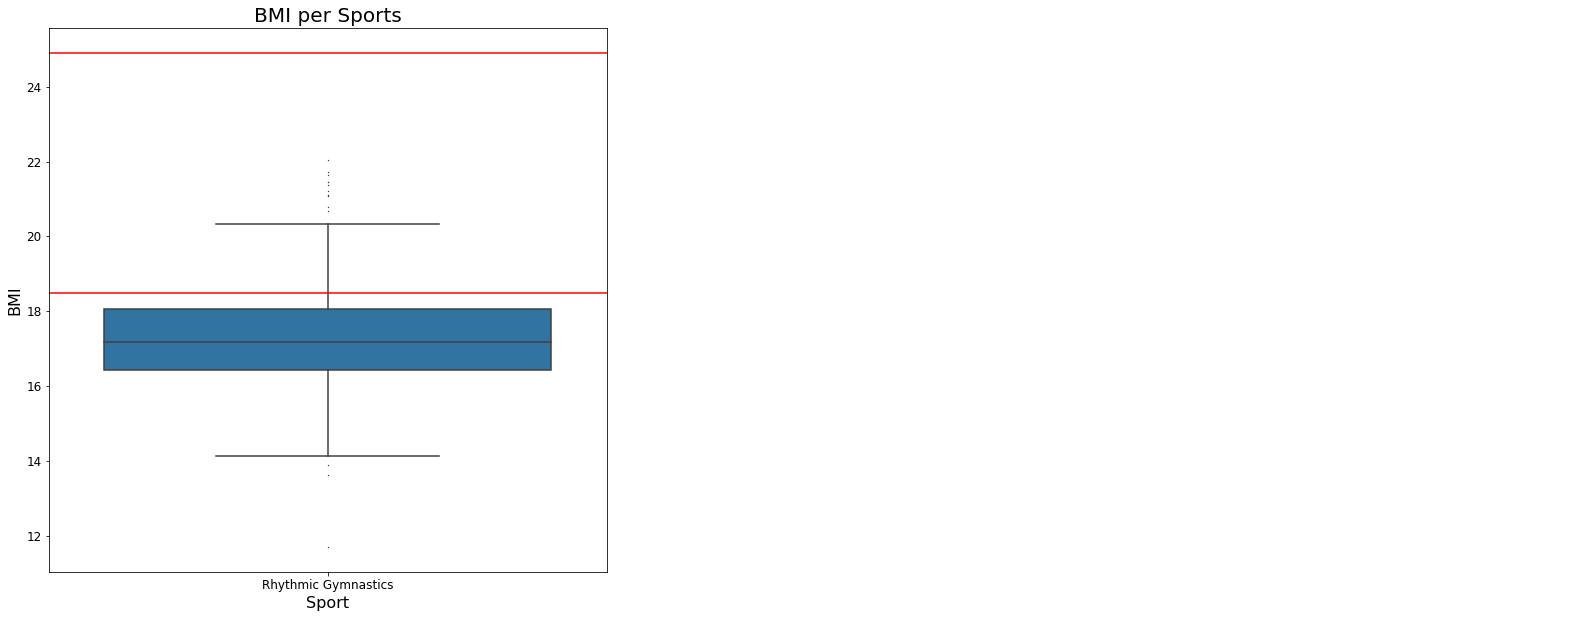

In [223]:
sports = df_olympics.Sport.unique()
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(avgSportsOverWeight.index)],x='Sport',y='BMI',fliersize=1/2)

plt.title('BMI per Sports');
ax.set_title('BMI per Sports' , fontsize=20)
ax.set_ylabel("BMI",fontsize=16 )
ax.set_xlabel("Sport",fontsize=16 )

plt.axhline(18.5,color='red',linestyle='-')
plt.axhline(24.9,color='red',linestyle='-')
bbox_props = dict(boxstyle="round,pad=0.75", fc="white", ec="black", lw=2)
plt.annotate('Normal BMI boundries',(2,22),bbox=bbox_props)

Observing the BMI over the years

In [224]:
BMIGroupedByYear = df_olympics.groupby('Year').mean()
BMIGroupedByYear['Year'] = BMIGroupedByYear.index

BMIGroupedByYear[['Year', 'BMI']]

Year        BMI
Year                 
1896  1896  23.433374
1900  1900  23.779941
1904  1904  23.496757
1906  1906  23.745006
1908  1908  23.412108
1912  1912  23.375869
1920  1920  23.568163
1924  1924  23.354654
1928  1928  23.274480
1932  1932  23.509686
1936  1936  23.282190
1948  1948  23.193437
1952  1952  22.796707
1956  1956  23.044452
1960  1960  22.963060
1964  1964  23.007162
1968  1968  22.798410
1972  1972  22.716500
1976  1976  22.665158
1980  1980  22.653933
1984  1984  22.553144
1988  1988  22.554537
1992  1992  22.643532
1994  1994  22.977532
1996  1996  22.530297
1998  1998  23.071571
2000  2000  22.535696
2002  2002  23.110012
2004  2004  22.601540
2006  2006  22.933408
2008  2008  22.581425
2010  2010  22.916452
2012  2012  22.498977
2014  2014  22.896965
2016  2016  22.516565

Text(0.5, 1.0, 'BMI over the years')

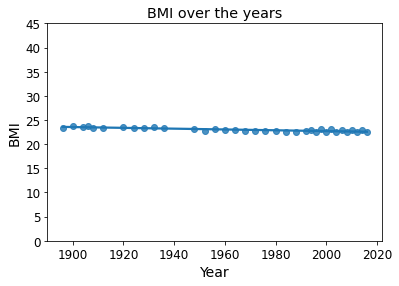

In [225]:
g = sns.regplot(x="Year", y='BMI', data=BMIGroupedByYear);
g.set_ylim(0, 45)
g.set_title('BMI over the years')

In [226]:
BMIGroupedByMedal =  df_olympics.groupby('Medal_Enumarated').mean()
(BMIGroupedByMedal['BMI'])

Medal_Enumarated
0    22.746341
1    23.130048
2    23.170808
3    23.183933
Name: BMI, dtype: float64

BMI over the years for different medals

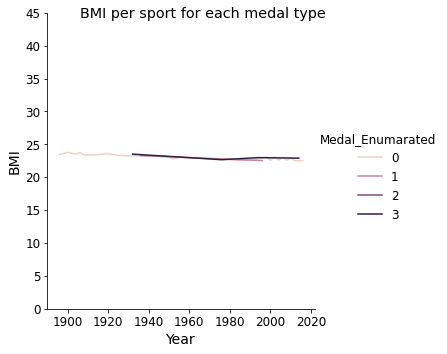

In [227]:

g = sns.relplot(x="Year", y='BMI', hue=df_olympics['Medal_Enumarated'], kind='line', data=BMIGroupedByYear);
g.set_axis_labels("Year", "BMI")
g.fig.suptitle('BMI per sport for each medal type')
g.set(ylim=(0, 45))

BMI along regions

In [228]:
BMIGroupedByRegion = df_olympics.groupby('region').mean()
BMIGroupedByRegion['region'] = BMIGroupedByRegion.index

BMIGroupedByRegion[['region', 'BMI']]

region        BMI
region                                                     
Afghanistan                          Afghanistan  22.734888
Albania                                  Albania  23.479286
Algeria                                  Algeria  22.425112
American Samoa                    American Samoa  26.675794
Andorra                                  Andorra  23.417263
...                                          ...        ...
Virgin Islands, British  Virgin Islands, British  23.011161
Virgin Islands, US            Virgin Islands, US  23.335589
Yemen                                      Yemen  21.745987
Zambia                                    Zambia  21.864666
Zimbabwe                                Zimbabwe  22.483601

[201 rows x 2 columns]

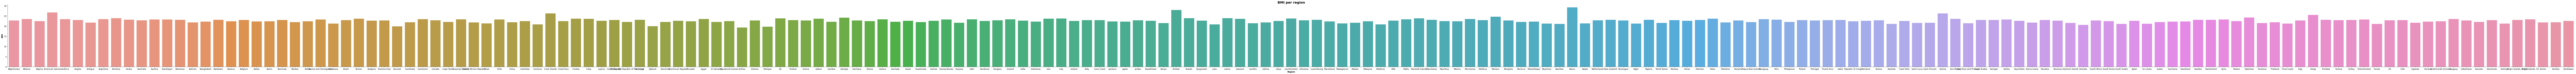

In [229]:
plt.figure(figsize=(280,7))
sns.barplot(x=BMIGroupedByRegion['region'], y = BMIGroupedByRegion['BMI'])

plt.ylabel('BMI', fontsize=12, weight="bold")
plt.title('BMI per region', fontsize = 20, fontweight="bold")
plt.xlabel("Region", fontsize=12, weight="bold")
sns.despine()
plt.show()

Text(2, 22.5, 'Normal BMI boundries')

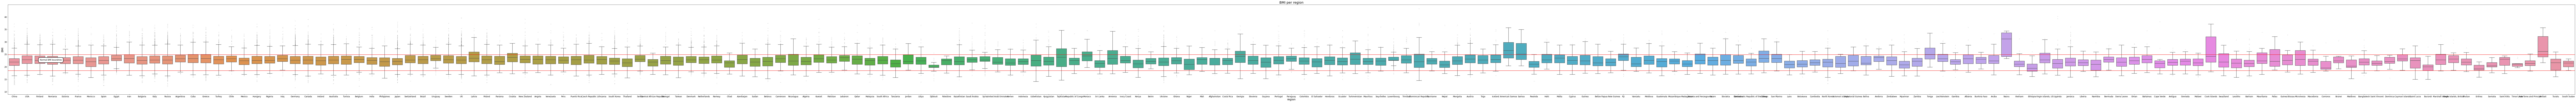

In [230]:
regions = BMIGroupedByRegion.region.unique()
fig, ax = plt.subplots(figsize=(280,10))
sns.boxplot(data=df_olympics[df_olympics.region.isin(regions)],x='region',y='BMI',fliersize=1/2)

plt.title('BMI per region');
ax.set_title('BMI per region' , fontsize=20)
ax.set_ylabel("BMI",fontsize=16 )
ax.set_xlabel("region",fontsize=16 )

plt.axhline(18.5,color='red',linestyle='-')
plt.axhline(24.9,color='red',linestyle='-')
bbox_props = dict(boxstyle="round,pad=0.75", fc="white", ec="black", lw=2)
plt.annotate('Normal BMI boundries',(2,(20+25)/2),bbox=bbox_props)

Overweight BMI per region

Text(2, 22.5, 'Normal BMI boundries')

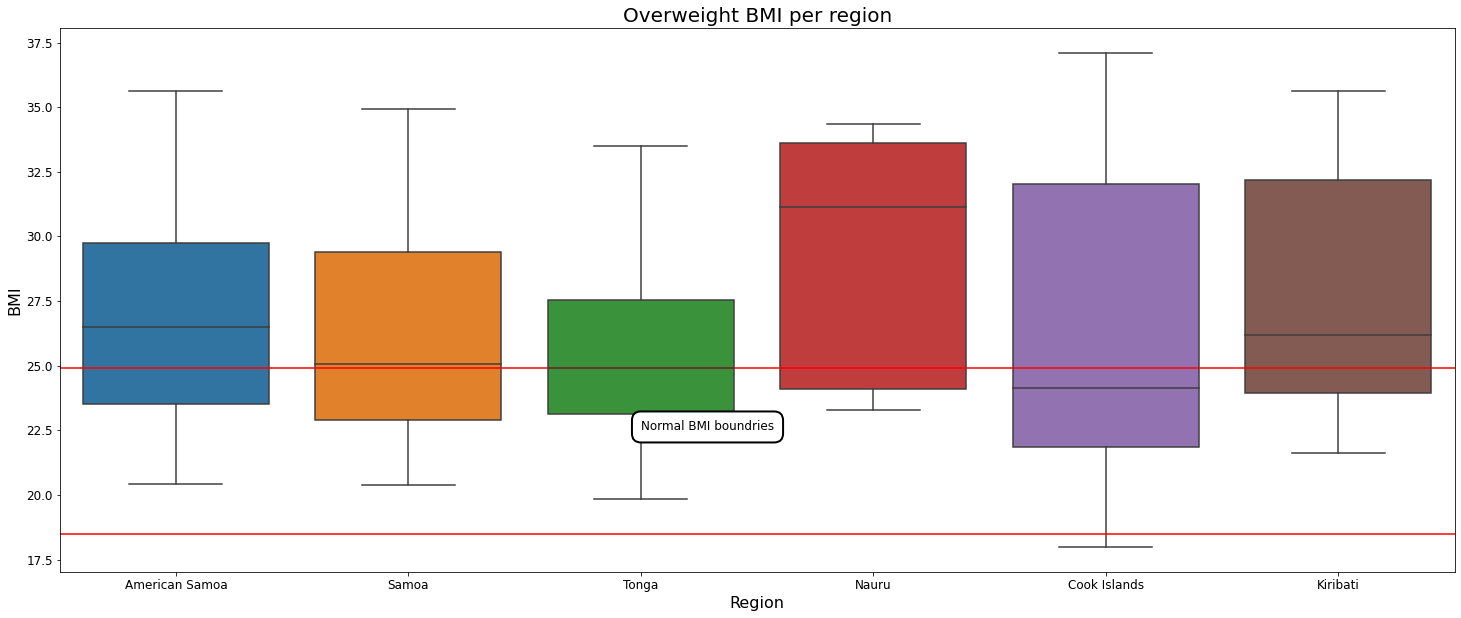

In [231]:
BMIGroupedByRegion = BMIGroupedByRegion[BMIGroupedByRegion['BMI']>24.9]
BMIGroupedByRegion['region'] = BMIGroupedByRegion.index

regions = df_olympics.region.unique()
fig, ax = plt.subplots(figsize=(25,10))
sns.boxplot(data=df_olympics[df_olympics.region.isin(BMIGroupedByRegion.index)],x='region',y='BMI',fliersize=1/2)

ax.set_title('Overweight BMI per region' , fontsize=20)
ax.set_ylabel("BMI",fontsize=16 )
ax.set_xlabel("Region",fontsize=16 )

plt.axhline(18.5,color='red',linestyle='-')
plt.axhline(24.9,color='red',linestyle='-')
bbox_props = dict(boxstyle="round,pad=0.75", fc="white", ec="black", lw=2)
plt.annotate('Normal BMI boundries',(2,(20+25)/2),bbox=bbox_props)

In [232]:
USA_data = df_olympics[df_olympics['region']=='USA']
BMIGroupedByYear = USA_data.groupby('Year').mean()
(BMIGroupedByYear['BMI'])

Year
1896    23.047710
1900    23.135581
1904    23.498473
1906    22.069904
1908    23.445533
1912    23.113079
1920    23.582644
1924    23.148735
1928    23.050579
1932    23.217465
1936    23.075243
1948    22.907943
1952    22.742999
1956    23.006031
1960    22.564756
1964    22.793166
1968    22.736232
1972    22.400421
1976    22.331293
1980    22.820554
1984    22.498747
1988    22.533545
1992    22.656223
1994    23.342581
1996    22.543838
1998    23.559716
2000    22.956592
2002    23.680610
2004    22.986652
2006    23.498884
2008    23.047797
2010    23.804611
2012    23.010431
2014    23.461702
2016    22.774563
Name: BMI, dtype: float64

In [233]:
BMIGroupedByRegion = BMIGroupedByRegion[BMIGroupedByRegion['BMI']<18.5]
BMIGroupedByRegion

Empty DataFrame
Columns: [ID, Age, Height, Weight, Year, Medal_Enumarated, BMI, region]
Index: []

In [234]:
BasketBall_data = df_olympics[df_olympics['Sport']=='Basketball']
BMIGroupedByYear =  BasketBall_data.groupby('Year').mean()
(BMIGroupedByYear['BMI'])

Year
1936    24.256439
1948    24.143307
1952    24.190206
1956    24.259552
1960    23.695659
1964    23.406231
1968    23.321745
1972    23.571715
1976    23.093603
1980    22.810385
1984    23.005203
1988    23.049601
1992    23.070825
1996    22.936967
2000    23.224062
2004    23.246798
2008    23.264958
2012    23.352477
2016    23.449501
Name: BMI, dtype: float64

#### **6- How hosting events affects country's performance?** (feature engineering 2)
We concluded that indeed on average the country's performance increases significantly when the country hosts an event. We can see from the final figures that the majority of the countries and the events, the number of medals gained increases significantly for the countries who were hosting these events.

---



In [235]:
df_olympics['region'].unique()

array(['China', 'USA', 'Finland', 'Romania', 'Estonia', 'France',
       'Morocco', 'Spain', 'Egypt', 'Iran', 'Bulgaria', 'Italy', 'Russia',
       'Argentina', 'Cuba', 'Greece', 'Turkey', 'Chile', 'Mexico',
       'Hungary', 'Nigeria', 'Iraq', 'Germany', 'Canada', 'Ireland',
       'Australia', 'Tunisia', 'Belgium', 'India', 'Philippines', 'Japan',
       'Switzerland', 'Brazil', 'Uruguay', 'Sweden', 'UK', 'Latvia',
       'Poland', 'Panama', 'Croatia', 'New Zealand', 'Angola',
       'Venezuela', 'Peru', 'Puerto Rico', 'Czech Republic', 'Lithuania',
       'South Korea', 'Thailand', 'Serbia', 'Central African Republic',
       'Senegal', 'Taiwan', 'Denmark', 'Netherlands', 'Norway', 'Chad',
       'Azerbaijan', 'Sudan', 'Belarus', 'Cameroon', 'Nicaragua',
       'Algeria', 'Kuwait', 'Pakistan', 'Lebanon', 'Qatar', 'Malaysia',
       'South Africa', 'Tanzania', 'Jordan', 'Libya', 'Djibouti',
       'Palestine', 'Kazakhstan', 'Saudi Arabia', 'Syria',
       'United Arab Emirates', 'Yem

In [236]:
print('Number of Hosting Cities: ', df_olympics['City'].nunique())


Number of Hosting Cities:  42


In [237]:
#The function add_hosting_country takes the olympics dataframe and add a new column Hosting Country of the city hosting the olympics

def add_hosting_country(df):
    german_cities = ['Berlin', 'Munich', 'Garmisch-Partenkirchen']
    italian_cities = ['Roma', 'Torino',"Cortina d'Ampezzo"]
    spanish_cities = ['Barcelona']
    canadian_cities = ['Montreal', 'Vancouver', 'Calgary']
    american_cities = ['Atlanta', 'Los Angeles', 'St. Louis', 'Lake Placid', 'Salt Lake City','Squaw Valley']
    french_cities = ['Paris', 'Albertville', 'Grenoble','Chamonix']
    chineese_cities = ['Beijing']
    greek_cities = ['Athens']
    british_cities = ['London']
    brasilian_cities = ['Rio de Janeiro']
    korean_cities = ['Seoul']
    australian_cities = ['Sydney', 'Melbourne']
    japanese_cities = ['Tokyo', 'Nagano', 'Sapporo']
    mexican_cities = ['Mexico City']
    finnish_cities = ['Helsinki']
    russian_cities = ['Moscow','Sochi']
    belgian_cities = ['Antwerpen']
    dutch_cities = ['Amsterdam']
    swedish_cities = ['Stockholm']
    bosnian_cities = ['Sarajevo']
    norwegian_cities = ['Lillehammer','Oslo']
    swiss_cities = ['Sankt Moritz']
    austrian_cities = ['Innsbruck']

    df2 = df.copy()
    df2['Hosting Country'] = pd.Series()
    df2['Hosting Country'].loc[df['City'].isin(german_cities)] = 'Germany'
    df2['Hosting Country'].loc[df['City'].isin(italian_cities)] = 'Italy'
    df2['Hosting Country'].loc[df['City'].isin(spanish_cities)] = 'Spain'
    df2['Hosting Country'].loc[df['City'].isin(canadian_cities)] = 'Canada'
    df2['Hosting Country'].loc[df['City'].isin(american_cities)] = 'USA'
    df2['Hosting Country'].loc[df['City'].isin(french_cities)] = 'France'
    df2['Hosting Country'].loc[df['City'].isin(chineese_cities)] = 'China'
    df2['Hosting Country'].loc[df['City'].isin(greek_cities)] = 'Greece'
    df2['Hosting Country'].loc[df['City'].isin(british_cities)] = 'UK'
    df2['Hosting Country'].loc[df['City'].isin(brasilian_cities)] = 'Brazil'
    df2['Hosting Country'].loc[df['City'].isin(korean_cities)] = 'South Korea'
    df2['Hosting Country'].loc[df['City'].isin(australian_cities)] = 'Australia'
    df2['Hosting Country'].loc[df['City'].isin(japanese_cities)] = 'Japan'
    df2['Hosting Country'].loc[df['City'].isin(mexican_cities)] = 'Mexico'
    df2['Hosting Country'].loc[df['City'].isin(finnish_cities)] = 'Finland'
    df2['Hosting Country'].loc[df['City'].isin(russian_cities)] = 'Russia'
    df2['Hosting Country'].loc[df['City'].isin(dutch_cities)] = 'Netherlands'
    df2['Hosting Country'].loc[df['City'].isin(chineese_cities)] = 'China'
    df2['Hosting Country'].loc[df['City'].isin(belgian_cities)] = 'Belgium'
    df2['Hosting Country'].loc[df['City'].isin(swedish_cities)] = 'Sweden'
    df2['Hosting Country'].loc[df['City'].isin(bosnian_cities)] = 'Bosnia and Herzegovina'
    df2['Hosting Country'].loc[df['City'].isin(norwegian_cities)] = 'Norway'
    df2['Hosting Country'].loc[df['City'].isin(swiss_cities)] = 'Switzerland'
    df2['Hosting Country'].loc[df['City'].isin(austrian_cities)] = 'Austria'
    
    return df2

In [238]:
df_olympics_hosting = add_hosting_country(df_olympics)
df_olympics_hosting.head()

ID             Name Sex  ...  Medal_Enumarated        BMI  Hosting Country
0        1        A Dijiang   M  ...                 0  24.691358            Spain
167  20211    Chen Jianghua   M  ...                 0  20.875633            China
168  20211    Chen Jianghua   M  ...                 0  20.875633               UK
191  20225          Chen Ke   M  ...                 0  24.990388           Greece
372  20615  Chia Chungchang   M  ...                 0  23.981426               UK

[5 rows x 18 columns]

In [239]:
# Creating a dataframe that corresponds to the participants of athletes when their country is the hosting country

df_country_is_hosting = df_olympics_hosting[(df_olympics_hosting['region'] == df_olympics_hosting['Hosting Country']) & (df_olympics_hosting['Medal_Enumarated'] != 0)]
df_country_is_hosting.head()

ID                            Name  ...        BMI  Hosting Country
14717   2636     Stephen Todd "Steve" Alford  ...  21.621622              USA
15266   7901            Charles Wade Barkley  ...  22.515718              USA
19431  33553          Patrick Aloysius Ewing  ...  23.981426              USA
19817  35789           Vernon "Vern" Fleming  ...  22.090730              USA
21324  45963  Anfernee Deon "Penny" Hardaway  ...  22.750000              USA

[5 rows x 18 columns]

In [240]:
performance_hosting = df_country_is_hosting.groupby(['region','Games'])['Medal_Enumarated'].count()
performance_hosting

region       Games      
Australia    1956 Summer     67
             2000 Summer    183
Austria      1964 Winter     17
             1976 Winter      7
Belgium      1920 Summer    188
Brazil       2016 Summer     50
Canada       1976 Summer     23
             1988 Winter      6
             2010 Winter     90
China        2008 Summer    184
Finland      1952 Summer     40
France       1900 Summer    225
             1924 Summer    110
             1924 Winter     10
             1968 Winter      9
             1992 Winter     12
Germany      1936 Summer    224
             1936 Winter      7
             1972 Summer    253
Greece       1896 Summer     48
             1906 Summer    102
             2004 Summer     31
Italy        1956 Winter      8
             1960 Summer     88
             2006 Winter     25
Japan        1964 Summer     62
             1972 Winter      3
             1998 Winter     13
Mexico       1968 Summer      9
Netherlands  1928 Summer     57
Norway       19

In [241]:
#Creating a dataframe that corresponds to the participants of athletes when their country is NOT the hosting country
df_country_is_not_hosting = df_olympics_hosting[(df_olympics_hosting['region'] != df_olympics_hosting['Hosting Country']) & (df_olympics_hosting['Medal_Enumarated'] != 0)]
df_country_is_not_hosting.head()

ID                                  Name  ...        BMI  Hosting Country
14581   351            Julius Shareef Abdur-Rahim  ...  25.487697        Australia
14746  2863                      Walter Ray Allen  ...  25.227865        Australia
14842  3874  William Lloyd "Willie" Anderson, Jr.  ...  21.500000      South Korea
14870  4505                  Carmelo Kyan Anthony  ...  21.420229           Greece
14871  4505                  Carmelo Kyan Anthony  ...  21.420229            China

[5 rows x 18 columns]

In [242]:
performance_not_hosting = df_country_is_not_hosting.groupby(['region','Games'])['Medal_Enumarated'].count()
performance_not_hosting

region       Games      
Afghanistan  2008 Summer     1
             2012 Summer     1
Algeria      1984 Summer     2
             1992 Summer     2
             1996 Summer     3
                            ..
Zambia       1984 Summer     1
             1996 Summer     1
Zimbabwe     1980 Summer    15
             2004 Summer     3
             2008 Summer     4
Name: Medal_Enumarated, Length: 1579, dtype: int64

**The idea is to compare the average performance of each country when it is hosting vs. when it is not hosting. The metric used is the average number of medals won by each country in both cases(Hosting vs. Not Hosting).**

In [243]:
hosting_countries = df_country_is_hosting['Hosting Country'].unique()
hosting_countries

array(['USA', 'Russia', 'Greece', 'Japan', 'Brazil', 'Germany',
       'South Korea', 'China', 'Netherlands', 'Finland', 'France',
       'Spain', 'Italy', 'Mexico', 'Australia', 'UK', 'Sweden', 'Canada',
       'Belgium', 'Norway', 'Switzerland', 'Austria'], dtype=object)

In [244]:
performance_hosting_dict = {}
medals_hosting_dict = {}
for country in hosting_countries:
    performance_hosting_dict[country] = round(performance_hosting[country].mean(),2)
    medals_hosting_dict[country] = np.array(performance_hosting[country])

    
performance_not_hosting_dict = {}
medals_not_hosting_dict = {}
for country in hosting_countries:
    performance_not_hosting_dict[country] = round(performance_not_hosting[country].mean(),2)
    medals_not_hosting_dict[country] = np.array(performance_not_hosting[country])

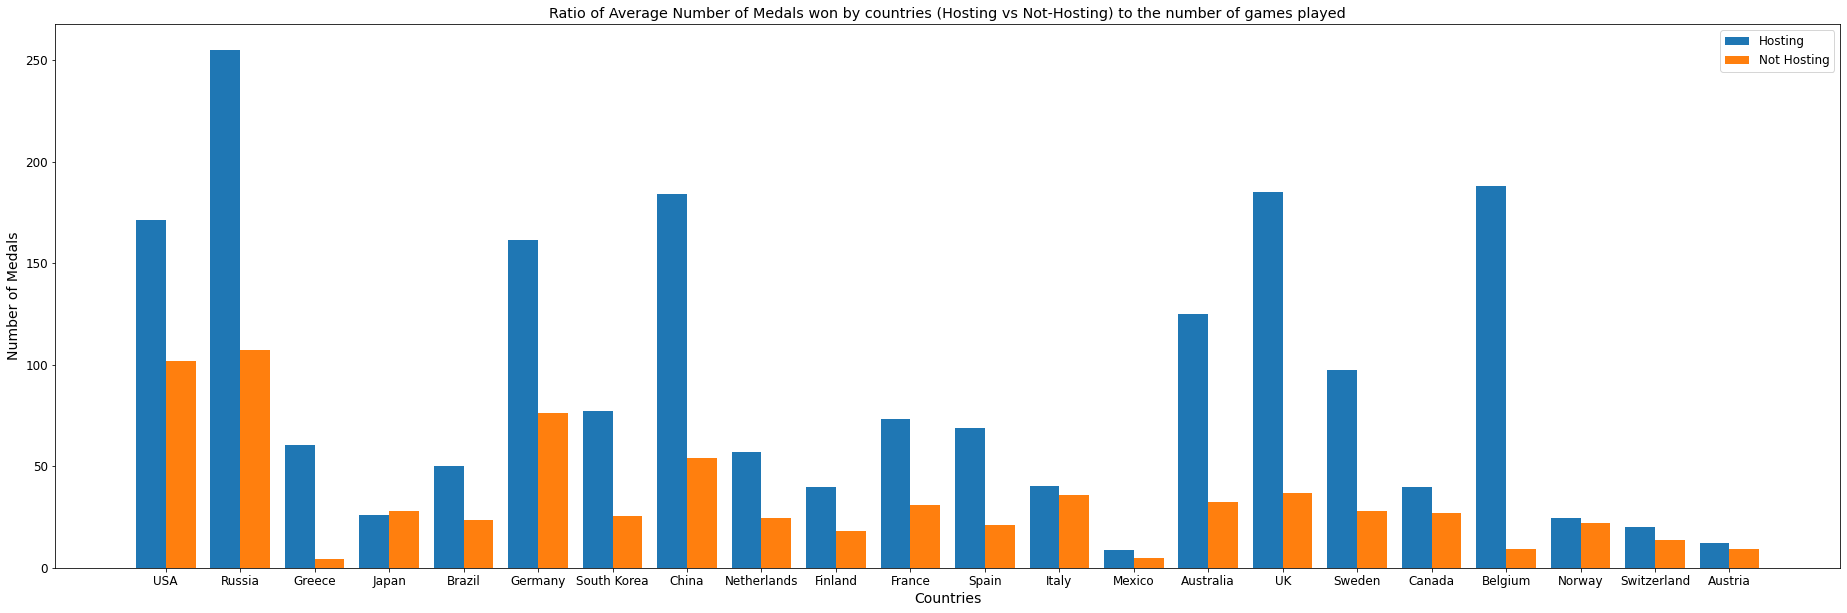

In [245]:
fig, ax = plt.subplots(figsize=(32,10))
X = hosting_countries
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, performance_hosting_dict.values(), 0.4, label = 'Hosting')
plt.bar(X_axis + 0.2, performance_not_hosting_dict.values(), 0.4, label = 'Not Hosting')
  
plt.xticks(X_axis, X)
plt.xlabel("Countries")
plt.ylabel("Number of Medals")
plt.title("Ratio of Average Number of Medals won by countries (Hosting vs Not-Hosting) to the number of games played")
plt.legend()
plt.show()

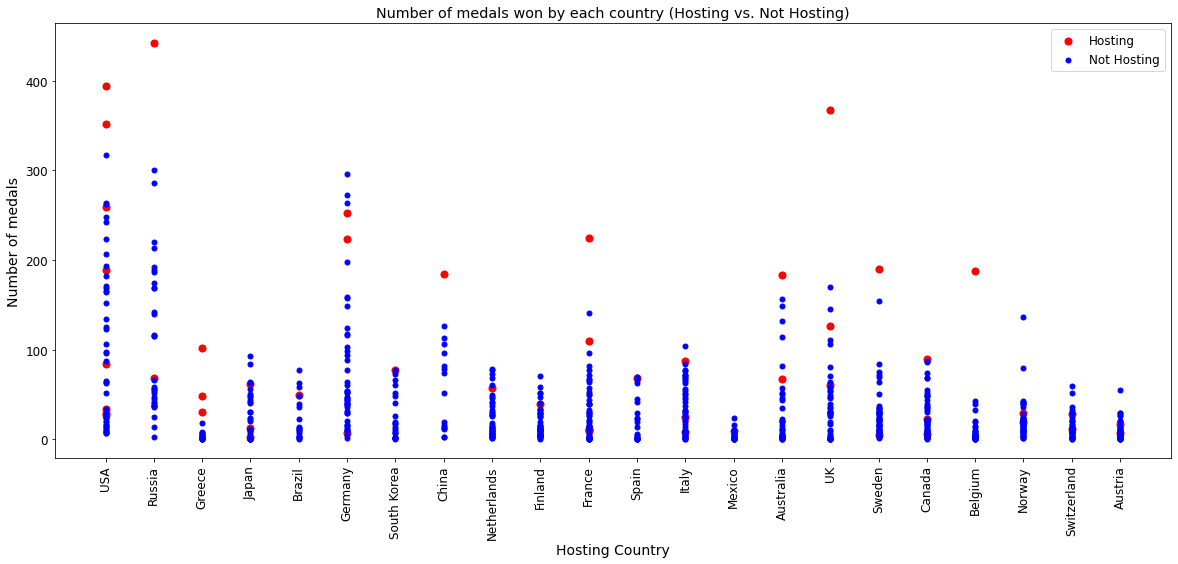

In [246]:
medals_hosting = medals_hosting_dict
medals_not_hosting = medals_not_hosting_dict
labels = hosting_countries

width=0.4
fig, ax = plt.subplots(figsize=(20,8))
for i, l in enumerate(labels):

    hosting = [l] * len(medals_hosting[l])
    ax.scatter(hosting, medals_hosting[l],color='red', s=50)
    
    not_hosting = [l] * len(medals_not_hosting[l])
    ax.scatter(not_hosting, medals_not_hosting[l],color='blue', s=25)
    
#     mean = data[:,i].mean()
#     ax.plot([i-width/2., i+width/2.], color="k")


ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Number of medals won by each country (Hosting vs. Not Hosting)')
plt.xlabel('Hosting Country')
plt.ylabel('Number of medals')
plt.legend(['Hosting','Not Hosting'])
plt.show()

---

#### **7- Do countries with high gdp are chosen to host the olympics ?**

This question aims at exploring if countries with high gdp are mainly chosen for hosting the olympics.

1- Remove the countries which has NaN in the GDP column. The only country without GDP is *Western Sahara*

2- Rename some of the countries to match the naming in the athletes dataset.
 United Kingdom -> UK &
 United States -> USA &
 Korea, South -> South Korea
 
3- High GDP countries are those which have GDP higher than the third quantile (75th percentile)

4- The results show that out of 22 countries that hosted the olympics, 18 of them have GDP higher than the third quantile.

---



In [272]:
df_countries

region GDP ($ per capita)
0           Afghanistan                700
1               Albania               4500
2               Algeria               6000
3        American Samoa               8000
4               Andorra              19000
..                  ...                ...
224               Yemen                800
225              Zambia                800
226            Zimbabwe               1900
227         South Sudan             1900.0
228  Virgin Islands, US            17200.0

[229 rows x 2 columns]

In [273]:
df_countries[df_countries['GDP ($ per capita)'].isna()]

region GDP ($ per capita)
223  Western Sahara                NaN

In [274]:
df_countries_gdp_nonan = df_countries.dropna(subset=['GDP ($ per capita)'])
df_countries_gdp_nonan[df_countries_gdp_nonan['GDP ($ per capita)'].isna()]

Empty DataFrame
Columns: [region, GDP ($ per capita)]
Index: []

In [275]:
df_countries_gdp_nonan['region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Boliva', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Is.', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Myanmar', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Democratic Republic of the Congo', 'Republic of Congo',
       'Cook Islands', 'Costa Rica', 'Ivory Coast', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Timor-Leste', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faroe Islands', 'Fij

In [276]:
df_countries_gdp_nonan.replace('United Kingdom','UK',inplace=True)
df_countries_gdp_nonan.replace('United States','USA',inplace=True)
df_countries_gdp_nonan.replace('Korea, South','South Korea',inplace=True)

In [277]:
df_countries_gdp_nonan['GDP ($ per capita)'] = df_countries_gdp_nonan['GDP ($ per capita)'].astype('float32')
df_countries_gdp_nonan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 228
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              228 non-null    object 
 1   GDP ($ per capita)  228 non-null    float32
dtypes: float32(1), object(1)
memory usage: 4.5+ KB


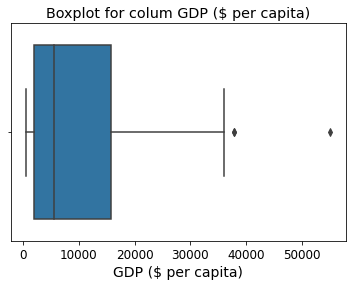

In [278]:
sns.boxplot(df_countries_gdp_nonan['GDP ($ per capita)'])
plt.title('Boxplot for colum GDP ($ per capita)');

**The countries that have GDP higher than the third quantile are cosidered to have HIGH GDP**

In [279]:
Q3 = df_countries_gdp_nonan['GDP ($ per capita)'].quantile(0.75)
print('75th Quantile is: ', Q3)

75th Quantile is:  15775.0


In [280]:
high_gdp_countries = np.array(df_countries_gdp_nonan[df_countries_gdp_nonan['GDP ($ per capita)'] > Q3]['region'])
high_gdp_countries

array(['Andorra', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Bahrain',
       'Belgium', 'Bermuda', 'British Virgin Is.', 'Brunei', 'Canada',
       'Cayman Islands', 'Cyprus', 'Denmark', 'Faroe Islands', 'Finland',
       'France', 'French Polynesia', 'Germany', 'Gibraltar', 'Greece',
       'Greenland', 'Guam', 'Guernsey', 'Hong Kong', 'Iceland', 'Ireland',
       'Isle of Man', 'Palestine', 'Italy', 'Japan', 'Jersey',
       'South Korea', 'Kuwait', 'Liechtenstein', 'Luxembourg', 'Macau',
       'Malta', 'Monaco', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Puerto Rico', 'Qatar', 'San Marino', 'Singapore',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Taiwan',
       'United Arab Emirates', 'UK', 'USA', 'Virgin Islands, British',
       'Virgin Islands, US'], dtype=object)

In [281]:
count = 0
low_gdp_hosting_countries = []
for country in hosting_countries:
    if country not in high_gdp_countries:
        count+=1
        low_gdp_hosting_countries.append(country)
print('Number of hosting countries with gdp less than third quantile is: ', count)
print('Hosting Countries with low GDP: ', low_gdp_hosting_countries)

Number of hosting countries with gdp less than third quantile is:  4
Hosting Countries with low GDP:  ['Russia', 'Brazil', 'China', 'Mexico']


In [306]:
hosting_countries

array(['USA', 'Russia', 'Greece', 'Japan', 'Brazil', 'Germany',
       'South Korea', 'China', 'Netherlands', 'Finland', 'France',
       'Spain', 'Italy', 'Mexico', 'Australia', 'UK', 'Sweden', 'Canada',
       'Belgium', 'Norway', 'Switzerland', 'Austria'], dtype=object)

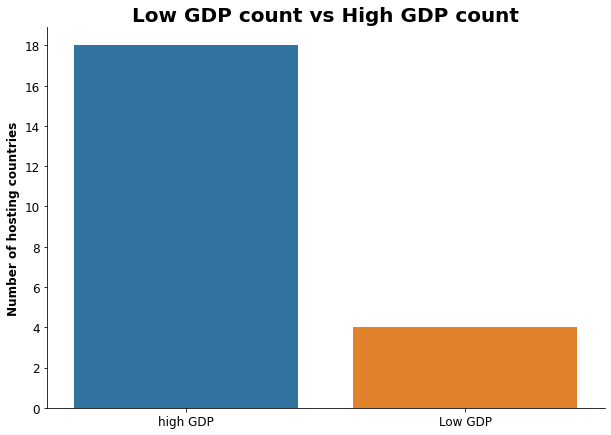

In [314]:
highGDP_count = len(hosting_countries) - len(low_gdp_hosting_countries)

plt.figure(figsize=(10,7))
sns.barplot(x=['high GDP', 'Low GDP'], y = [highGDP_count, len(low_gdp_hosting_countries)])

plt.ylabel('Number of hosting countries', fontsize=12, weight="bold")
plt.title('Low GDP count vs High GDP count', fontsize = 20, fontweight="bold")
# plt.ylim(0,20)
plt.yticks(range(0,20,2))
sns.despine()
plt.show()

#### **8- Do the number of medals on average increase as an athlete participates more?**

We recognised that there is weak/no relationship between the number of participations an athletes does and the number of medals they win. That is unlike what was expected, which was participating more increases the chances of winning a medal. But after plotting the bar graphs and applying the correlation methods we found out the correlation was very weak.

---



**Highest performers, based on the number of medals they gained**

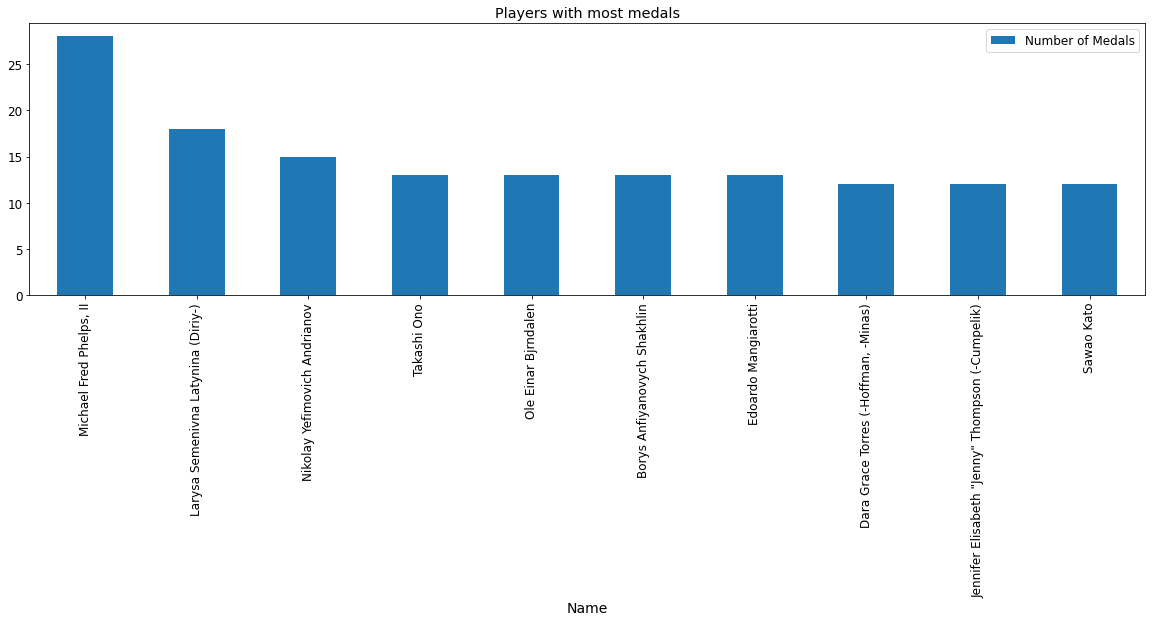

In [282]:
# getting top 10 players according to the number of medals they gained
allMedals = df_olympics[df_olympics['Medal_Enumarated'] != 0]
mostPlayersWithMedals = allMedals.groupby('Name').size().sort_values(ascending=False).reset_index().head(10)
mostPlayersWithMedals.columns = ['Name', 'Number of Medals']

order = mostPlayersWithMedals.index

fig, ax = plt.subplots(figsize=(20,5))
mostPlayersWithMedals.plot.bar(x = 'Name', y ='Number of Medals', rot = 90, ax = ax)

plt.xticks(rotation=90);
plt.title('Players with most medals');

**Frequency of top 10 participants with their corresponding number of medals**



In [283]:
#gettting the number of games each athelete participated in
mostFrequentPlayers = df_olympics.groupby('Name').size().sort_values(ascending=False).reset_index()
mostFrequentPlayers.columns = ['Name', 'participations']

#getting the total number of medal each athelete won
medalHolders = df_olympics[df_olympics['Medal_Enumarated'] != 0]
medalHoldersCount = medalHolders.groupby('Name').size().sort_values(ascending=False).reset_index()
medalHoldersCount.columns = ['Name', 'medals count']

df_merged_athletes = pd.merge(mostFrequentPlayers, medalHoldersCount, how='left',on='Name')
df_merged_athletes = df_merged_athletes.fillna(0)
df_merged_athletes

Name  participations  medals count
0                        Heikki Ilmari Savolainen              39           9.0
1                           Joseph "Josy" Stoffel              38           0.0
2                             Ioannis Theofilakis              36           1.0
3                                     Takashi Ono              33          13.0
4                                  Andreas Wecker              32           5.0
...                                           ...             ...           ...
134170                              Lucien Lafert               1           0.0
134171                             Lucien Laplace               1           0.0
134172                            Lucien Marinier               1           0.0
134173                             Lucien Michard               1           1.0
134174    Gabrielle Marie "Gabby" Adcock (White-)               1           0.0

[134175 rows x 3 columns]

Top 10 participations with their gained medals

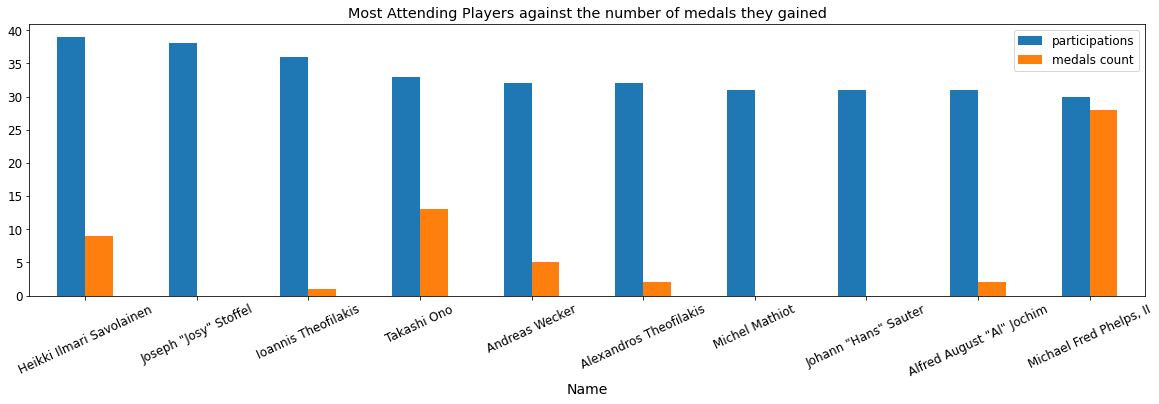

In [284]:
fig, ax = plt.subplots(figsize=(20,5))
df_merged_athletes.head(10).plot.bar(x = 'Name', y = ['participations','medals count'], rot = 40, ax = ax)

plt.xticks(rotation=25);
plt.title('Most Attending Players against the number of medals they gained');


Top 10 athletes with medals and their corresponding number of participations

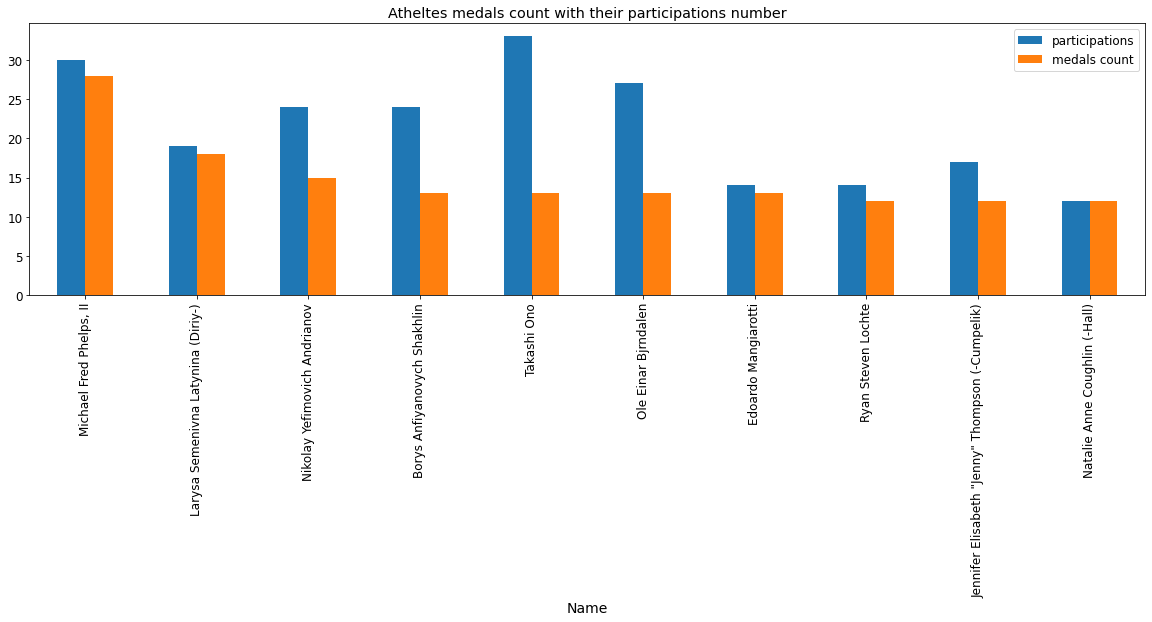

In [285]:
fig, ax = plt.subplots(figsize=(20,5))
df_merged_athletes.sort_values(by='medals count',ascending=False).head(10).plot.bar(x = 'Name', y = ['participations','medals count'], rot = 40, ax = ax)

plt.xticks(rotation=90);
plt.title('Atheltes medals count with their participations number');

In [286]:
df_merged_athletes[['participations', 'medals count']].corr(method='kendall') # --> correlation = 0.33

participations  medals count
participations        1.000000      0.204677
medals count          0.204677      1.000000

In [287]:
df_merged_athletes[['participations', 'medals count']].corr(method='pearson') # --> correlation = 0.33

participations  medals count
participations        1.000000      0.360232
medals count          0.360232      1.000000

#### **9- What are the performances of both genders?**

Most of these sports have historically been male dominated, number of males participants are more than the double of the number of female participants. Also, it seemed that total number of medals won by males were more than medals won by females. This may sound logical considering the ratio of participants. However the percentage of winning a medal in respect to the gender is almost the same. As well as, male gender tend to participate more in up following events than females, with a ratio of 52 and 45 for males and females, respectively.

\
The very first Olympic game did not include any female, but there has been a great improvement in female representation ever since. Late 1980s showed the highest increase in the number of female participations.

---



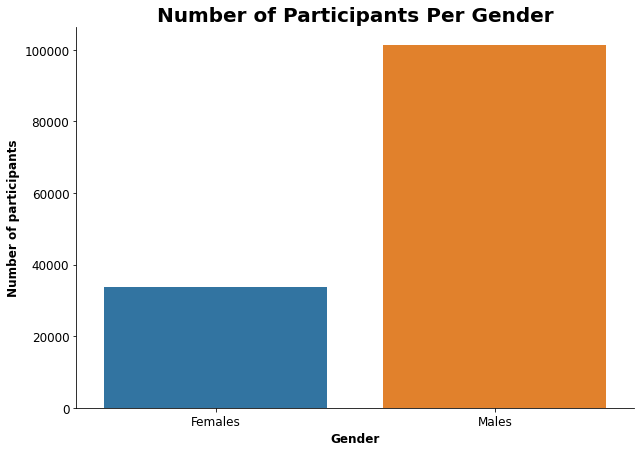

In [288]:
# Getting the count of each gender participation
malesCount = len(df_olympics[df_olympics['Sex'] == 'M']['ID'].unique())
femalesCount = len(df_olympics[df_olympics['Sex'] == 'F']['ID'].unique())

plt.figure(figsize=(10,7))
sns.barplot(x=['Females', 'Males'], y = [femalesCount, malesCount])
plt.xlabel('Gender')

plt.ylabel('Number of participants', fontsize=12, weight="bold")
plt.title('Number of Participants Per Gender', fontsize = 20, fontweight="bold")
plt.xlabel("Gender", fontsize=12, weight="bold")
sns.despine()
plt.show()

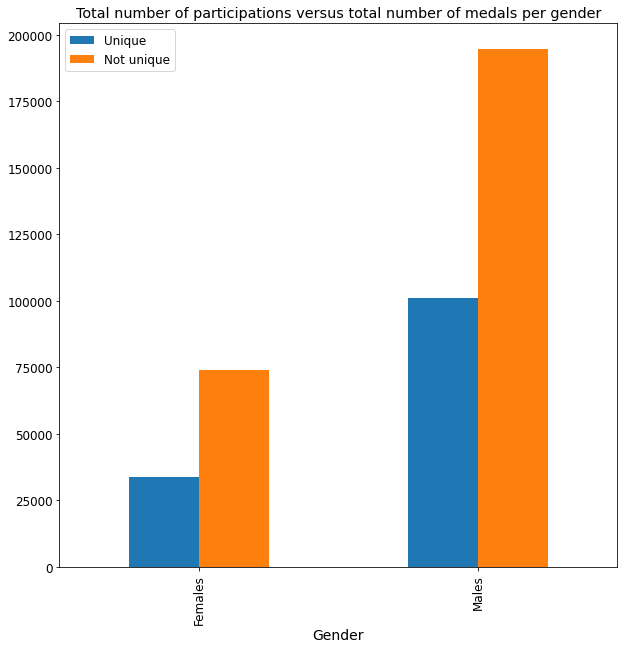

In [289]:
# Observing non unique participations, players that tend to join following games
malesCountNotUnique = len(df_olympics[df_olympics['Sex'] == 'M']['ID'])
femalesCountNotUnique = len(df_olympics[df_olympics['Sex'] == 'F']['ID'])

data = [['Females', femalesCount, femalesCountNotUnique], ['Males', malesCount, malesCountNotUnique]]

genderRatio = pd.DataFrame(data, columns = ['Gender', 'Unique', 'Not unique'])

fig, ax = plt.subplots(figsize=(10,10))
genderRatio.plot.bar(x = 'Gender', y = ['Unique', 'Not unique'], ax = ax)
plt.title('Total number of participations versus total number of medals per gender');

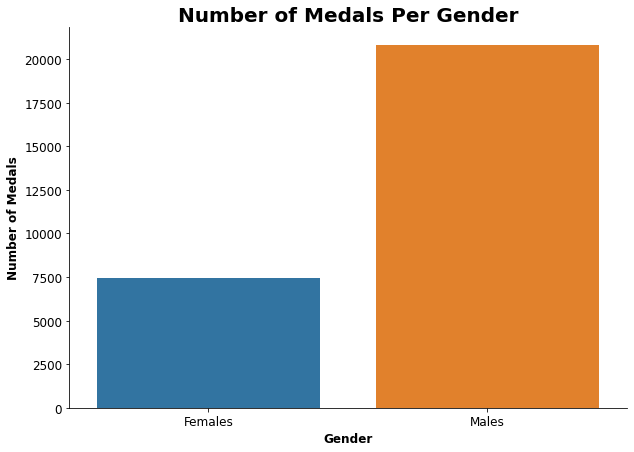

In [290]:
malesCountMedal = len(df_olympics[(df_olympics['Sex'] == 'M') & (df_olympics['Medal_Enumarated'] != 0) ]['ID'].unique())
femalesCountMedal = len(df_olympics[(df_olympics['Sex'] == 'F') & (df_olympics['Medal_Enumarated'] != 0)]['ID'].unique())

plt.figure(figsize=(10,7))
sns.barplot(x=['Females', 'Males'], y = [femalesCountMedal, malesCountMedal])
plt.xlabel('Gender')
# plt.xticks(rotation = 90, )
plt.ylabel('Number of Medals', fontsize=12, weight="bold")
plt.title('Number of Medals Per Gender', fontsize = 20, fontweight="bold")
plt.xlabel("Gender", fontsize=12, weight="bold")
sns.despine()
plt.show()

In [291]:
print("The percentage of males winning medals respect to the number of participants: ", malesCountMedal/malesCount*100)
print("The percentage of females winning medals respect to the number of participants: ", femalesCountMedal/femalesCount*100)

The percentage of males winning medals respect to the number of participants:  20.54071680550203
The percentage of females winning medals respect to the number of participants:  22.027031023570817


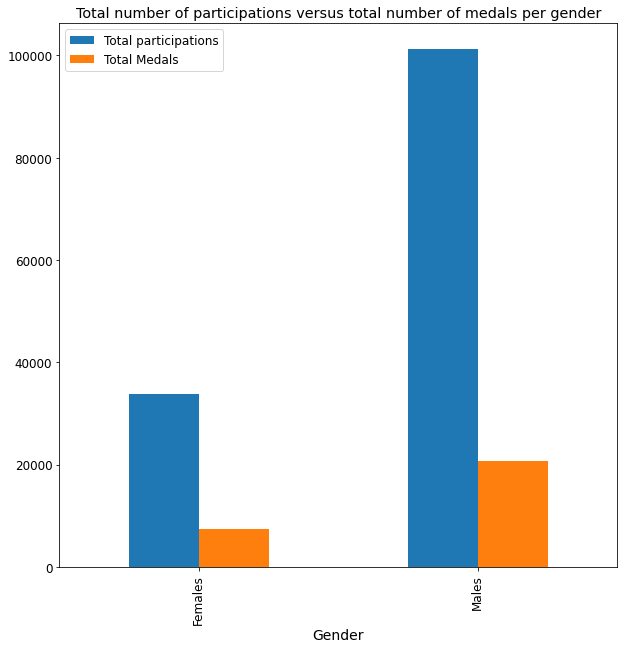

In [292]:
data = [['Females', femalesCount, femalesCountMedal], ['Males', malesCount, malesCountMedal]]

genderRatio = pd.DataFrame(data, columns = ['Gender', 'Total participations', 'Total Medals'])

fig, ax = plt.subplots(figsize=(10,10))
genderRatio.plot.bar(x = 'Gender', y = ['Total participations', 'Total Medals'], ax = ax)
plt.title('Total number of participations versus total number of medals per gender');

Comparison between female vs male for the top two countries


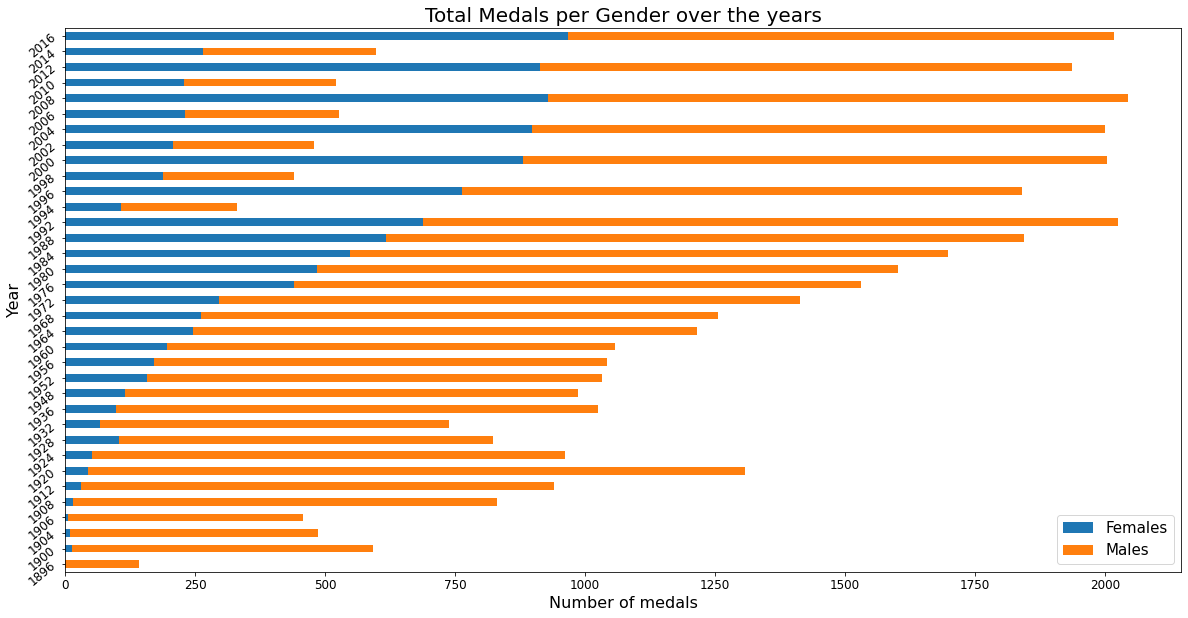

In [293]:
YearGroupData=df_olympics.groupby('Year')
  
df_Female = pd.DataFrame(columns = ['Year', 'Gold_Female', 'Silver_Female' , 'Bronze_Female'])
df_Male = pd.DataFrame(columns = ['Year', 'Gold_Male', 'Silver_Male' , 'Bronze_Male'])
df_F_M= pd.DataFrame(columns = ['Year', 'GoldF', 'SilverF' , 'BronzeF', 'GoldM', 'SilverM' , 'BronzeM','TotalF','TotalM'])
 
for i,j in YearGroupData:
    GoldF, SilverF, BronzeF, GoldM, SilverM, BronzeM=0,0,0,0,0,0
    female=j[j['Sex']=="F"]
    male=j[j['Sex']=="M"] 
    GoldF = len(female[ female['Medal_Enumarated']==3])
    SilverF =len(female[ female['Medal_Enumarated']==2])
    BronzeF =len(female[ female['Medal_Enumarated']==1])  
    GoldM = len( male[male['Medal_Enumarated']==3])
    SilverM =len( male[ male['Medal_Enumarated']==2])
    BronzeM =len( male[  male['Medal_Enumarated']==1])
    totalF=GoldF+SilverF+BronzeF
    totalM=GoldM+SilverM+BronzeM
    new_rowF={'Year': i ,'Gold_Female':GoldF , 'Silver_Female': SilverF , 'Bronze_Female': BronzeF}  
    new_rowM={'Year': i ,'Gold_Male': GoldM , 'Silver_Male':SilverM , 'Bronze_Male': BronzeM}
    df_Female =df_Female.append(new_rowF,  ignore_index=True)
    df_Male=df_Male.append( new_rowM , ignore_index=True)  
    new_row2={'Year': i ,'GoldF':GoldF , 'SilverF': SilverF , 'BronzeF':BronzeF, 'GoldM': GoldM, 'SilverM':SilverM , 'BronzeM':BronzeM ,'TotalF':totalF,'TotalM':totalM }   
    df_F_M=df_F_M.append(  new_row2 ,  ignore_index=True)

fig, ax = plt.subplots(figsize=(20,10))
df_F_M.plot(x = 'Year', y = ['TotalF','TotalM'], kind="barh", stacked=True, rot = 40, ax = ax) 
plt.title('Total Medals per Gender over the years',fontsize=20); 
 
#ax.set_title('Difference in Germany Performance in the Host Year vs other Years' , fontsize=30)
ax.set_xlabel("Number of medals",fontsize=16 )
ax.set_ylabel("Year",fontsize=16)
ax.legend(['Females', 'Males'], fontsize=15)


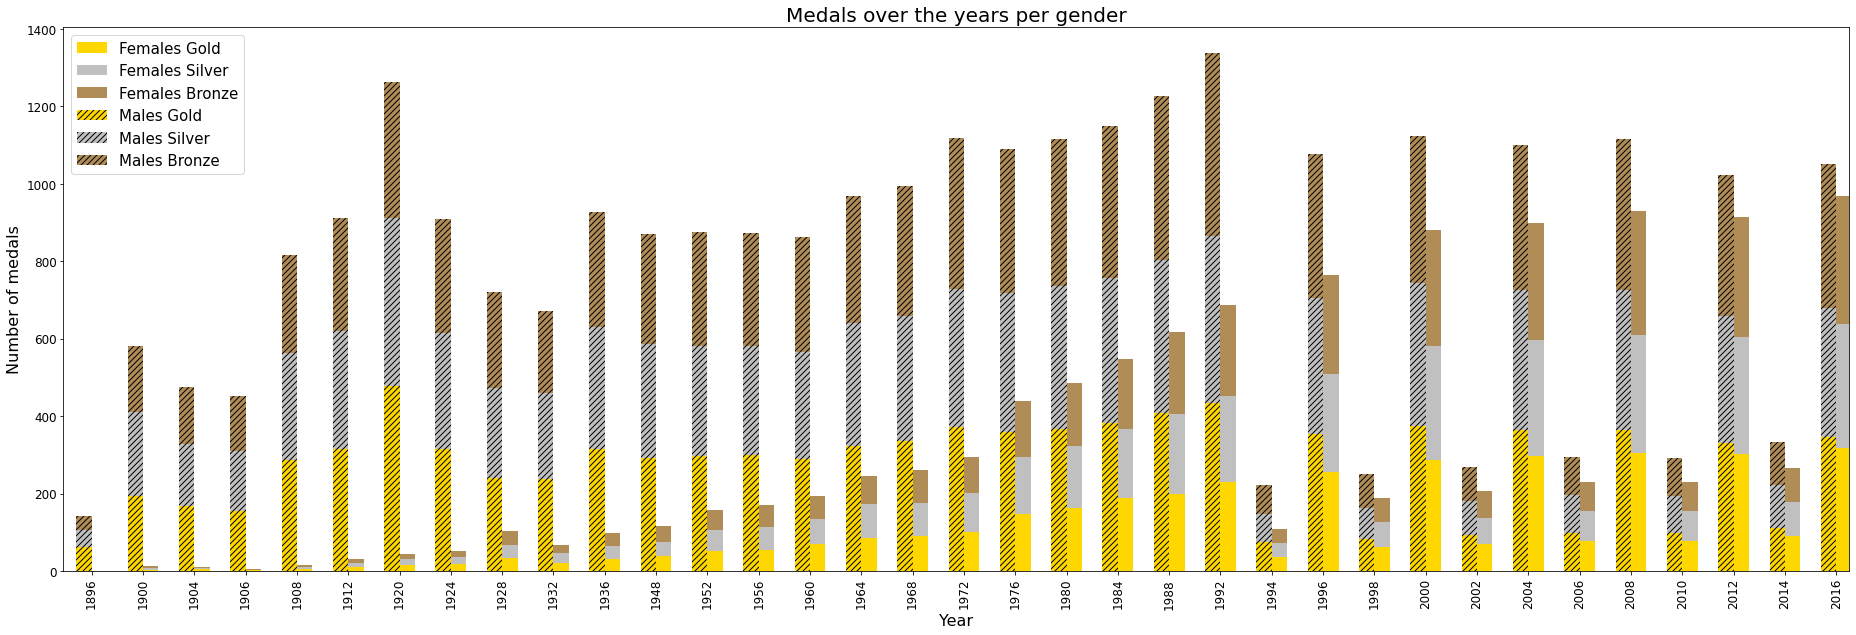

In [294]:
fig, ax = plt.subplots(figsize=(32,10))

df_Female.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'],width=0.3,position=0, ax=ax)
df_Male.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'],width=0.3, position=1, hatch='////', ax=ax)

ax.set_title('Medals over the years per gender' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Year",fontsize=16 )
ax.legend(['Females Gold', 'Females Silver', 'Females Bronze', 'Males Gold', 'Males Silver', 'Males Bronze'], fontsize=15)

#### **10- Is the number of medals related to the number of each medal?**
We found out that as the total number of medals increase, the number of gold, silver, and bronze medals increase separately, which does make sense, that is the positive correlation. The silver medals always had the strongest correlation. But we also recognised that for the performers, the composition of total medals are the highest for gold, we found that the gold medals were gained more, either per region or per athletes, and this was unexpected.

---



In [295]:
# Getting the regions winning each medal sperately
topGoldMedals = df_olympics.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='count')
topSilverMedals = df_olympics.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='count')
topBronzeMedals = df_olympics.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='count')

# How many each country participated
numberOfParticipationPerCountry = df_olympics.groupby('region')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)

# Getting all athletes won any medal
df_medalHolders = df_olympics[df_olympics['Medal_Enumarated']!= 0]

# Getting the number of all medals (gold+silver+bronze) each reegion won 
df_medalHolders_Performance =  df_medalHolders.groupby('region')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
df_medalHolders_Performance_all = df_medalHolders_Performance
df_medalHolders_Performance = df_medalHolders_Performance.head(10).sort_values(by=['count'], ascending=True).head(10)

goldMedals = df_medalHolders.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='gold').sort_values(by=['gold'], ascending=True)
silverMedals = df_medalHolders.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='silver').sort_values(by=['silver'], ascending=True)
bronzeMedals = df_medalHolders.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='bronze').sort_values(by=['bronze'], ascending=True)

# merging the datasets on the region name
mergedMedalsCounts = pd.merge(df_medalHolders_Performance, goldMedals,left_on = 'region',right_on = 'region')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, silverMedals,left_on = 'region',right_on = 'region')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, bronzeMedals,left_on = 'region',right_on = 'region')
mergedMedalsCounts


region  count  gold  silver  bronze
0    Hungary   1135   432     332     371
1  Australia   1349   368     459     522
2     Canada   1352   463     438     451
3     Sweden   1536   479     522     535
4      Italy   1637   575     531     531
5     France   1767   499     602     666
6         UK   2067   677     739     651
7    Germany   3756  1301    1195    1260
8     Russia   3947  1599    1170    1178
9        USA   5637  2638    1641    1358

Correlation between total number of medals and each type

In [296]:
mergedMedalsCounts.corr(method='pearson')

count      gold    silver    bronze
count   1.000000  0.985734  0.995077  0.966263
gold    0.985734  1.000000  0.967873  0.910876
silver  0.995077  0.967873  1.000000  0.976118
bronze  0.966263  0.910876  0.976118  1.000000

Exploring the correlation of all performers, not only the top ones.

In [297]:
df_medalHolders_Performance_all

mergedMedalsCountsALL = pd.merge(df_medalHolders_Performance_all, goldMedals,left_on = 'region',right_on = 'region')
mergedMedalsCountsALL = pd.merge(mergedMedalsCountsALL, silverMedals,left_on = 'region',right_on = 'region')
mergedMedalsCountsALL = pd.merge(mergedMedalsCountsALL, bronzeMedals,left_on = 'region',right_on = 'region')

mergedMedalsCountsALL

region  count  gold  silver  bronze
0          USA   5637  2638    1641    1358
1       Russia   3947  1599    1170    1178
2      Germany   3756  1301    1195    1260
3           UK   2067   677     739     651
4       France   1767   499     602     666
..         ...    ...   ...     ...     ...
126     Guyana      1     0       0       1
127  Guatemala      1     0       1       0
128    Eritrea      1     0       0       1
129      Sudan      1     0       1       0
130     Jordan      1     1       0       0

[131 rows x 5 columns]

In [298]:
mergedMedalsCountsALL.corr(method='pearson')

count      gold    silver    bronze
count   1.000000  0.982554  0.995397  0.982458
gold    0.982554  1.000000  0.964320  0.932720
silver  0.995397  0.964320  1.000000  0.986961
bronze  0.982458  0.932720  0.986961  1.000000

Text(0, 0.5, 'Gold medals')

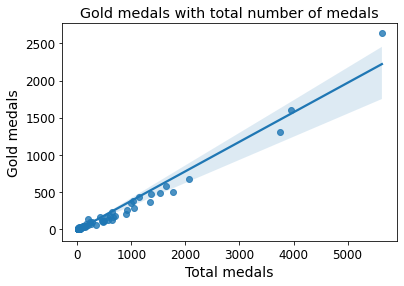

In [299]:
ax=sns.regplot(mergedMedalsCountsALL['count'], mergedMedalsCountsALL['gold'])
ax.set_title('Gold medals with total number of medals')
ax.set_xlabel("Total medals")
ax.set_ylabel("Gold medals")

Text(0, 0.5, 'Silver medals')

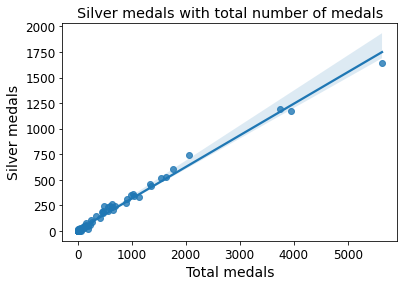

In [300]:
ax=sns.regplot(mergedMedalsCountsALL['count'], mergedMedalsCountsALL['silver'])
ax.set_title('Silver medals with total number of medals')
ax.set_xlabel("Total medals")
ax.set_ylabel("Silver medals")

Text(0, 0.5, 'Bronze medals')

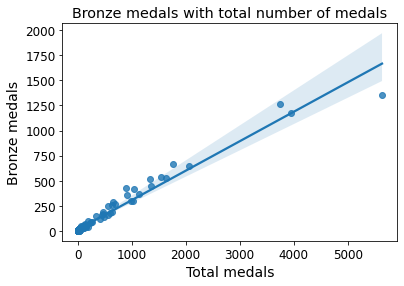

In [301]:
ax=sns.regplot(mergedMedalsCountsALL['count'], mergedMedalsCountsALL['bronze'])
ax.set_title('Bronze medals with total number of medals')
ax.set_xlabel("Total medals")
ax.set_ylabel("Bronze medals")

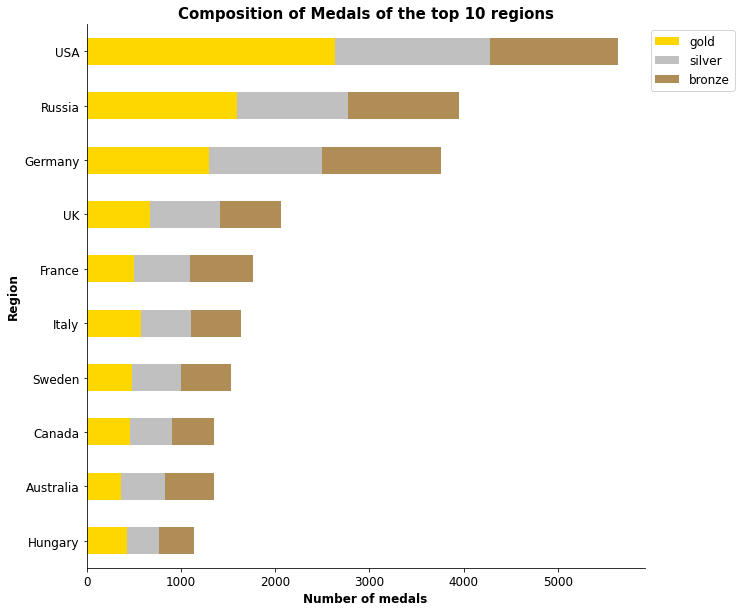

In [302]:
mergedMedalsCounts = mergedMedalsCounts.set_index("region")
mergedMedalsCounts[['gold', 'silver', 'bronze']].head(10).plot(kind='barh', stacked=True, figsize= (10, 10), color=['#FFD700', '#c0c0c0', '#b08d57'])

plt.xlabel("Number of medals", fontsize=12, fontweight="bold")
plt.ylabel("Region", fontsize=12, fontweight="bold")
plt.title('Composition of Medals of the top 10 regions', fontsize=15, weight="bold")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
sns.despine()
ax.legend(['Gold', 'Silver', 'Bronze'], fontsize=15)
plt.show()

Same process as previous, the regions, but for athletes instead. The medals for the top athletes.

In [303]:
topGoldMedals = df_olympics.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='count')
topSilverMedals = df_olympics.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='count')
topBronzeMedals = df_olympics.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='count')

numberOfParticipationPerAthlete = df_olympics.groupby('Name')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)

df_medalHolders = df_olympics[df_olympics['Medal_Enumarated']!= 0]
df_medalHolders_Performance =  df_medalHolders.groupby('Name')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False).head(10)
df_medalHolders_Performance =  df_medalHolders_Performance.sort_values(by=['count'], ascending=True).head(10)

goldMedals = df_medalHolders.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='gold').sort_values(by=['gold'], ascending=True)
silverMedals = df_medalHolders.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='silver').sort_values(by=['silver'], ascending=True)
bronzeMedals = df_medalHolders.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='bronze').sort_values(by=['bronze'], ascending=True)

mergedMedalsCounts = pd.merge(df_medalHolders_Performance, goldMedals,left_on = 'Name',right_on = 'Name')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, silverMedals,left_on = 'Name',right_on = 'Name')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, bronzeMedals,left_on = 'Name',right_on = 'Name')
mergedMedalsCounts


Name  count  gold  silver  bronze
0                  Ryan Steven Lochte     12     6       3       3
1              Birgit Fischer-Schmidt     12     8       4       0
2       Natalie Anne Coughlin (-Hall)     12     3       4       5
3                         Takashi Ono     13     5       4       4
4                 Edoardo Mangiarotti     13     6       5       2
5         Borys Anfiyanovych Shakhlin     13     7       4       2
6                 Ole Einar Bjrndalen     13     8       4       1
7        Nikolay Yefimovich Andrianov     15     7       5       3
8  Larysa Semenivna Latynina (Diriy-)     18     9       5       4
9             Michael Fred Phelps, II     28    23       3       2

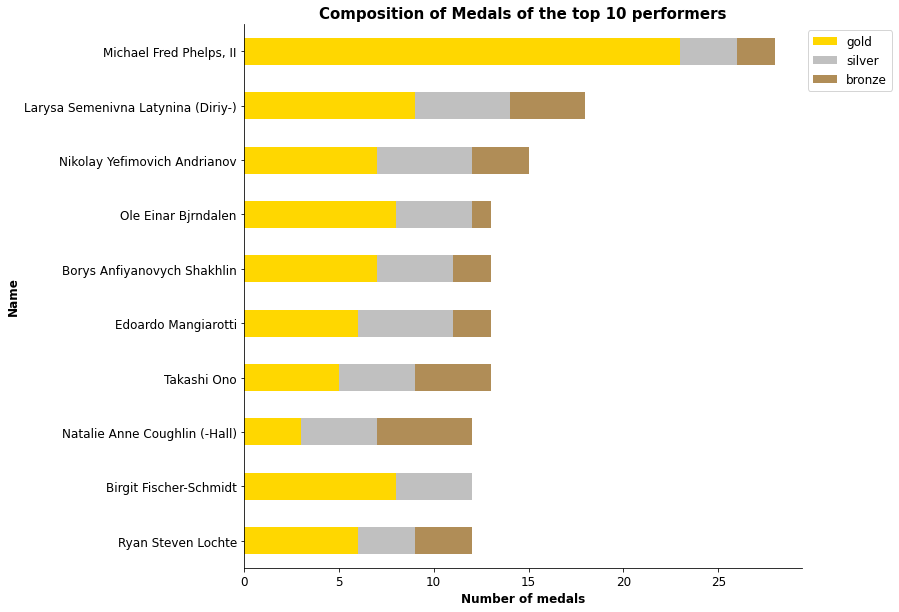

In [304]:
mergedMedalsCounts = mergedMedalsCounts.set_index("Name")
mergedMedalsCounts[['gold', 'silver', 'bronze']].head(10).plot(kind='barh', stacked=True, figsize= (10, 10), color=['#FFD700', '#c0c0c0', '#b08d57'])

plt.xlabel("Number of medals", fontsize=12, fontweight="bold")
plt.ylabel("Name", fontsize=12, fontweight="bold")
plt.title('Composition of Medals of the top 10 performers', fontsize=15, weight="bold")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
sns.despine()
ax.legend(['Gold', 'Silver', 'Bronze'], fontsize=15)
plt.show()